# Notebook for generating Figures 3 - 7 and 9 in Traill et al. (2025) 
Reproduces all Figures 3 - 7 and 9, including Appendix A figures A1.1, A1.2, A1.3, A1.4, A1.5, A1.6 and A1.7. Processes PISCES-Quota-Fe output, calculates diagnostics (including re-calculated grazing diagnostic terms) and iterative perform bootstrap analysis. 



Christopher Traill: christopher.traill@utas.edu.au

https://github.com/cdtraill

November 2025

Latest update: 11th December 2025

## Readme 

The code presented here can be simply adapated to any ocean region by changing the spatial domain. Note that in regions where the subtropical front doesn't occur, derviations of the subtropical front will drop out and potentially cause code errors. These sections can be easily omitted by commenting out sections. 

Directories are currently mapped to datasets on disk. For larger PISCES subsets, environments and directories will need to be set up for HPC research environments and source datasets from scratch storage.

## Datasets: 

For full details, see the Methods of Traill et al. (2025) "Towards Constraining the Drivers of Variability and Trends in Subantarctic Productivity"

This notebook primarily analyses output from PISCES-Quota-Fe (Tagliabue et al., 2023). Figure 3 also uses observational NPP, SST, MLD and STF data sources to generate a taylor diagram comparing PISCES to observations. 

PISCES-Quota-Fe incorporates three phytoplankton types (nanophytoplankton, picophytoplankton and diatoms), independent carbon, nitrogen, phosphorus, silica and iron stoichiometry within phytoplankton, dissolved organic and particle pools, with the addition of two aeolian-derived lithogenic particle tracers (fine lithogenic particles and aggregated lithogenic particles). Two zooplankton groups (microzooplankton and mesozooplankton) are included, but both have fixed stoichiometry (Kwiatkowski et al., 2018).

A full description of the model run used in this study, including equations and comparison between PISCES-Quota and PISCES-Quota-Fe, are described in Tagliabue et al. (2023). 

PISCES-Quota-Fe was coupled to the Nucleus for European Modelling of the Ocean version 4.0 (NEMO-v4.0) general ocean circulation model and Sea Ice modelling Integrated Initiative (SI3) sea ice model. The hindcast simulation was forced with JRA-55 atmospheric reanalysis (Tsujino et al., 2018) for the period 1958-2022. Horizontal model resolution is nominally 2° but increases to ∼1° at high latitudes and ∼0.5° at the equator, while the vertical resolution varies between 10- and 500-m thickness over 31 depth-coordinate levels. Model output analysis was performed on the mean monthly time series from 1975-2022 to avoid model initialization bias in the first 17 years of the simulation (Buchanan and Tagliabue, 2021). 



In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, TwoSlopeNorm
import matplotlib.cm as cm
import matplotlib.ticker as mticker
from matplotlib.dates import DateFormatter
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.interpolate import griddata
from scipy import stats
import calendar
import pandas as pd 
import cartopy
from geopy.distance import geodesic
from geopy import Point
import gsw
import cartopy.crs as ccrs 
import cartopy.feature as cfeature 
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import netCDF4 as nc
import xarray as xr
import owslib
import os
import cftime
import sys
import string

Check environment setup

In [2]:
## Check environment and Set required path to data file. 
print("Actual active environment = Python executable:", sys.executable)
print("Python version:", sys.version)

Actual active environment = Python executable: /Users/christoph/opt/anaconda3/envs/Analysis/bin/python
Python version: 3.10.18 (main, Jun  5 2025, 08:13:51) [Clang 14.0.6 ]


### Set directory path

In [3]:
# change your directory path here. 
path = '/Users/christoph/Library/CloudStorage/OneDrive-UniversityofTasmania/Research/PhD Project/Theme 3 Model Obs/' 
os.chdir(path)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/christoph/Library/CloudStorage/OneDrive-UniversityofTasmania/Research/PhD Project/Theme 3 Model Obs


## Load datasets & set up data structures

Tracer file (biogeochemical params) in 2 datasets

In [4]:
# Open NC file
trc_t1 = xr.open_dataset('PISCES-Quota-Fe/QUO_JRA5_1m_SO_extract_ptrc.nc')
trc_t2 = xr.open_dataset('PISCES-Quota-Fe/QUO_JRA5_1m_SO_extract_ptrc_2.nc')

trc_t = xr.merge([trc_t1, trc_t2])

trc_t1.close()
trc_t2.close()
del trc_t1
del trc_t2

Diagnostic data (diad) files: in 2 datasets

In [5]:
# Loading files from cloud is a lot of data (2.13 Gb per file). 
diad_t1 = xr.open_dataset('PISCES-Quota-Fe/QUO_JRA5_1m_SO_extract_diad.nc')
diad_t2 = xr.open_dataset('PISCES-Quota-Fe/QUO_JRA5_1m_SO_extract_diad_2.nc')

diad_t = xr.merge([diad_t1, diad_t2])

diad_t1.close()
diad_t2.close()
del diad_t1
del diad_t2

Physics dataset (run offline, since dataset)

T contains main grid parameters. U, V and W contain respective vector/grid cell face parameters

The time grid is rebuilt to replace arbitrary interger year values ('record') with actual year values as in the diagnotistic and tracer datasets

In [6]:
T = xr.open_dataset('/Users/christoph/Library/CloudStorage/OneDrive-UniversityofTasmania/Research/PhD Project/Theme 3 Model Obs/NEMO PISCES contemporary hindcast/NEMO-PISCES_AusRegion_1m_grid_T_1958-2022.nc')
#U = xr.open_dataset('/Users/christoph/Library/CloudStorage/OneDrive-UniversityofTasmania/Research/PhD Project/Theme 3 Model Obs/NEMO PISCES contemporary hindcast/NEMO-PISCES_AusRegion_1m_grid_U_1958-2022.nc')
#V = xr.open_dataset('/Users/christoph/Library/CloudStorage/OneDrive-UniversityofTasmania/Research/PhD Project/Theme 3 Model Obs/NEMO PISCES contemporary hindcast/NEMO-PISCES_AusRegion_1m_grid_V_1958-2022.nc')
#W = xr.open_dataset('/Users/christoph/Library/CloudStorage/OneDrive-UniversityofTasmania/Research/PhD Project/Theme 3 Model Obs/NEMO PISCES contemporary hindcast/NEMO-PISCES_AusRegion_1m_grid_W_1958-2022.nc')

## Build new time coordinate in T to match that of diad_t ad trc_t. 
# Template: 12 monthly datetime objects from T
monthly_template = T.time_counter.values  # shape (12,)

# Number of years (from record dimension)
n_years = len(T.record)

# Extract the base year from the template
base_year = monthly_template[0].year

# Generate full monthly series by updating the year of the template
full_time_counter = []

for i in range(n_years):
    year = base_year + i
    for month_idx, base_date in enumerate(monthly_template):
        # Replace year while preserving month, day, hour, etc.
        full_time_counter.append(
            cftime.DatetimeNoLeap(
                year, base_date.month, base_date.day,
                base_date.hour, base_date.minute, base_date.second,
                base_date.microsecond, has_year_zero=True
            )
        )

# Flatten T into a full monthly time series and assign new time_counter
T_full = T.stack(full_time=("record", "time_counter"))
T_full = T_full.assign_coords(full_time=("full_time", full_time_counter))

# Rename for consistency
T_full = T_full.rename(full_time="time_counter")

T.close()
del T

/var/folders/dk/4pyn7w4102bfzscb0m9606zw0000gn/T/ipykernel_9606/4079472414.py:33: FutureWarning: updating coordinate 'full_time' with a PandasMultiIndex would leave the multi-index level coordinates ['record', 'time_counter'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['full_time', 'record', 'time_counter'])` before assigning new coordinate values.
  T_full = T_full.assign_coords(full_time=("full_time", full_time_counter))


# Calculate drivers, mechanism & responses climatology 

## Subset datasets

In [7]:
# SOTS region (STF/SAZ border)
min_lat = -49
max_lat = -45
min_lon = 139.9
max_lon = 150

# Years to subset under Record. 
subsetting_years = np.arange(1975, 2023) 

# Subset datasets
subset_diag = diad_t.where(
    (diad_t.nav_lat >= min_lat) & (diad_t.nav_lat <= max_lat) & 
    (diad_t.nav_lon >= min_lon) & (diad_t.nav_lon <= max_lon) &
    (diad_t.time_counter.dt.year.isin(subsetting_years)),
    drop=True)

subset_T = T_full.where(
    (T_full.nav_lat >= min_lat) & (T_full.nav_lat <= max_lat) & 
    (T_full.nav_lon >= min_lon) & (T_full.nav_lon <= max_lon) &
    (T_full.time_counter.dt.year.isin(subsetting_years)),
    drop=True)

subset_trc = trc_t.where(
    (trc_t.nav_lat >= min_lat) & (trc_t.nav_lat <= max_lat) & 
    (trc_t.nav_lon >= min_lon) & (trc_t.nav_lon <= max_lon) &
    (trc_t.time_counter.dt.year.isin(subsetting_years)),
    drop=True)

def assign_july_year(ds):
    # Extract the datetime array
    times = ds.time_counter.values
    
    # Compute july_year based on month
    july_year = [t.year if t.month >= 7 else t.year - 1 for t in times]
    
    # Add as a coordinate to the dataset
    ds = ds.assign_coords(july_year=("time_counter", july_year))
    # Add month as a coordinate with which to group climatologies later. 
    ds = ds.assign_coords(month=ds['time_counter'].dt.month)
    return ds

# Apply to each subset
subset_diag = assign_july_year(subset_diag)
subset_T = assign_july_year(subset_T)
subset_trc = assign_july_year(subset_trc)

print('Subsetting complete')

Subsetting complete


## Extract variables

In [8]:
# Physical variables
mld = subset_T['mldr10_1']         # Mixed layer depth
sst = subset_T['tos']              # SST
temperature = subset_T['thetao']   # Temperature
depth = subset_T['deptht']         # Depth
depth_thickness = subset_T['e3t']  # grid cell thickness (height)
area = subset_T['area']            # grid cell area

# Diagnostic variables
ppphyn = subset_diag['PPPHYN']      # NPP nanophytoplankton
ppphyd = subset_diag['PPPHYD']      # NPP diatoms
ppphyp = subset_diag['PPPHYP']      # NPP picophytoplankton
LNlight = subset_diag['LNlight']    # Light limitation term nanophy.
LDlight = subset_diag['LDlight']    # Light limitation term diatoms
LPlight = subset_diag['LPlight']    # Light limitation term picophy.
LNFe = subset_diag['LNFe']          # Light limitation term nanophy.
LDFe = subset_diag['LDFe']          # Light limitation term diatoms.
LPFe = subset_diag['LPFe']          # Light limitation term picophy.
LNN = subset_diag['LNN']            # Nitrogen limitation term nanophy.
LDN = subset_diag['LDN']            # Nitrogen limitation term diatoms.
LPN = subset_diag['LPN']            # Nitrogen limitation term picophy.

# Tracer variables
phyn_conc = subset_trc['PHY']       # Nanophytoplankton C biomass
phyd_conc = subset_trc['PHY2']      # diatom C biomass
phyp_conc = subset_trc['PIC']       # picophytoplankton C biomass
phyn_chl = subset_trc['NCHL']       # nanophytoplankton Chlorphyll conc.
phyd_chl = subset_trc['DCHL']       # diatom Chlorphyll conc.
phyp_chl = subset_trc['PCHL']       # picophytoplankton Chlorphyll conc.
dfe = subset_trc['Fer']             # dissolved iron concentration
microzoop = subset_trc['ZOO']       # microzooplankon biomass
mesozoop = subset_trc['ZOO2']       # mesozooplankton biomass

## Figure A1.1: Check spatial nutrient limitation state: 

/var/folders/dk/4pyn7w4102bfzscb0m9606zw0000gn/T/ipykernel_9606/4244772821.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r')
/var/folders/dk/4pyn7w4102bfzscb0m9606zw0000gn/T/ipykernel_9606/4244772821.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Leave space for colorbar and title


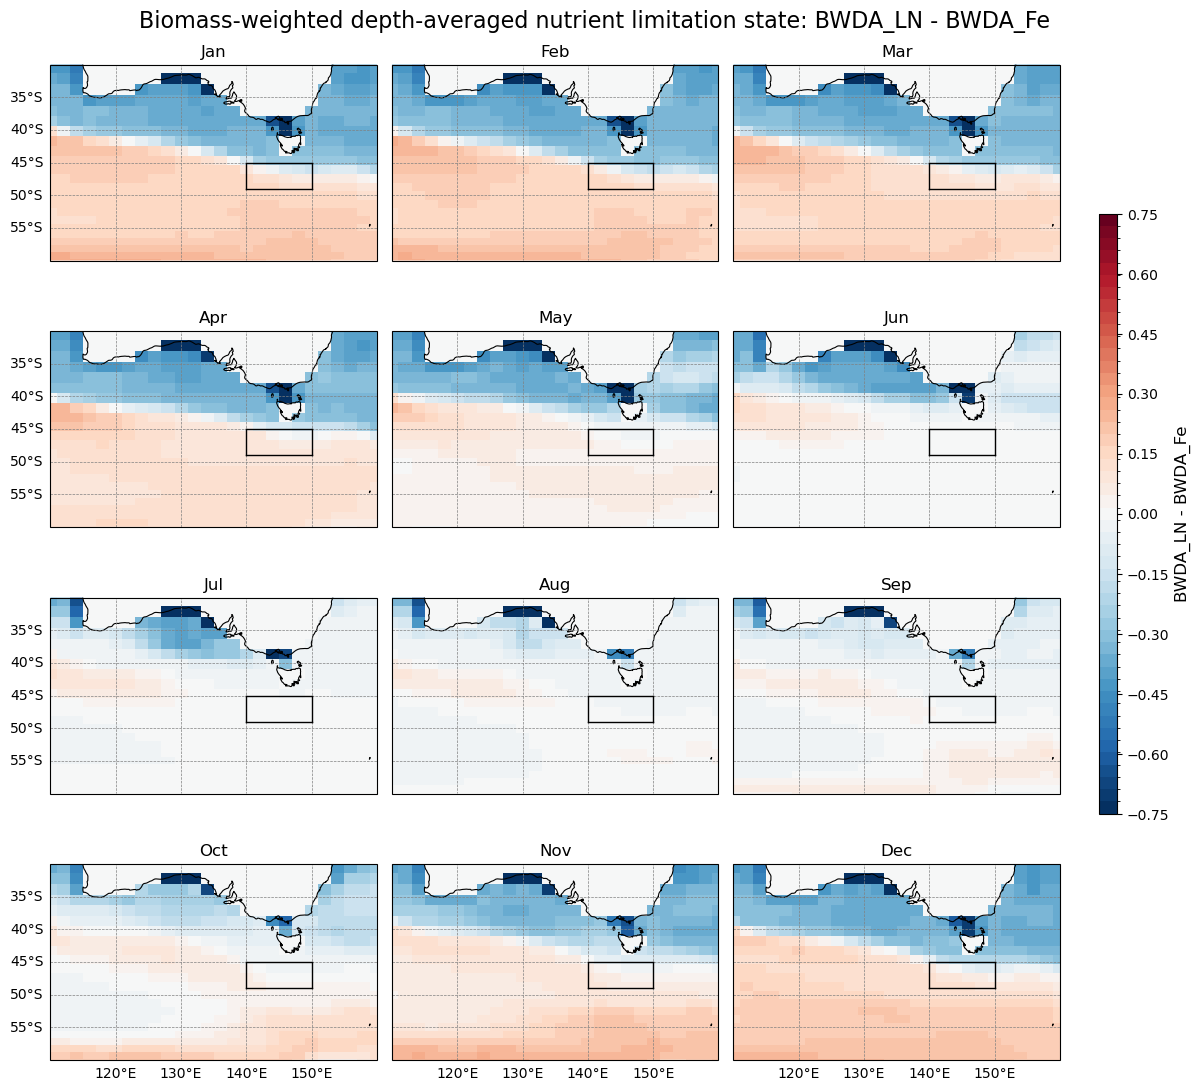

In [9]:
from matplotlib.colors import BoundaryNorm

nav_lat = trc_t['nav_lat']
nav_lon = trc_t['nav_lon']

#### 
depth = T_full['deptht'] 
depth_thickness_fulldom = xr.DataArray(
    T_full.deptht_bounds[:, 1] - T_full.deptht_bounds[:, 0], 
    dims="deptht", 
    coords={"deptht": T_full.deptht})

bio_inventory_n_fulldom = (trc_t['PHY']*depth_thickness_fulldom).sum(dim = 'deptht')
bio_inventory_d_fulldom = (trc_t['PHY2']*depth_thickness_fulldom).sum(dim = 'deptht')
bio_inventory_p_fulldom = (trc_t['PIC']*depth_thickness_fulldom).sum(dim = 'deptht')
bio_inventory_tot_fulldom = ((trc_t['PHY']+trc_t['PHY2']+trc_t['PIC'])*depth_thickness_fulldom).sum(dim = 'deptht')

bwda_total_LN_fulldom = ((((diad_t['LNN'] * trc_t['PHY']) + (diad_t['LDN'] * trc_t['PHY2'] ) + (diad_t['LPN']*trc_t['PIC'])) * depth_thickness_fulldom)/bio_inventory_tot_fulldom).sum(dim='deptht') 

bwda_total_LFe_fulldom = ((((diad_t['LNFe'] * trc_t['PHY']) + (diad_t['LDFe'] * trc_t['PHY2']) + (diad_t['LPFe'] * trc_t['PIC'])) * depth_thickness_fulldom)/bio_inventory_tot_fulldom).sum(dim='deptht') 

# 1. Subset data to between 1975 and 2023
bwda_LN_sel = bwda_total_LN_fulldom.sel(time_counter=slice('1975-01-01', '2023-12-31'))
bwda_Fe_sel = bwda_total_LFe_fulldom.sel(time_counter=slice('1975-01-01', '2023-12-31'))
diff = bwda_LN_sel - bwda_Fe_sel
monthly_diff = diff.groupby('time_counter.month').mean('time_counter')


#### PLot ## 
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# Adjust longitudes to ensure correct mapping
nav_lon_adjusted = np.where(nav_lon < 0, nav_lon + 360, nav_lon)

# White box region
region_lat = [-49, -45]
region_lon = [140, 150]

# Generate points for the white box edges
lons_top = np.linspace(region_lon[0], region_lon[1], 100)
lons_bottom = np.linspace(region_lon[0], region_lon[1], 100)
lats_left = np.linspace(region_lat[0], region_lat[1], 100)
lats_right = np.linspace(region_lat[0], region_lat[1], 100)

# 4. Setup figure and plot loop
fig, axs = plt.subplots(4, 3, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

# Set colormap and levels
cmap = cm.get_cmap('RdBu_r')
levels = np.linspace(-0.75, 0.75, 50)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

# Loop through each month and plot
for month in range(1, 13):
    ax = axs[month - 1]

    ax.set_extent([110, 160, -60, -30], ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', linewidth=0.5)
    gl.xlocator = mticker.FixedLocator(range(100, 160, 10))
    gl.ylocator = mticker.FixedLocator(range(-60, -30, 5))
    gl.top_labels = False
    gl.bottom_labels = month > 9
    gl.left_labels = month % 3 == 1
    gl.right_labels = False

    # Plot pcolormesh
    mesh = ax.pcolormesh(
        nav_lon_adjusted, nav_lat, monthly_diff.sel(month=month),
        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm
    )

    # White overlay box
    ax.plot(lons_top, np.full_like(lons_top, region_lat[1]), transform=ccrs.PlateCarree(), color='k', linewidth=1)
    ax.plot(lons_bottom, np.full_like(lons_bottom, region_lat[0]), transform=ccrs.PlateCarree(), color='k', linewidth=1)
    ax.plot(np.full_like(lats_left, region_lon[0]), lats_left, transform=ccrs.PlateCarree(), color='k', linewidth=1)
    ax.plot(np.full_like(lats_right, region_lon[1]), lats_right, transform=ccrs.PlateCarree(), color='k', linewidth=1)

    # Title
    ax.set_title(month_names[month - 1], fontsize=12)

# Colorbar (shared)
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])  # [left, bottom, width, height]
cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='vertical')
cbar.set_label("BWDA_LN - BWDA_Fe", fontsize=12)
ticks = np.arange(-0.75, 0.76, 0.15)
cbar.set_ticks(ticks)

plt.suptitle("Biomass-weighted depth-averaged nutrient limitation state: BWDA_LN - BWDA_Fe", fontsize=16, y=0.92)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Leave space for colorbar and title
plt.show()

# Figure 3: 
PISCES-Quota-Fe Climatological overview

## Pre-process MLD and SST

In [10]:
# MLD
mld_clim_avg = mld.weighted(area).mean(dim = ['y', 'x']).groupby('time_counter.month').mean(dim=['time_counter'])
mld_clim_std = mld.weighted(area).mean(dim = ['y', 'x']).groupby('time_counter.month').std(dim=['time_counter'])

# SST
sst_clim_avg = sst.weighted(area).mean(dim = ['y', 'x']).groupby('time_counter.month').mean(dim=['time_counter'])
sst_clim_std = sst.weighted(area).mean(dim = ['y', 'x']).groupby('time_counter.month').std(dim=['time_counter'])

# Convert to numpy arrays and circularly shift arrays to start from July and end in June
months = np.arange(1, 13)
shift = 6  # Number of months to shift
mld_values_shifted = np.roll(mld_clim_avg.values, -shift)
mld_std_values_shifted = np.roll(mld_clim_std.values, -shift)

sst_values_shifted = np.roll(sst_clim_avg.values, -shift)
sst_std_values_shifted = np.roll(sst_clim_std.values, -shift)

## Pre-process and derive mean subtropical front position (STF)

Calculate STF based on isothermal definition of Orsi et al. (1995): 11 degree isotherm at 100m

In [11]:
# Define the latitude and longitude bounds for STF subset
min_lat = -50
max_lat = -40
min_lon = 125
max_lon = 155

# Extract the subset of data within the specified bounds
T_STF_subset = T_full.where(
    (T_full.nav_lat >= min_lat) & (T_full.nav_lat <= max_lat) & 
    (T_full.nav_lon >= min_lon) & (T_full.nav_lon <= max_lon) & 
    (T_full.time_counter.dt.year.isin(subsetting_years)),
    drop=True)

# Get temperature at 95 and 105 m (deptht indices 8 and 9) average to get 100 m thetao. 
theta_95_and_105 = T_STF_subset['thetao'].sel(deptht=T_STF_subset.deptht[[8, 9]])
theta_mean_flat = theta_95_and_105.mean(dim='deptht')

# Get 2D navigation and time coords
time_coords = T_STF_subset['time_counter']
time_coords = time_coords[[t.year >= 1975 for t in time_coords.values]]
nav_lat = T_STF_subset['nav_lat']
nav_lon = T_STF_subset['nav_lon']

# Extract 1D longitude
nav_lon_1d = nav_lon[0, :]  # Longitude for all x-values

# Define longitude ranges: This is the range to average STF latitudes across
lon_ranges = {"140-150 E": (139.9, 150)}  

# Target thetao contour level: this is the isothermal contour representing STF location.
target_level = 11

# Initialize the masked array for theta_mean_flat. Masking is used to remove land adjacent cells. 
theta_mean_flat_masked = np.empty_like(theta_mean_flat)
threshold = 0.0  # Threshold for masking

# Iterate over time steps to apply masking, this masks out generatation of the STF 
for t in range(theta_mean_flat.shape[2]):  # Assuming the third dimension is time
    frame_data = theta_mean_flat[..., t]  # Extract 2D frame for the current time step

    # Identify the '0' mask
    mask = frame_data == threshold

    # Pad the mask to handle edge cases
    padded_mask = np.pad(mask, pad_width=1, mode='constant', constant_values=False)

    # Compute the spatial adjacency mask (correct alignment of neighbors)
    mask_adj = (
        mask |  # Include original mask locations
        padded_mask[1:-1, :-2] |  # Left neighbor
        padded_mask[1:-1, 2:]  |  # Right neighbor
        padded_mask[:-2, 1:-1] |  # Top neighbor
        padded_mask[2:, 1:-1]     # Bottom neighbor
    )

    # Apply the mask to the current frame
    theta_mean_flat_masked[..., t] = np.where(mask_adj, np.nan, frame_data)

# Initialize dictionary for mean latitudes and seasonal means
mean_stf_latitudes = {}
seasonal_stf_means = {}
annual_max_stfs = {}
annual_min_stfs = {}

# Convert cftime objects to strings and then to pandas datetime
time_coords_str = time_coords.values.astype(str)
time_coords_pd = pd.to_datetime(time_coords_str)
time_years = time_coords_pd.year

# Loop through longitude ranges
for label, (lon_min, lon_max) in lon_ranges.items():
    
    # Mask the x-dimension (longitude)
    lon_mask = (nav_lon_1d >= lon_min) & (nav_lon_1d <= lon_max)
    
    # Apply longitude mask to the **masked theta_mean_flat** and nav_lat
    masked_theta = theta_mean_flat_masked[:, lon_mask, :]  # Subset longitude range
    masked_lats = nav_lat[:, lon_mask]  # Corresponding latitudes
    
    # Initialize list to store mean latitudes over time
    mean_lat_time = []
    crossing_lat_records = []
    
    total_steps = masked_theta.shape[2]
    
    # Loop over time steps
    for t in range(masked_theta.shape[2]):  # Loop over time steps
        frame = masked_theta[..., t]  # 2D masked theta data for current time step
        lats = masked_lats  # Corresponding latitudes
        
        crossing_lats = []  # Store latitudes where contour level is crossed
        
        # Loop over each column (longitude) in the masked data
        for x in range(frame.shape[1]):
            col_theta = frame[:, x]  # Theta values along latitude for current longitude
            col_lat = lats[:, x]     # Latitude values along the same column
            
            # Find where contour level is crossed (adjacent grid points)
            for y in range(len(col_theta) - 1):
                t1, t2 = col_theta[y], col_theta[y + 1]
                
                if np.isnan(t1) or np.isnan(t2):  # Skip NaN values
                    continue
                
                if (t1 - target_level) * (t2 - target_level) < 0:  # Contour is crossed
                    # Linear interpolation to approximate crossing latitude
                    frac = (target_level - t1) / (t2 - t1)  # Fraction between points
                    lat_interp = col_lat[y] + frac * (col_lat[y + 1] - col_lat[y])
                    crossing_lats.append(lat_interp)
        
        # Compute the mean latitude for this time step
        if crossing_lats:
            # Save each crossing latitude along with time and longitude
            for lat in crossing_lats:
                crossing_lat_records.append({
                    'time': time_coords_pd[t],
                    'longitude': nav_lon_1d[lon_mask][x],
                    'latitude': lat,
                    'range_label': label
                })
            mean_lat_time.append(np.mean(crossing_lats))
        else:
            mean_lat_time.append(np.nan)  # No contour crossings for this time step
    
    # Print progress percentage
        progress = (t + 1) / total_steps * 100
        sys.stdout.write(f"\rProcessing {label}: {progress:.2f}% complete")
        sys.stdout.flush()
    
    # Store mean latitudes for this longitude range
    mean_stf_latitudes[label] = np.array(mean_lat_time)
    
    # Calculate seasonal mean (July to June), where July-Dec is the year and Jan-June the previous year, since the time series starts in Jan. ie. the first 6 months is season_1957 (not 1958)
    df = pd.DataFrame({
        'time': time_coords_pd,
        'mean_lat': mean_lat_time
    }).set_index('time')
    df['season_year'] = np.where(df.index.month >= 7, df.index.year, df.index.year - 1)
    
    '''
    # Compute seasonal mean latitudes
    seasonal_mean = df.groupby('season_year')['mean_lat'].mean()
    seasonal_stf_means[label] = seasonal_mean
    
    # Compute maximum annual STF position (north position)
    annual_max_stf = df.groupby(time_coords_pd.year)['mean_lat'].max()
    annual_max_stfs[label] = annual_max_stf
    
    # Compute minimum annual STF position (south)
    annual_min_stf = df.groupby(time_coords_pd.year)['mean_lat'].min()
    annual_min_stfs[label] = annual_min_stf
'''
print(f"\nFinished masking and calculating temperature-derived STF at 100m, longitude range: {label}")

Processing 140-150 E: 100.00% complete
Finished masking and calculating temperature-derived STF at 100m, longitude range: 140-150 E


## Pre-process primary production climatology

### Calculate biomass inventory

In [12]:
# Sum over water column to get total biomass inventory
bio_inventory_n = (phyn_conc*depth_thickness).sum(dim = 'deptht')
bio_inventory_d = (phyd_conc*depth_thickness).sum(dim = 'deptht')
bio_inventory_p = (phyp_conc*depth_thickness).sum(dim = 'deptht')
bio_inventory_tot = ((phyn_conc+phyd_conc+phyp_conc)*depth_thickness).sum(dim = 'deptht')

### Primary Production, BWDA

In [13]:
seconds_per_day = 60*60*24

# Depth integrated
depsum_ppphyn = (ppphyn*depth_thickness).sum(dim='deptht') 
depsum_ppphyd = (ppphyd*depth_thickness).sum(dim='deptht') 
depsum_ppphyp = (ppphyp*depth_thickness).sum(dim='deptht') 
depsum_pp_tot = ((ppphyn+ppphyd+ppphyp)*depth_thickness).sum(dim='deptht') 

depsum_ppphyn_clim_avg = depsum_ppphyn.weighted(area).mean(dim = ['y', 'x']).groupby('time_counter.month').mean(dim=['time_counter'])
depsum_ppphyd_clim_avg = depsum_ppphyd.weighted(area).mean(dim = ['y', 'x']).groupby('time_counter.month').mean(dim=['time_counter'])
depsum_ppphyp_clim_avg = depsum_ppphyp.weighted(area).mean(dim = ['y', 'x']).groupby('time_counter.month').mean(dim=['time_counter'])
depsum_pp_tot_clim_avg = depsum_pp_tot.weighted(area).mean(dim = ['y', 'x']).groupby('time_counter.month').mean(dim=['time_counter'])

depsum_ppphyn_clim_std = depsum_ppphyn.weighted(area).mean(dim = ['y', 'x']).groupby('time_counter.month').std(dim=['time_counter'])
depsum_ppphyd_clim_std = depsum_ppphyd.weighted(area).mean(dim = ['y', 'x']).groupby('time_counter.month').std(dim=['time_counter'])
depsum_ppphyp_clim_std = depsum_ppphyp.weighted(area).mean(dim = ['y', 'x']).groupby('time_counter.month').std(dim=['time_counter'])
depsum_pp_tot_clim_std = depsum_pp_tot.weighted(area).mean(dim = ['y', 'x']).groupby('time_counter.month').std(dim=['time_counter'])

# Circularly shift data arrays to start from July and end in June
shift = 6  # Number of months to shift

depsum_ppphyn_clim_avg_shifted = np.roll(depsum_ppphyn_clim_avg, -shift)*seconds_per_day*1000
depsum_ppphyn_clim_std_shifted = np.roll(depsum_ppphyn_clim_std, -shift)*seconds_per_day*1000
depsum_ppphyd_clim_avg_shifted = np.roll(depsum_ppphyd_clim_avg, -shift)*seconds_per_day*1000
depsum_ppphyd_clim_std_shifted = np.roll(depsum_ppphyd_clim_std, -shift)*seconds_per_day*1000
depsum_ppphyp_clim_avg_shifted = np.roll(depsum_ppphyp_clim_avg, -shift)*seconds_per_day*1000
depsum_ppphyp_clim_std_shifted = np.roll(depsum_ppphyp_clim_std, -shift)*seconds_per_day*1000
depsum_pp_tot_clim_avg_shifted = np.roll(depsum_pp_tot_clim_avg, -shift)*seconds_per_day*1000
depsum_pp_tot_clim_std_shifted = np.roll(depsum_pp_tot_clim_std, -shift)*seconds_per_day*1000

## Plot Figure 3a -c: Model NPP climatological overview
Goes with Taylor diagram (Figure 3d)

In [14]:
# pre-calculate STF lats
months = np.array([t.month for t in time_coords.values])
# Initialize dictionaries for monthly climatology and standard deviation
monthly_stf_climatology = {}
monthly_stf_clim_std = {}

# Calculate monthly climatology and standard deviation
for label, mean_lat_time in mean_stf_latitudes.items():
    monthly_means = np.full(12, np.nan)
    monthly_stds = np.full(12, np.nan)
    
    for month in range(1, 13):
        month_mask = (months == month)
        monthly_data = mean_lat_time[month_mask]
        
        monthly_means[month - 1] = np.nanmean(monthly_data)
        monthly_stds[month - 1] = np.nanstd(monthly_data)
    
    monthly_stf_climatology[label] = monthly_means
    monthly_stf_clim_std[label] = monthly_stds
    
# Loop through longitude windows to plot means and std shading
label = '140-150 E'

# STF isothermal
mean_vals_theta = monthly_stf_climatology[label]
std_vals_theta = monthly_stf_clim_std[label]
    
shifted_means_theta = np.roll(mean_vals_theta, -6)
shifted_stds_theta = np.roll(std_vals_theta, -6)

/var/folders/dk/4pyn7w4102bfzscb0m9606zw0000gn/T/ipykernel_9606/670971366.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


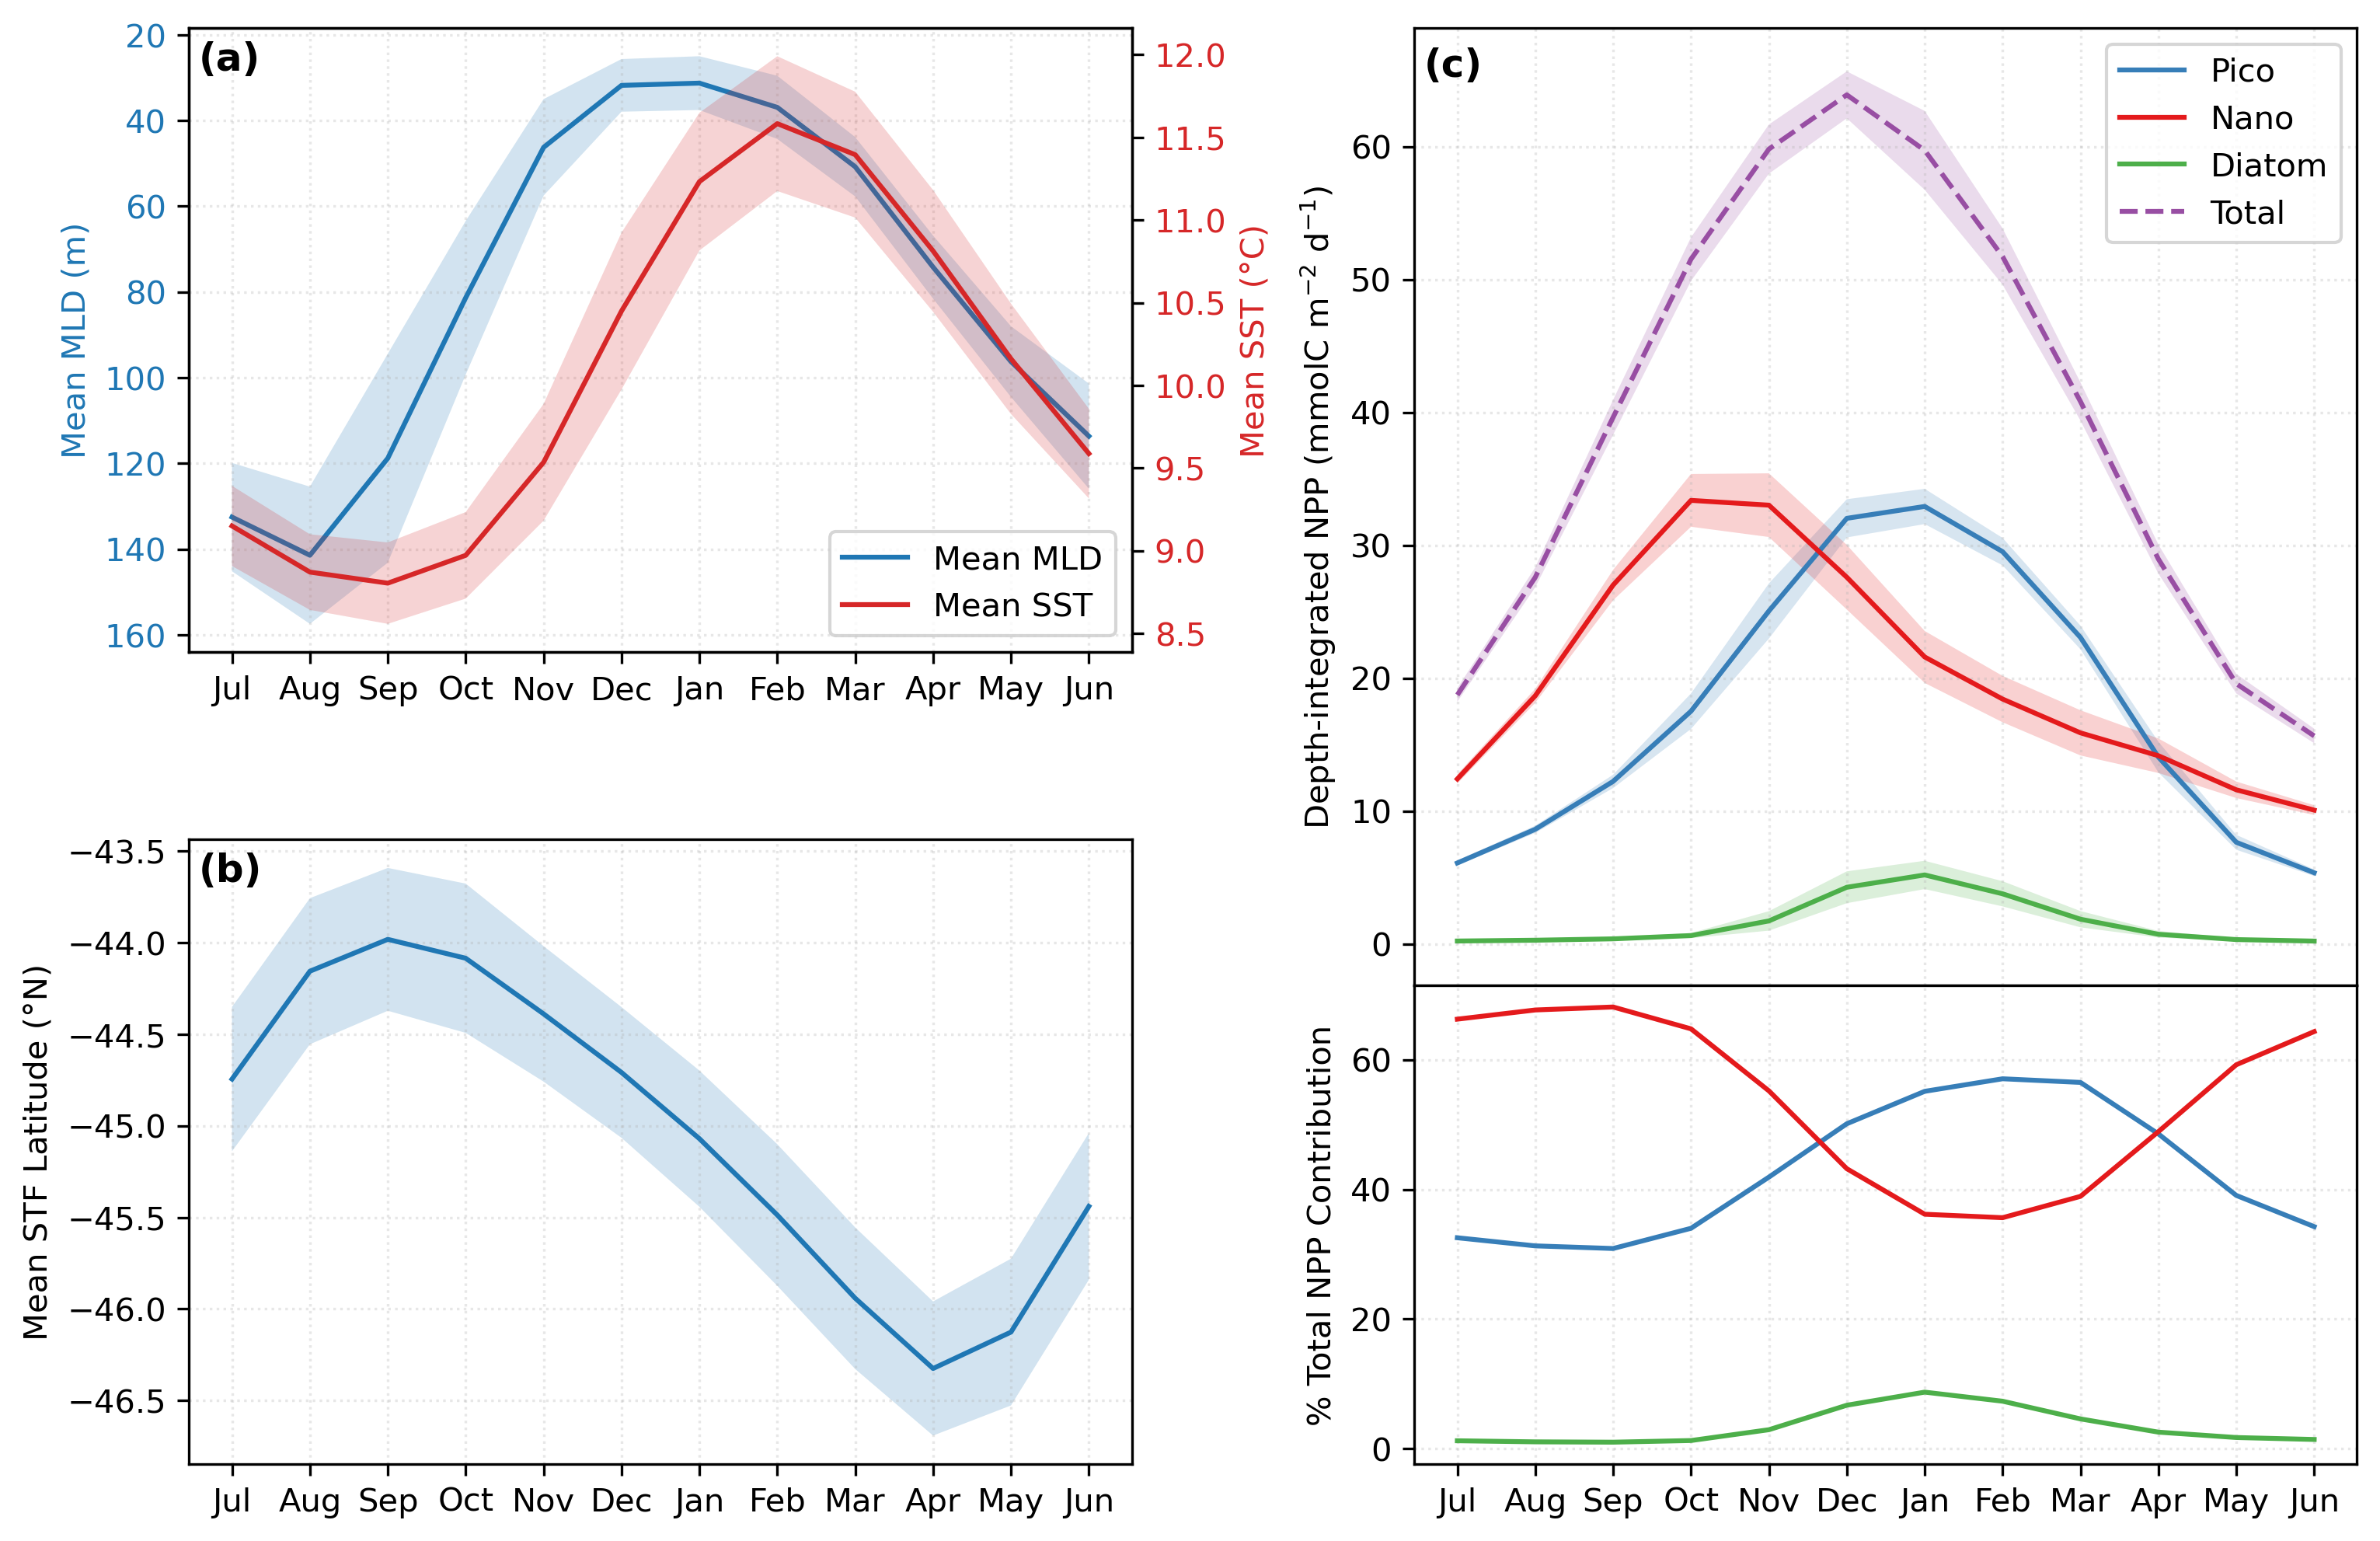

In [16]:
import matplotlib.gridspec as gridspec

colors = plt.cm.Set1.colors
color_pico = colors[1]
color_nano = colors[0]
color_diatom = colors[2]
color_total = colors[3]

fig = plt.figure(figsize=(12, 8), dpi=300)

# Main GridSpec: 2 rows, 2 columns (left + right)
gs_main = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], wspace=0.3, hspace=0.3)

# Left side axes (SST/MLD top, STF bottom)
ax_sst_mld = fig.add_subplot(gs_main[0, 0])
ax_stf = fig.add_subplot(gs_main[1, 0])

# Nested GridSpec for right side (2 rows stacked, zero vertical spacing)
gs_right = gridspec.GridSpecFromSubplotSpec(
    2, 1, subplot_spec=gs_main[:, 1], hspace=0, height_ratios=[2, 1]
)
# Right top panel: depth-integrated PP
ax_npp = fig.add_subplot(gs_right[0])

# Right bottom panel: % contribution
ax_pct = fig.add_subplot(gs_right[1], sharex=ax_npp)

# === Plotting Left side ===
# SST/MLD (top-left)
# Define months and corresponding labels for the shifted range
months_shifted = np.arange(1, 13)  # Keep month indices 1-12
month_labels = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']

ax_sst_mld.fill_between(months_shifted, 
                        mld_values_shifted - mld_std_values_shifted, 
                        mld_values_shifted + mld_std_values_shifted, 
                        color='tab:blue', alpha=0.2, edgecolor='none')
ax_sst_mld.plot(months_shifted, mld_values_shifted, '-', color='tab:blue', label='Mean MLD')
ax_sst_mld.set_ylabel('Mean MLD (m)', color='tab:blue')
ax_sst_mld.invert_yaxis()
ax_sst_mld.tick_params(axis='y', labelcolor='tab:blue')
ax_sst_mld.set_xticks(months_shifted)
ax_sst_mld.set_xticklabels(month_labels)
ax_sst_mld.grid(alpha = 0.3, linestyle = ':')

ax_sst_mldb = ax_sst_mld.twinx()
ax_sst_mldb.fill_between(months_shifted, 
                         sst_values_shifted - sst_std_values_shifted, 
                         sst_values_shifted + sst_std_values_shifted, 
                         color='tab:red', alpha=0.2, edgecolor='none')
ax_sst_mldb.plot(months_shifted, sst_values_shifted, '-', color='tab:red', label='Mean SST')
ax_sst_mldb.set_ylabel('Mean SST (°C)', color='tab:red')
ax_sst_mldb.tick_params(axis='y', labelcolor='tab:red')

lines_1, labels_1 = ax_sst_mld.get_legend_handles_labels()
lines_2, labels_2 = ax_sst_mldb.get_legend_handles_labels()
ax_sst_mld.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower right')

# STF Latitude (bottom-left)
ax_stf.fill_between(months_shifted,
                    shifted_means_theta - shifted_stds_theta,
                    shifted_means_theta + shifted_stds_theta,
                    alpha=0.2)
ax_stf.plot(months_shifted, shifted_means_theta, label=f"{label} Temp = 11°C")
ax_stf.set_ylabel("Mean STF Latitude (°N)")
ax_stf.set_xticks(months_shifted) 
ax_stf.set_xticklabels(month_labels)
ax_stf.grid(alpha = 0.3, linestyle = ':')

# === Plotting Right side ===
# Depth-integrated PP (top-right)
ax_npp.plot(months_shifted, depsum_ppphyp_clim_avg_shifted, label='Pico', color=color_pico)
ax_npp.fill_between(months_shifted,
                    depsum_ppphyp_clim_avg_shifted - depsum_ppphyp_clim_std_shifted,
                    depsum_ppphyp_clim_avg_shifted + depsum_ppphyp_clim_std_shifted,
                    color=color_pico, alpha=0.2, edgecolor='none')

ax_npp.plot(months_shifted, depsum_ppphyn_clim_avg_shifted, label='Nano', color=color_nano)
ax_npp.fill_between(months_shifted,
                    depsum_ppphyn_clim_avg_shifted - depsum_ppphyn_clim_std_shifted,
                    depsum_ppphyn_clim_avg_shifted + depsum_ppphyn_clim_std_shifted,
                    color=color_nano, alpha=0.2, edgecolor='none')

ax_npp.plot(months_shifted, depsum_ppphyd_clim_avg_shifted, label='Diatom', color=color_diatom)
ax_npp.fill_between(months_shifted,
                    depsum_ppphyd_clim_avg_shifted - depsum_ppphyd_clim_std_shifted,
                    depsum_ppphyd_clim_avg_shifted + depsum_ppphyd_clim_std_shifted,
                    color=color_diatom, alpha=0.2, edgecolor='none')

ax_npp.plot(months_shifted, depsum_pp_tot_clim_avg_shifted, label='Total', color=color_total, linestyle='--')
ax_npp.fill_between(months_shifted,
                    depsum_pp_tot_clim_avg_shifted - depsum_pp_tot_clim_std_shifted,
                    depsum_pp_tot_clim_avg_shifted + depsum_pp_tot_clim_std_shifted,
                    color=color_total, alpha=0.2, edgecolor='none')

ax_npp.set_ylabel('Depth-integrated NPP (mmolC m$^{-2}$ d$^{-1}$)')
ax_npp.grid(alpha = 0.3, linestyle = ':')
ax_npp.legend(loc='upper right')

# % contribution (bottom-right)
ax_pct.plot(months_shifted, (depsum_ppphyp_clim_avg_shifted / depsum_pp_tot_clim_avg_shifted) * 100,
            label='Pico %', color=color_pico)
ax_pct.plot(months_shifted, (depsum_ppphyn_clim_avg_shifted / depsum_pp_tot_clim_avg_shifted) * 100,
            label='Nano %', color=color_nano)
ax_pct.plot(months_shifted, (depsum_ppphyd_clim_avg_shifted / depsum_pp_tot_clim_avg_shifted) * 100,
            label='Diatom %', color=color_diatom)

ax_pct.set_ylabel('% Total NPP Contribution')
ax_pct.set_xticks(months_shifted)
ax_pct.set_xticklabels(month_labels)
ax_pct.grid(alpha = 0.3, linestyle = ':')

# Panel labels
panel_labels = ['a', 'b', 'c']
axes = [ax_sst_mld, ax_stf, ax_npp]

for label, ax in zip(panel_labels, axes):
    ax.text(
        0.01, 0.98, f'({label})',
        transform=ax.transAxes,
        fontsize=12,
        fontweight='bold',
        va='top',
        ha='left'
    )

# Remove x tick labels from ax_npp (top-right) to avoid clutter
plt.setp(ax_npp.get_xticklabels(), visible=False)

plt.tight_layout()
plt.show()

## Figure 3d: Taylor diagram

In [17]:
# Taylor diagram packages: 
import geocat.viz as gv
import geocat.datafiles as gdf

### Pre-process observational data to regional climatology. 

#### STF, MLD, SST from ARMOR-3D product

In [18]:
# Check path: 
tsmld_nc = xr.open_dataset('CMS ARMOR 3D TSMLD Product/ARMOR_3D_L4_TSMLD_Monthly_REP_120E_160E_50S_40S_0_1000m.nc')

# Extract month and year from the datetime64 'time' coordinate
months = tsmld_nc['time'].dt.month
years = tsmld_nc['time'].dt.year

# Apply July-year logic
july_year = xr.DataArray(
    years.where(months >= 7, years - 1),
    coords={"time": tsmld_nc.time},
    dims="time",
    name="july_year"
)

# Assign as a coordinate to the dataset
tsmld_nc = tsmld_nc.assign_coords(july_year=july_year)
tsmld_nc_subset = tsmld_nc.sel(latitude = slice(-49, -45), longitude = slice(140, 150), time=slice('1998-01-01', None))
tsmld_nc.close()

#### Derive STF position for spatial subset

In [19]:
subset_latmin, subset_latmax, subset_lonmin, subset_lonmax = min(tsmld_nc_subset['latitude'].values), max(tsmld_nc_subset['latitude'].values),min(tsmld_nc_subset['longitude'].values), max(tsmld_nc_subset['longitude'].values)
print(f'Spatial subset extent: {subset_latmin, subset_latmax, subset_lonmin, subset_lonmax }')

# Extract varaibles (temperature, lat, lon, time) at depth level
temp_100 = tsmld_nc_subset.sel(depth=100)

temp = temp_100['to']
lat = temp_100['latitude']
lon = temp_100['longitude']
time = temp_100['time']

# Get unique year-month pairs from the time dimension
year_months = np.array([(t.dt.year.item(), t.dt.month.item()) for t in time])
unique_years = np.unique([ym[0] for ym in year_months])

# DataFrame to store results
df_list = []

# Loop over each unique year
for year in unique_years:
    print(f"Processing {year}...")

    # Get all unique months in this year
    months_in_year = np.unique([m for (y, m) in year_months if y == year])

    for month in months_in_year:
        # Create mask and subset using .where(..., drop=True)
        mask = (time.dt.year == year) & (time.dt.month == month)
        temp_month = temp_100.where(mask, drop=True)

        if temp_month.time.size == 0:
            print(f"No data for {year}-{month:02d}, skipping...")
            continue

        # Store longitude-latitude pairs for all time steps in this month
        lon_list = []
        lat_list = []

        # Keep track of timesteps with no contours
        no_contour_timesteps = []

        # Extract 11°C contour data
        for i in range(len(temp_month.time)):
            try:
                cs = plt.contour(lon, lat, temp_month['to'].isel(time=i), levels=[11.0])
                
                # Debug: show number of segments per level
#                print(f"time {i}: allsegs = {[len(segs) for segs in cs.allsegs]}")

                found = False
                for segs in cs.allsegs:        # each contour level
                    for seg in segs:           # each continuous line segment
                        if seg.shape[0] > 1:   # only consider non-degenerate paths
                            lon_list.append(seg[:, 0])
                            lat_list.append(seg[:, 1])
                            found = True

                if not found:
                    no_contour_timesteps.append(i)

                plt.close()

            except ValueError:
                print(f"Skipping time index {i} for {year}-{month:02d}: No valid contour found")
                no_contour_timesteps.append(i)

        if len(lon_list) == 0 or len(lat_list) == 0:
#            print(f"No contours detected for {year}-{month:02d}, skipping...")
#            print(f"Timesteps with no contours: {no_contour_timesteps}")
            continue
        else:
            if no_contour_timesteps:
                print(f"Timesteps with no contours for {year}-{month:02d}: {no_contour_timesteps}")

        # Process contour points
        all_lons = np.concatenate(lon_list)
        all_lats = np.concatenate(lat_list)

        sort_idx = np.argsort(all_lons)
        sorted_lons = all_lons[sort_idx]
        sorted_lats = all_lats[sort_idx]

        unique_lons = np.linspace(sorted_lons.min(), sorted_lons.max(), num=30)  # Stf latitudes are interpolated onto a regular long grid to smooth the contours. 
        mean_lats = []

        for lon_val in unique_lons:
            bin_mask = np.abs(sorted_lons - lon_val) < 0.5
            if np.any(bin_mask):
                mean_lats.append(np.mean(sorted_lats[bin_mask]))
            else:
                mean_lats.append(np.nan)

        mean_lats = np.array(mean_lats)

        # Interpolate missing values
        valid = ~np.isnan(mean_lats)
        if np.any(valid):
            interp_mean = interp1d(unique_lons[valid], mean_lats[valid], kind='linear', fill_value='extrapolate')
            mean_lats = interp_mean(unique_lons)

        df_month = pd.DataFrame({
            'year': year,
            'month': month,
            'longitude': unique_lons,
            'mean_latitude': mean_lats
        })

        df_list.append(df_month)


# Concatenate results
df_monthly_stf = pd.concat(df_list, ignore_index=True)

print("Dataframe of monthly STF latitudes at every longitude compiled: df_monthly_stf")

Spatial subset extent: (np.float32(-48.875), np.float32(-45.125), np.float32(140.125), np.float32(149.875))
Processing 1998...
Processing 1999...
Processing 2000...
Processing 2001...
Processing 2002...
Processing 2003...
Processing 2004...
Processing 2005...
Processing 2006...
Processing 2007...
Processing 2008...
Processing 2009...
Processing 2010...
Processing 2011...
Processing 2012...
Processing 2013...
Processing 2014...
Processing 2015...
Processing 2016...
Processing 2017...
Processing 2018...
Processing 2019...
Processing 2020...
Processing 2021...
Processing 2022...
Dataframe of monthly STF latitudes at every longitude compiled: df_monthly_stf


In [20]:
### STF: stored in mean_stf_latitudes
mean_stf_140_150 = mean_stf_latitudes['140-150 E']

time_counter = subset_T.time_counter.values
month = subset_T.time_counter.dt.month.values
july_year = subset_T.july_year.values  # assuming you’ve already added this coord

# Build the DataFrame
mean_stf_df = pd.DataFrame({
    "mean_stf": mean_stf_140_150,
    "time_counter": time_counter,
    "month": month,
    "july_year": july_year
})

#### Hadley MLD product

In [21]:
hadley_mld_nc = xr.open_dataset("/Users/christoph/Library/CloudStorage/OneDrive-UniversityofTasmania/Research/PhD Project/Theme 3 Model Obs/Hadley MLD Product/HADLEY_EN422_MLD_8D_25KM_1998_2024.nc")

# Extract month and year from the datetime64 'time' coordinate
months = hadley_mld_nc['time'].dt.month
years = hadley_mld_nc['time'].dt.year

# Apply July-year logic to centre years on January later on. 
july_year = xr.DataArray(
    years.where(months >= 7, years - 1),
    coords={"time": hadley_mld_nc.time},
    dims="time",
    name="july_year"
)

# Assign as a coordinate to the dataset
hadley_mld_nc = hadley_mld_nc.assign_coords(july_year=july_year)

hadley_mld_nc_subset = hadley_mld_nc.sel(lat = slice(-49, -45), lon = slice(140, 150), time=slice('1998-01-01', '2022-12-31'))

# rename lat and lon to latitude and longitude for consistency with boostrapping algortithms
hadley_mld_nc_subset = hadley_mld_nc_subset.rename({'lat': 'latitude', 'lon': 'longitude'})

# resample to monthly temporal resolution for bootstrapping later
hadley_mld_nc_subset_monthly = hadley_mld_nc_subset.resample(time='1M').mean()

# reassign july-year which was removed in monthly resampling
# Extract month and year from the datetime64 'time' coordinate
months = hadley_mld_nc_subset_monthly['time'].dt.month
years = hadley_mld_nc_subset_monthly['time'].dt.year

# Apply July-year logic to centre years on January later on. 
july_year = xr.DataArray(
    years.where(months >= 7, years - 1),
    coords={"time": hadley_mld_nc_subset_monthly.time},
    dims="time",
    name="july_year"
)

hadley_mld_nc_subset_monthly = hadley_mld_nc_subset_monthly.assign_coords(july_year=july_year, month = months)

# Define weights based on cosine of latitude
weights_hadley_mld = np.cos(np.deg2rad(hadley_mld_nc_subset.latitude))
weights_hadley_mld.name = "weights_hadley_mld"

hadley_mld_spatial_avg = hadley_mld_nc_subset.weighted(weights_hadley_mld).mean(dim=["latitude", "longitude"])

hadley_mld_temporal_avg_clim = hadley_mld_spatial_avg.groupby("time.month").mean(dim=["time"])
hadley_mld_temporal_std_clim = hadley_mld_spatial_avg.groupby("time.month").std(dim=["time"])

hadley_mld_climatology = xr.Dataset({
    "month": hadley_mld_temporal_avg_clim['month'],
    "mean_mld": hadley_mld_temporal_avg_clim['mld'],
    "std_mld": hadley_mld_temporal_std_clim['mld']
})

/Users/christoph/opt/anaconda3/envs/Analysis/lib/python3.10/site-packages/xarray/groupers.py:498: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [22]:
# Calculate climatological surface temp, salinity and MLD including spatial weighting. 
# Define weights based on cosine of latitude
weights_mld_sst = np.cos(np.deg2rad(tsmld_nc_subset.latitude))
weights_mld_sst.name = "weights_mld_sst"

# calculate climatological surface temp, salinity and MLD
tsmld_spatial_avg = tsmld_nc_subset.sel(depth = 0).weighted(weights_mld_sst).mean(dim=["latitude", "longitude"])

tsmld_temporal_avg_clim = tsmld_spatial_avg.groupby("time.month").mean(dim=["time"])
tsmld_temporal_std_clim = tsmld_spatial_avg.groupby("time.month").std(dim=["time"])

tsmld_climatology = xr.Dataset({
    "month": tsmld_temporal_avg_clim['month'],
    "mean_mld": tsmld_temporal_avg_clim['mlotst'] ,
    "std_mld": tsmld_temporal_std_clim['mlotst'],
    "mean_temp": tsmld_temporal_avg_clim['to'],
    "std_temp": tsmld_temporal_std_clim['to'],
    "mean_sal": tsmld_temporal_avg_clim['so'],
    "std_sal": tsmld_temporal_std_clim['so']
})

# Dropdepth coord
tsmld_climatology = tsmld_climatology.drop_vars('depth')

#Climatological STF in longitude range 140 - 150E
stf_climatology = df_monthly_stf.groupby(['month', 'year']).mean().groupby('month').mean()
stf_climatology = stf_climatology.reset_index()
stf_mean_lat_da = xr.DataArray(
    data=stf_climatology['mean_latitude'].values,
    coords={'month': stf_climatology['month'].values},
    dims='month',
    name='stf_mean_latitude'
)
tsmld_climatology['stf_mean_latitude'] = stf_mean_lat_da

#### NPP from OC-CCI satellite algorithms

In [23]:
minlon, maxlon = 140, 150
minlat, maxlat = -49, -45

NPP_VGPM_OCCCI = xr.open_dataset('OC_CCI_NPP_algorithms/1998_2024_NPP_BEHRENFELD_VGPM_25KM_8D.nc')
NPP_VGPM_OCCCI_subset = NPP_VGPM_OCCCI.sel(lat=slice(minlat, maxlat), lon=slice(minlon, maxlon), time=slice('1997-07-01', "2023-06-30"))
NPP_VGPM_OCCCI.close()
del NPP_VGPM_OCCCI

NPP_eVGPM_OCCCI = xr.open_dataset('OC_CCI_NPP_algorithms/1998_2024_NPP_EPPLEY_VGPM_25KM_8D.nc')
NPP_eVGPM_OCCCI_subset = NPP_eVGPM_OCCCI.sel(lat=slice(minlat, maxlat), lon=slice(minlon, maxlon), time=slice('1997-07-01', "2023-06-30"))
NPP_eVGPM_OCCCI.close()
del NPP_eVGPM_OCCCI

NPP_CAFE_OCCCI = xr.open_dataset('OC_CCI_NPP_algorithms/1998_2024_NPP_SILSBE_CAFE_25KM_8D.nc')
NPP_CAFE_OCCCI_subset = NPP_CAFE_OCCCI.sel(lat=slice(minlat, maxlat), lon=slice(minlon, maxlon), time=slice('1997-07-01', "2023-06-30"))
NPP_CAFE_OCCCI.close()
del NPP_CAFE_OCCCI

NPP_CbPM_OCCCI = xr.open_dataset('OC_CCI_NPP_algorithms/1998_2024_NPP_WESTBERRY_CBPM_25KM_8D.nc')
NPP_CbPM_OCCCI_subset = NPP_CbPM_OCCCI.sel(lat=slice(minlat, maxlat), lon=slice(minlon, maxlon), time=slice('1997-07-01', "2023-06-30"))
NPP_CbPM_OCCCI.close()
del NPP_CbPM_OCCCI

NPP_AbPM_OCCCI = xr.open_dataset('OC_CCI_NPP_algorithms/1998_2024_NPP_LEE_ABPM_25KM_8D.nc')
NPP_AbPM_OCCCI_subset = NPP_AbPM_OCCCI.sel(lat=slice(minlat, maxlat), lon=slice(minlon, maxlon), time=slice('1997-07-01', "2023-06-30"))
NPP_AbPM_OCCCI.close()
del NPP_AbPM_OCCCI

#npp_data_subsets = {NPP_VGPM_OCCCI_subset['Behrenfeld-VGPM'], NPP_eVGPM_OCCCI_subset['Eppley-VGPM'], NPP_CAFE_OCCCI_subset['Silsbe-CAFE'], NPP_CbPM_OCCCI_subset['Westberry-CbPM'], NPP_AbPM_OCCCI_subset['Lee-AbPM']}

print('Subsetting complete, full domains removed from memory')

Subsetting complete, full domains removed from memory


In [24]:
cbpm_climatology = NPP_CbPM_OCCCI_subset['Westberry-CbPM'].mean(dim = ['lat', 'lon']).groupby('time.month').mean(dim = ['time'])

vgpm_climatology = NPP_VGPM_OCCCI_subset['Behrenfeld-VGPM'].mean(dim = ['lat', 'lon']).groupby('time.month').mean(dim = ['time'])

evgpm_climatology = NPP_eVGPM_OCCCI_subset['Eppley-VGPM'].mean(dim = ['lat', 'lon']).groupby('time.month').mean(dim = ['time'])

abpm_climatology = NPP_AbPM_OCCCI_subset['Lee-AbPM'].mean(dim = ['lat', 'lon']).groupby('time.month').mean(dim = ['time'])

cafe_climatology = NPP_CAFE_OCCCI_subset['Silsbe-CAFE'].mean(dim = ['lat', 'lon']).groupby('time.month').mean(dim = ['time'])

npp_climatology = xr.Dataset({
    'cbpm': cbpm_climatology/12.011,
    'vgpm': vgpm_climatology/12.011,
    'evgpm': evgpm_climatology/12.011,
    'abpm': abpm_climatology/12.011,
    'cafe': cafe_climatology/12.011
})

# Merge MLD, SST, STF and NPP observaitonal climatologies. 
observation_climatology = xr.merge([tsmld_climatology, npp_climatology])

Observational climatologies are now stored in a month coordinate xarray Dataset: observation_climatology

### Use existing processed PISCES data 

#### PISCES MLD, SST, STF and NPP

In [25]:
mld_clim_avg = mld.mean(dim = ['y', 'x']).groupby('time_counter.month').mean(dim=['time_counter'])
mld_clim_std = mld.mean(dim = ['y', 'x']).groupby('time_counter.month').std(dim=['time_counter'])

# SST
sst_clim_avg = sst.mean(dim = ['y', 'x']).groupby('time_counter.month').mean(dim=['time_counter'])
sst_clim_std = sst.mean(dim = ['y', 'x']).groupby('time_counter.month').std(dim=['time_counter'])

# PISCES Climatology storage dataframe: 
pisces_climatology = xr.Dataset({
    'mean_mld': mld_clim_avg,
    'std_mld': mld_clim_std,
    'mean_sst': sst_clim_avg,
    'std_sst': sst_clim_std
})

# STF: 
array = monthly_stf_climatology['140-150 E']
array_da = xr.DataArray(
    array,
    coords={'month': pisces_climatology['month']},
    dims='month',
    name='stf_mean_latitude'
)

pisces_climatology = pisces_climatology.assign(stf_mean_latitude=array_da)

# Extract NPP vars and convert to mmol C per day
seconds_per_day = 60*60*24
ppphyn_taylor = subset_diag['PPPHYN']*seconds_per_day*1000
ppphyd_taylor = subset_diag['PPPHYD']*seconds_per_day*1000
ppphyp_taylor = subset_diag['PPPHYP']*seconds_per_day*1000

depsum_pp_tot_taylor = ((ppphyn_taylor+ppphyd_taylor+ppphyp_taylor)*depth_thickness).sum(dim='deptht') 
depsum_pp_tot_clim_avg_taylor = depsum_pp_tot_taylor.mean(dim = ['y', 'x']).groupby('time_counter.month').mean(dim=[ 'time_counter'])

# Update climatological dataframe
pisces_climatology = pisces_climatology.assign(total_npp_mean=depsum_pp_tot_clim_avg_taylor)

### Calculate statistics for Taylor diagram plotting

In [26]:
## Standard deviation of model relative to obs: 
std_cbpm_obs = float(observation_climatology['cbpm'].std().values)
std_vgpm_obs = float(observation_climatology['vgpm'].std().values)
std_evgpm_obs = float(observation_climatology['evgpm'].std().values)
std_abpm_obs = float(observation_climatology['abpm'].std().values)
std_cafe_obs = float(observation_climatology['cafe'].std().values)

std_mld_obs = float(observation_climatology['mean_mld'].std().values)
std_sst_obs = float(observation_climatology['mean_temp'].std().values)
std_stf_obs = float(observation_climatology['stf_mean_latitude'].std().values)

## Model std
std_npp_pisces = float(pisces_climatology['total_npp_mean'].std().values)
std_mld_pisces = float(pisces_climatology['mean_mld'].std().values)
std_sst_pisces = float(pisces_climatology['mean_sst'].std().values)
std_stf_pisces = float(pisces_climatology['stf_mean_latitude'].std().values)

## Normalised STDs
sd_norm_vgpm = std_npp_pisces / std_vgpm_obs
sd_norm_evgpm = std_npp_pisces / std_evgpm_obs
sd_norm_cbpm = std_npp_pisces / std_cbpm_obs
sd_norm_abpm = std_npp_pisces / std_abpm_obs
sd_norm_cafe = std_npp_pisces / std_cafe_obs

sd_norm_mld = std_mld_pisces / std_mld_obs
sd_norm_sst = std_sst_pisces / std_sst_obs
sd_norm_stf = std_stf_pisces / std_stf_obs

## Correlations: 
corr_vgpm = float(xr.corr(observation_climatology['vgpm'], pisces_climatology['total_npp_mean']).values)
corr_evgpm = float(xr.corr(observation_climatology['evgpm'], pisces_climatology['total_npp_mean']).values)
corr_cbpm = float(xr.corr(observation_climatology['cbpm'], pisces_climatology['total_npp_mean']).values)
corr_abpm = float(xr.corr(observation_climatology['abpm'], pisces_climatology['total_npp_mean']).values)
corr_cafe = float(xr.corr(observation_climatology['cafe'], pisces_climatology['total_npp_mean']).values)

corr_mld = float(xr.corr(observation_climatology['mean_mld'], pisces_climatology['mean_mld']).values)
corr_sst = float(xr.corr(observation_climatology['mean_temp'], pisces_climatology['mean_sst']).values)
corr_stf = float(xr.corr(observation_climatology['stf_mean_latitude'], pisces_climatology['stf_mean_latitude']).values)

#### Calculate bias
bias_vgpm = 100 * (pisces_climatology['total_npp_mean'].mean().item() - observation_climatology['vgpm'].mean().item()) / observation_climatology['vgpm'].mean().item()
bias_cbpm = 100 * (pisces_climatology['total_npp_mean'].mean().item() - observation_climatology['cbpm'].mean().item()) / observation_climatology['cbpm'].mean().item()
bias_evgpm = 100 * (pisces_climatology['total_npp_mean'].mean().item() - observation_climatology['evgpm'].mean().item()) / observation_climatology['evgpm'].mean().item()
bias_abpm = 100 * (pisces_climatology['total_npp_mean'].mean().item() - observation_climatology['abpm'].mean().item()) / observation_climatology['abpm'].mean().item()
bias_cafe = 100 * (pisces_climatology['total_npp_mean'].mean().item() - observation_climatology['cafe'].mean().item()) / observation_climatology['cafe'].mean().item()

bias_mld = 100 * (pisces_climatology['mean_mld'].mean().item() - observation_climatology['mean_mld'].mean().item()) / observation_climatology['mean_mld'].mean().item()
bias_sst = 100 * (pisces_climatology['mean_sst'].mean().item() - observation_climatology['mean_temp'].mean().item()) / observation_climatology['mean_temp'].mean().item()
bias_stf = 100 * (pisces_climatology['stf_mean_latitude'].mean().item() - observation_climatology['stf_mean_latitude'].mean().item()) / observation_climatology['stf_mean_latitude'].mean().item()


bias_array = [
    bias_vgpm, bias_evgpm, bias_cbpm, bias_abpm, bias_cafe, bias_mld, bias_sst, bias_stf]


### Plot Figure 3d: Taylor diagram of PISCES vs. Observations (Hadley MLD) including bias. 

/var/folders/dk/4pyn7w4102bfzscb0m9606zw0000gn/T/ipykernel_9606/542721901.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


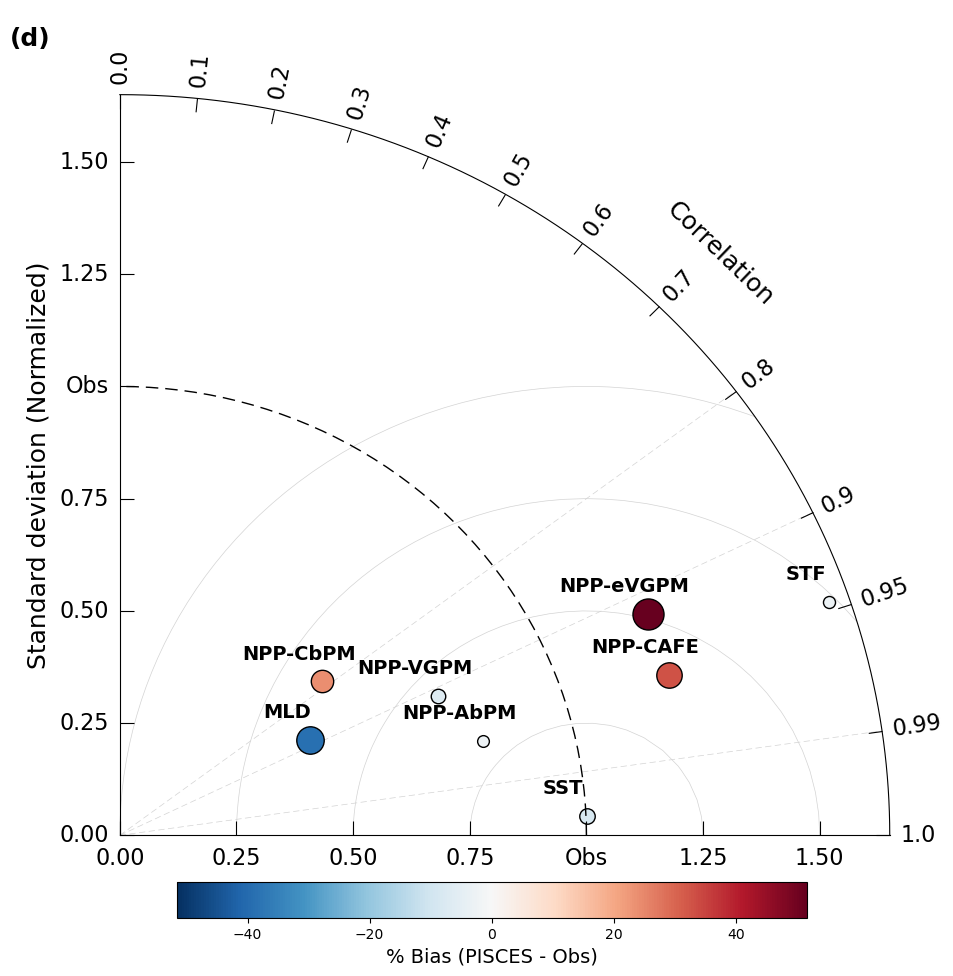

In [27]:
models = [
    ('NPP-VGPM', sd_norm_vgpm, corr_vgpm, bias_vgpm),
    ('NPP-eVGPM', sd_norm_evgpm, corr_evgpm, bias_evgpm),
    ('NPP-CbPM', sd_norm_cbpm, corr_cbpm, bias_cbpm),
    ('NPP-AbPM', sd_norm_abpm, corr_abpm, bias_abpm),
    ('NPP-CAFE', sd_norm_cafe, corr_cafe, bias_cafe),
    ('MLD', sd_norm_mld, corr_mld, bias_mld),
    ('SST', sd_norm_sst, corr_sst, bias_sst),
    ('STF', sd_norm_stf, corr_stf, bias_stf),
]

# Normalize bias for color (centered around 0)
bias_vals = [m[3] for m in models]
norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=-max(bias_vals), vmax=max(bias_vals))
cmap = cm.RdBu_r  # Red = positive bias, Blue = negative bias

# Size: scale by absolute bias
def bias_to_size(bias, min_size=200, max_size=2000):
    abs_bias = abs(bias)
    return min_size + (max_size - min_size) * abs_bias / max(abs(bias) for _, _, _, bias in models)

fig = plt.figure(figsize=(9, 9))
taylor = gv.TaylorDiagram(fig=fig, label='Obs')
ax = plt.gca()

# Add gridlines (optional)
taylor.add_xgrid(np.array([0.8, 0.9, 0.99]), zorder = 0)

taylor.add_contours(levels=np.arange(0, 1.1, 0.25),
                 colors='lightgrey',
                 linewidths=0.5, zorder = 0);

# Add each point
for name, std_norm, corr, bias in models:
    color = cmap(norm(bias))
    size = bias_to_size(bias)
    
    ax.plot(std_norm * np.cos(np.arccos(corr)), std_norm * np.sin(np.arccos(corr)),
            marker='o', markersize=np.sqrt(size)/2,  # Convert area to radius
            color=color, markeredgecolor = 'k', label=name, zorder = 1)
    ax.text(
        std_norm * corr - 0.05, std_norm * np.sin(np.arccos(corr))+0.05, name,
        fontsize=14, fontweight = 'bold', color='k', ha='center'
    )

ax.text(
    -0.13, 1.08, f'(d)',
    transform=ax.transAxes,
    fontsize=18,
    fontweight='bold',
    va='top',
    ha='left'
    )    

# Colorbar
cax = fig.add_axes([0.15, -0.02, 0.7, 0.04])  # [left, bottom, width, height]
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label('% Bias (PISCES - Obs)', fontsize=14)
# Adjust subplot layout
plt.subplots_adjust(left=0.05, right=1, top=0.9, bottom=0.1)

# Add legend
#ax.legend(loc='upper right', fontsize=10)

#plt.title("Taylor Diagram with Bias Encoded by Color & Size", size=18, pad = 80)
plt.tight_layout()
plt.show()


# Figures 4 - 7:

The current set up of the core PISCES Bootstrap analysis uses the high/low year NPP year subsets determined from total phytoplankton NPP. However, All phytoplankton class specific and total phytoplankton varaibles are included in the analysis so that we can diagnose the class specific roles in high NPP periods. The plotting architecture has been set up so specific classes can be also be plotted as in Appendix A figures A1.3, A1.4 and A1.5

## Determine years of 5 highest and 5 lowest integrated seasonal NPP (July to June) in PISCES historical simulation (1975 - 2022). 

In [28]:
# Determine seasonal mean depth integrated NPP
# Commented out code is to select pytoplankton class specific NPP
'''
depsum_ppphyn_seasonal_mean = (depsum_ppphyn.weighted(area).mean(dim=['y', 'x']).groupby('july_year').mean(dim='time_counter')) 
depsum_ppphyn_seasonal_mean = depsum_ppphyn_seasonal_mean.where(~depsum_ppphyn_seasonal_mean['july_year'].isin([1974, 2022]), drop=True)

depsum_ppphyp_seasonal_mean = (depsum_ppphyp.weighted(area).mean(dim=['y', 'x']).groupby('july_year').mean(dim='time_counter')) 
depsum_ppphyp_seasonal_mean = depsum_ppphyp_seasonal_mean.where(~depsum_ppphyp_seasonal_mean['july_year'].isin([1974, 2022]), drop=True)

depsum_ppphyd_seasonal_mean = (depsum_ppphyd.weighted(area).mean(dim=['y', 'x']).groupby('july_year').mean(dim='time_counter')) 
depsum_ppphyd_seasonal_mean = depsum_ppphyd_seasonal_mean.where(~depsum_ppphyd_seasonal_mean['july_year'].isin([1974, 2022]), drop=True)
'''
depsum_pp_tot_seasonal_mean = (depsum_pp_tot.weighted(area).mean(dim=['y', 'x']).groupby('july_year').mean(dim='time_counter')) 
depsum_pp_tot_seasonal_mean = depsum_pp_tot_seasonal_mean.where(~depsum_pp_tot_seasonal_mean['july_year'].isin([1974, 2022]), drop=True)

# Define days per month (assuming no leap years)
days_in_month = xr.DataArray(
    [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],  # Jan to Dec
    dims="month",
    coords={"month": np.arange(1, 13)}
)

# 2. Broadcast days to match the 'month' coordinate in your data
days = days_in_month.sel(month=depsum_ppphyn['month'])

# Seasonally integrate NPP using july-year coordinate and area weighting scheme. 
'''depsum_ppphyn_seasonal_integrated = ((depsum_ppphyn * days).weighted(area).mean(dim=['y', 'x']).groupby('july_year').sum(dim='time_counter'))
depsum_ppphyn_seasonal_integrated = depsum_ppphyn_seasonal_integrated.where(~depsum_ppphyn_seasonal_mean['july_year'].isin([1974, 2022]), drop=True)
top5_ppphyn_int_years = np.sort(depsum_ppphyn_seasonal_integrated['july_year'].sortby(depsum_ppphyn_seasonal_integrated, ascending=False).isel(july_year=slice(0, 5)).values)
bottom5_ppphyn_int_years = np.sort(depsum_ppphyn_seasonal_integrated['july_year'].sortby(depsum_ppphyn_seasonal_integrated, ascending=True).isel(july_year=slice(0, 5)).values)

depsum_ppphyp_seasonal_integrated = ((depsum_ppphyp * days).weighted(area).mean(dim=['y', 'x']).groupby('july_year').sum(dim='time_counter'))
depsum_ppphyp_seasonal_integrated = depsum_ppphyp_seasonal_integrated.where(~depsum_ppphyp_seasonal_mean['july_year'].isin([1974, 2022]), drop=True)
top5_ppphyp_int_years = np.sort(depsum_ppphyp_seasonal_integrated['july_year'].sortby(depsum_ppphyp_seasonal_integrated, ascending=False).isel(july_year=slice(0, 5)).values)
bottom5_ppphyp_int_years = np.sort(depsum_ppphyp_seasonal_integrated['july_year'].sortby(depsum_ppphyp_seasonal_integrated, ascending=True).isel(july_year=slice(0, 5)).values)

depsum_ppphyd_seasonal_integrated = ((depsum_ppphyd * days).weighted(area).mean(dim=['y', 'x']).groupby('july_year').sum(dim='time_counter'))
depsum_ppphyd_seasonal_integrated = depsum_ppphyd_seasonal_integrated.where(~depsum_ppphyd_seasonal_mean['july_year'].isin([1974, 2022]), drop=True)
top5_ppphyd_int_years = np.sort(depsum_ppphyd_seasonal_integrated['july_year'].sortby(depsum_ppphyd_seasonal_integrated, ascending=False).isel(july_year=slice(0, 5)).values)
bottom5_ppphyd_int_years = np.sort(depsum_ppphyd_seasonal_integrated['july_year'].sortby(depsum_ppphyd_seasonal_integrated, ascending=True).isel(july_year=slice(0, 5)).values)'''

depsum_pp_tot_seasonal_integrated = ((depsum_pp_tot * days).weighted(area).mean(dim=['y', 'x']).groupby('july_year').sum(dim='time_counter'))
depsum_pp_tot_seasonal_integrated = depsum_pp_tot_seasonal_integrated.where(~depsum_pp_tot_seasonal_mean['july_year'].isin([1974, 2022]), drop=True)
top5_pp_tot_int_years = np.sort(depsum_pp_tot_seasonal_integrated['july_year'].sortby(depsum_pp_tot_seasonal_integrated, ascending=False).isel(july_year=slice(0, 5)).values)
bottom5_pp_tot_int_years = np.sort(depsum_pp_tot_seasonal_integrated['july_year'].sortby(depsum_pp_tot_seasonal_integrated, ascending=True).isel(july_year=slice(0, 5)).values)

#print(top5_ppphyn_int_years)
#print(bottom5_ppphyn_int_years)
#print(top5_ppphyp_int_years )
#print(bottom5_ppphyp_int_years)
#print(top5_ppphyd_int_years )
#print(bottom5_ppphyd_int_years)
print(f'Highest 5 highest integrated NPP (total phytoplankton) January-centred years: {top5_pp_tot_int_years}')
print(f'Lowest 5 integrated NPP (total phytoplankton) January-centred years: {bottom5_pp_tot_int_years}')

Highest 5 highest integrated NPP (total phytoplankton) January-centred years: [1990 2000 2003 2015 2019]
Lowest 5 integrated NPP (total phytoplankton) January-centred years: [1975 1979 1980 1988 1989]


## Define depth integration pre-processing functions

In [29]:
### NPP ####
def compute_depth_integrated_npp(subset_diag, depth_thickness):
    """Compute depth-integrated NPP for each phytoplankton group and total.
    Converts units from mol C m⁻² s⁻¹ to mmol C m⁻² day⁻¹.
    """
    seconds_per_day = 86400

    depsum_ppphyn = ((subset_diag['PPPHYN'] * depth_thickness).sum(dim='deptht')) * seconds_per_day * 1000
    depsum_ppphyd = ((subset_diag['PPPHYD'] * depth_thickness).sum(dim='deptht')) * seconds_per_day * 1000
    depsum_ppphyp = ((subset_diag['PPPHYP'] * depth_thickness).sum(dim='deptht')) * seconds_per_day * 1000
    depsum_pp_tot = (((subset_diag['PPPHYN'] + subset_diag['PPPHYD'] + subset_diag['PPPHYP']) * depth_thickness).sum(dim='deptht')) * seconds_per_day * 1000
    remin = ((subset_diag['REMINF'] * depth_thickness).sum(dim='deptht')) * seconds_per_day 

    return {
        'ppphyn': depsum_ppphyn,
        'ppphyd': depsum_ppphyd,
        'ppphyp': depsum_ppphyp,
        'pp_tot': depsum_pp_tot,
        'remin': remin
    }

def compute_depth_integrated_biomass(subset_trc, depth_thickness):
    """Compute depth-integrated biomass for each phytoplankton group and total.
    """

    depsum_phy = ((subset_trc['PHY'] * depth_thickness).sum(dim='deptht'))
    depsum_phy2 = ((subset_trc['PHY2'] * depth_thickness).sum(dim='deptht'))
    depsum_pic = ((subset_trc['PIC'] * depth_thickness).sum(dim='deptht'))
    depsum_phy_tot = (((subset_trc['PHY'] + subset_trc['PHY2'] + subset_trc['PIC']) * depth_thickness).sum(dim='deptht'))

    return {
        'nano_biomass': depsum_phy,
        'diatom_biomass': depsum_phy2,
        'pico_biomass': depsum_pic,
        'biomass_tot': depsum_phy_tot
    }


def compute_depth_integrated_chl(subset_trc, depth_thickness):
    """Compute depth-integrated chorophyll for each phytoplankton group and total.
    """

    depsum_chln = ((subset_trc['NCHL'] * depth_thickness).sum(dim='deptht'))
    depsum_chld = ((subset_trc['DCHL'] * depth_thickness).sum(dim='deptht'))
    depsum_chlp = ((subset_trc['PCHL'] * depth_thickness).sum(dim='deptht'))
    depsum_chl_tot = (((subset_trc['NCHL'] + subset_trc['DCHL'] + subset_trc['PCHL']) * depth_thickness).sum(dim='deptht'))

    return {
        'chl_n': depsum_chln,
        'chl_d': depsum_chld,
        'chl_p': depsum_chlp,
        'chl_total': depsum_chl_tot
    }

### Nutrient inventories
def compute_depth_integrated_nuts(subset_trc, depth_thickness):
    """Compute depth-integrated nutrients for each phytoplankton group and total,
    restricted to depths shallower than 300 m.
    """
    # Mask for depth levels < 300 m
    shallow_mask = subset_trc['deptht'] < 300

    # Apply mask to restrict both nutrient fields and depth_thickness
    trc_shallow = subset_trc.where(shallow_mask, drop=True)
    thickness_shallow = depth_thickness.where(shallow_mask, drop=True)

    # Perform depth integration over shallow depths only
    depsum_no3 = (trc_shallow['NO3'] * thickness_shallow).sum(dim='deptht')
    depsum_si = (trc_shallow['Si'] * thickness_shallow).sum(dim='deptht')
    depsum_fer = (trc_shallow['Fer'] * thickness_shallow).sum(dim='deptht')
    depsum_o2 = (trc_shallow['O2'] * thickness_shallow).sum(dim='deptht')

    return {
        'depsum_no3': depsum_no3,
        'depsum_si': depsum_si,
        'depsum_fer': depsum_fer,
        'depsum_o2': depsum_o2
    }

def compute_depth_integrated_zoop(subset_trc, depth_thickness):
    """Compute depth-integrated zooplankton biomass group and total."""
    depsum_microzoo = ((subset_trc['ZOO'] * depth_thickness).sum(dim='deptht'))
    depsum_mesozoo = ((subset_trc['ZOO2'] * depth_thickness).sum(dim='deptht'))

    return {
        'microzoo': depsum_microzoo,
        'mesozoo': depsum_mesozoo
    }

## Compute phytoplankton class specific grazing loss terms and non-grazing (mortality and aggregation) loss terms

Calculation of relative specific grazing rates here does not included POC in this version due to no saved POC output. Equations in Kwiatkowski et al 2018. 

In [30]:
## Variable check ##
# Zoop classes
microzoop = subset_trc['ZOO']       ## mmol/m3
mesozoop = subset_trc['ZOO2']       ## mmol/m3

#Phyto classes
phyn_conc = subset_trc['PHY']       ## mmol/m3
phyd_conc = subset_trc['PHY2']      ## mmol/m3
phyp_conc = subset_trc['PIC']
                       
# Detrital pools (particulate organic carbon)
poc = subset_trc['POC']             ## mmol/m3

# Nutrient Limitation terms 
LDFe = subset_diag['LDFe']
LDN = subset_diag['LDN']

L_nuts_D = np.minimum(LDFe, LDN) # Limiting nutrient diatoms

mld = subset_T['mldr10_1']          ## m
temperature = (subset_T['thetao']).transpose('time_counter', 'deptht', 'y', 'x')    ## degC
depth = subset_T['deptht']  ## m

######### Zooplantkton Grazing Formulaton #########
## Class dependent T-lim terms scale the max class
b_micro, b_meso, b_zoo = 1.079, 1.079, 1.079
th_prey, Iz_th, th_glob = 0.001, 0.01, 0.3 # Jz_thresh ( = th_prey), Iz_thresh and Fz_thresh
exp_func = 1.5 # exponent of functional response

######### ZOO: Microzooplankton Grazing On: #########
# Prey: Nanophytoplankton, Diatoms, pico, microzooplankton
# Base Preferencial grazing rates
prf_nano, prf_diat, prf_pico, prf_microzoop, prf_poc = 1, 1, 1.6, 0.3, 0.1

# Total apparent food
food_th = prf_nano*np.maximum(0, phyn_conc - th_prey) + prf_diat*np.maximum(0, phyd_conc - th_prey) + prf_pico*np.maximum(0, phyp_conc - th_prey) + prf_microzoop*np.maximum(0, microzoop - th_prey) + prf_poc*np.maximum(0, poc - th_prey)

food = prf_nano*phyn_conc + prf_diat*phyd_conc + prf_pico*phyp_conc + prf_microzoop*microzoop + prf_poc*poc

food_gamma = prf_nano*(phyn_conc ** exp_func) + prf_diat*(phyd_conc ** exp_func) + prf_pico*(phyp_conc ** exp_func) + prf_microzoop*(microzoop ** exp_func) + prf_poc*(poc ** exp_func)

food_lim = np.maximum(0, food_th - np.minimum(0.5*food_th, th_glob))

# Microzooplankton Grazing On: NanoPhytoplankton:
#  Single-prey w/ switching  
#  g   =  2.75 (1/d); 
#  K   =  20 (mmolC/m3); Converted from 20 umol C/L
g_microzoop_phyn_conc = (2.75 * (b_micro ** temperature)) * ((prf_nano*(phyn_conc ** exp_func))/food_gamma) * (food_lim / food_th) * ((prf_nano * np.maximum(0, phyn_conc - Iz_th)) / (20 + food))

# Microzooplankton Grazing On: Diatoms
g_microzoop_phyd_conc = (2.75 * (b_micro ** temperature)) * ((prf_diat*(phyd_conc ** exp_func))/food_gamma) * (food_lim / food_th) * ((prf_diat * np.maximum(0, phyd_conc - Iz_th)) / (20 + food))

# Microzooplankton Grazing On: Picophytoplankton
g_microzoop_phyp_conc = (2.75 * (b_micro ** temperature)) * ((prf_pico*(phyp_conc ** exp_func))/food_gamma) * (food_lim / food_th) * ((prf_pico * np.maximum(0, phyp_conc - Iz_th)) / (20 + food))

######### ZOO2: Mesozooplankton Grazing On: #########
# Prey: Nanophytoplankton, Diatoms, microzooplanton and mesozooplankton (no grazing on picophytoplankton)
# Base Preferencial grazing rates
prf_nano, prf_diat, prf_pico, prf_microzoop, prf_mesozoop, prf_poc = 1, 1, 0, 1, 0.2, 0.3

# Total apparent food
food_th = prf_nano*np.maximum(0, phyn_conc-th_prey) + prf_diat*np.maximum(0, phyd_conc-th_prey) + prf_pico*np.maximum(0, phyp_conc-th_prey) + prf_microzoop*np.maximum(0, microzoop-th_prey) + prf_mesozoop*np.maximum(0, mesozoop-th_prey) + prf_poc*np.maximum(0, poc - th_prey)
                              
food = prf_nano*phyn_conc + prf_diat*phyd_conc + prf_pico*phyp_conc + prf_microzoop*microzoop + prf_mesozoop*mesozoop + prf_poc*poc

food_gamma = prf_nano*(phyn_conc ** exp_func) + prf_diat*(phyd_conc ** exp_func) + prf_pico*(phyp_conc ** exp_func) + prf_microzoop*(microzoop ** exp_func) + prf_mesozoop*(mesozoop ** exp_func) + prf_poc*(poc ** exp_func)                   
                         
food_lim = np.maximum(0, food_th-np.minimum(0.5*food_th, th_glob))

# Mesozooplankton Grazing On: NanoPhytoplankton
#  Single-prey w/ switching  
#  g   =  0.85 (1/d); 
#  K   =  20 (mmolC/m3); Converted from 20 umol C/L
g_mesozoop_phyn_conc = (0.85*(b_meso**temperature)) * ((prf_nano*(phyn_conc ** exp_func))/food_gamma) * (food_lim/food_th) * (prf_nano*np.maximum(0, phyn_conc - th_prey)) / (20 + food)

#  Mesozooplankton Grazing On: Diatoms
g_mesozoop_phyd_conc = (0.85 * (b_meso**temperature)) * ((prf_diat*(phyd_conc ** exp_func))/food_gamma)  * (food_lim/food_th) * (prf_diat * np.maximum(0, phyd_conc - th_prey)) / (20 + food)
                        
########## Total Grazing rate at which phytoplankton are grazed by zooplankton (G) ########## rate (mmol m-3 d-1) ##########
GSP_n = g_microzoop_phyn_conc*microzoop + g_mesozoop_phyn_conc*mesozoop
GSP_d = g_microzoop_phyd_conc*microzoop + g_mesozoop_phyd_conc*mesozoop
GSP_p = g_microzoop_phyp_conc*microzoop                       

GSP = GSP_n + GSP_d + GSP_p

##################################################################################################################
### Divide G by phytoplankton biomass to derive grazing pressure in each gridcell (for the given phytoplankton biomass in a grid cell, what is the grazing pressure, i.e. phytoplankton specific grazing loss rate per day)
# Units are d-1 --> = (l) in Rohr et al., 2022) 
GSP_n_pressure = GSP_n/phyn_conc
GSP_d_pressure = GSP_d/phyd_conc
GSP_p_pressure = GSP_p/phyp_conc                  
GSP_pressure = GSP/(phyn_conc+phyd_conc+phyp_conc)

## (l_int) Integrate grazing pressure over depth (Water column grazing pressure given water column biomass). Units are still d-1
GSP_n_depsum = (GSP_n*depth_thickness).sum(dim = 'deptht')/((phyn_conc*depth_thickness).sum(dim = 'deptht'))
GSP_d_depsum = (GSP_d*depth_thickness).sum(dim = 'deptht')/((phyd_conc*depth_thickness).sum(dim = 'deptht'))   
GSP_p_depsum = (GSP_p*depth_thickness).sum(dim = 'deptht')/((phyp_conc*depth_thickness).sum(dim = 'deptht'))   
GSP_depsum = (GSP*depth_thickness).sum(dim = 'deptht') / (((phyn_conc+phyd_conc+phyp_conc)*depth_thickness).sum(dim = 'deptht'))   
##################################################################################################################

## Clearance rate (Cl = grazing loss rate / zoop_conc = l/[Z] = G/[P][Z]) m3 mmolC-1 d-1
clearance_n = GSP_n_pressure/(microzoop+mesozoop)                
clearance_d = GSP_d_pressure/(microzoop+mesozoop)                            
clearance_p = GSP_p_pressure/(microzoop)                            
clearance_total = GSP_pressure/(microzoop+mesozoop)

## Integrated Clearance rate (grazing rate / phyto_conc) m2 mmolC-1 d-1: per water column integrated biomass. 
clear_n_depsum = (GSP_n_pressure*depth_thickness).sum(dim = 'deptht')/(((microzoop+mesozoop)*depth_thickness).sum(dim = 'deptht'))                
clear_d_depsum = (GSP_d_pressure*depth_thickness).sum(dim = 'deptht')/(((microzoop+mesozoop)*depth_thickness).sum(dim = 'deptht'))           
clear_p_depsum = (GSP_p_pressure*depth_thickness).sum(dim = 'deptht')/((microzoop*depth_thickness).sum(dim = 'deptht'))                            
clear_total_depsum = (GSP_pressure*depth_thickness).sum(dim = 'deptht')/(((microzoop+mesozoop)*depth_thickness).sum(dim = 'deptht'))

########## Non-grazing losses (NGL) ########## 
## Losses from mortality and aggregation (see equations in Aumont et al. (2015) & Kwiatkowski et al. (2018). 
# Density dependent Linear mortality rate (d-1) | Small and Large P
m1 = 0.01 # phytoplankton mortality rate (d-1)
k1 = 0.2 # half-saturation for mortality umolC L-1 == mmolC m-3
 
# Quadratic Mortality      
a1 = 0.01 # Minimum quadratic mortality rate pf phytoplankton (molC-1 d-1)
a2 = 0.02 # Maximum quadratic mortality rate (molC-1 d-1) for diatoms (none for nanophy) update from Kwiatkow. 2018
    
## Shear scaling: = 1 s-1 in mixed layer, 0.01 s -1 below MLD. I.e. particle aggreation is 100-fold less below the mixed layer. 
sh = xr.ones_like(phyd_conc) # Initialise an array of ones with the same shape as phyd_conc
depth_3d = phyd_conc.deptht.broadcast_like(phyd_conc) # Expand deptht to match the dimensions of phyd_conc
mld_expanded = mld.expand_dims({'deptht': phyd_conc.deptht}, axis=0) # Expand mld to match the dimensions of phyd_conc
sh = xr.where(depth_3d > mld_expanded, 0.01, sh) # Assign shear value as 0.01 where deptht is greater than mld, otherwise sh=1

# NGL Calculation (units are 
NGL_n = (sh * a1 * phyn_conc**2 + m1 * (phyn_conc / (k1 + phyn_conc)) * phyn_conc)   
NGL_p = (sh * a1 * phyp_conc**2 + m1 * (phyp_conc / (k1 + phyp_conc)) * phyp_conc)  
NGL_d = (sh * (a1 + a2 * (1 - L_nuts_D)) * phyd_conc**2 + m1 * (phyd_conc / (k1 + phyd_conc)) * phyd_conc)   
NGL = (sh * a1 * phyn_conc**2 + m1 * (phyn_conc / (k1 + phyn_conc)) * phyn_conc) + (sh * a1 * phyp_conc**2 + m1 * (phyp_conc / (k1 + phyp_conc)) * phyp_conc)  +(sh * (a1 + a2 * (1 - L_nuts_D)) * phyd_conc**2) + (m1 * (phyd_conc / (k1 + phyd_conc)) * phyd_conc)   

# Normalise to phytoplankton biomass
NGL_n_pressure = NGL_n/phyn_conc
NGL_d_pressure = NGL_d/phyd_conc
NGL_p_pressure = NGL_p/phyp_conc
NGL_pressure = NGL/(phyn_conc+phyd_conc+phyp_conc)

NGL_n_depsum = (NGL_n*depth_thickness).sum(dim = 'deptht')/((phyn_conc*depth_thickness).sum(dim = 'deptht'))
NGL_d_depsum = (NGL_d*depth_thickness).sum(dim = 'deptht')/((phyd_conc*depth_thickness).sum(dim = 'deptht'))
NGL_p_depsum = (NGL_p*depth_thickness).sum(dim = 'deptht')/((phyp_conc*depth_thickness).sum(dim = 'deptht'))
NGL_depsum = (NGL*depth_thickness).sum(dim = 'deptht')/(((phyn_conc+phyd_conc+phyp_conc)*depth_thickness).sum(dim = 'deptht'))

## Compute biomass-weighted depth-averaged (BWDA) diagnostics

In [31]:
####### Select subset for plotting
ds = subset_diag
#######

# Store variables for specific phytoplankton classes in lists
bw_variables_n = ['PPPHYN', 'LNlight', 'LNFe', 'LNN', 'MuN'] ## PPNFe and LNnut omitted
bw_variables_d = ['PPPHYD', 'LDlight', 'LDFe', 'LDN', 'MuD'] ## PPDFe and LDnut omitted
bw_variables_p = ['PPPHYP', 'LPlight', 'LPFe', 'LPN', 'MuP'] ## PPPFe and LPnut omitted

bwda_n = {}
bwda_d = {}
bwda_p = {}

bwda_n_climatology_avg = {}
bwda_n_climatology_std = {}
bwda_d_climatology_avg = {}
bwda_d_climatology_std = {}
bwda_p_climatology_avg = {}
bwda_p_climatology_std = {}

# Nanophy. BWDA terms
for var in bw_variables_n:
    # Weight the annual mean values by biomass and depth thickness
    bwda_n[var] = ((ds[var] * phyn_conc * depth_thickness) / bio_inventory_n).sum(dim='deptht')

    bwda_n_climatology_avg[var] = bwda_n[var].groupby('time_counter.month').mean(dim=['y', 'x', 'time_counter'])
    bwda_n_climatology_std[var] = bwda_n[var].groupby('time_counter.month').std(dim=['y', 'x', 'time_counter'])

# Diatom BWDA terms
for var in bw_variables_d:
    # Weight the annual mean values by biomass and depth thickness
    bwda_d[var] = ((ds[var] * phyd_conc * depth_thickness) / bio_inventory_d).sum(dim='deptht')

    bwda_d_climatology_avg[var] = bwda_d[var].groupby('time_counter.month').mean(dim=['y', 'x', 'time_counter'])
    bwda_d_climatology_std[var] = bwda_d[var].groupby('time_counter.month').std(dim=['y', 'x', 'time_counter'])

# Picophy. BWDA terms
for var in bw_variables_p:
    # Weight the annual mean values by biomass and depth thickness
    bwda_p[var] = ((ds[var] * phyp_conc * depth_thickness) / bio_inventory_p).sum(dim='deptht')

    bwda_p_climatology_avg[var] = bwda_p[var].groupby('time_counter.month').mean(dim=['y', 'x', 'time_counter'])
    bwda_p_climatology_std[var] = bwda_p[var].groupby('time_counter.month').std(dim=['y', 'x', 'time_counter'])
    
# Total phytoplankton BWDA terms = state of the average phytoplankton at any given depth
bwda_total_PP = ((((ds['PPPHYN']*phyn_conc) + (ds['PPPHYD']*phyd_conc) + (ds['PPPHYP']*phyp_conc)) * depth_thickness)/bio_inventory_tot).sum(dim='deptht') 
bwda_total_LN = ((((ds['LNN'] * phyn_conc) + (ds['LDN'] * phyd_conc ) + (ds['LPN']*phyp_conc)) * depth_thickness)/bio_inventory_tot).sum(dim='deptht') 
bwda_total_Llight = ((((ds['LNlight']*phyn_conc) + (ds['LDlight']*phyd_conc) + (ds['LPlight']*phyp_conc)) * depth_thickness)/bio_inventory_tot).sum(dim='deptht') 
bwda_total_LFe = ((((ds['LNFe'] * phyn_conc) + (ds['LDFe'] * phyd_conc) + (ds['LPFe'] * phyp_conc)) * depth_thickness)/bio_inventory_tot).sum(dim='deptht') 
bwda_Mutotal = ((((ds['MuN'] * phyn_conc) + (ds['MuD'] * phyd_conc) + (ds['MuP'] * phyp_conc)) * depth_thickness)/bio_inventory_tot).sum(dim='deptht') 

##############################################################################
# Derive temperature dependent growth rate for each phyto class
μ_Pp = 0.7*(1.066**(subset_T['thetao'])) # Picophytoplankton mu_max value is 0.7
μ_Pn = 0.9*(1.066**(subset_T['thetao'])) # Nano and diatom mu_max value is 0.9
μ_Pd = 0.9*(1.066**(subset_T['thetao'])) # Nano and diatom mu_max value is 0.9

bwda_μ_P_n = ((μ_Pn * phyn_conc * depth_thickness) / bio_inventory_n).sum(dim='deptht')
bwda_μ_P_d = ((μ_Pd * phyd_conc * depth_thickness) / bio_inventory_d).sum(dim='deptht')
bwda_μ_P_p = ((μ_Pp * phyp_conc * depth_thickness) / bio_inventory_p).sum(dim='deptht')

bwda_μ_P_total = ((((μ_Pn * phyn_conc) + (μ_Pd * phyd_conc) + (μ_Pp * phyp_conc)) * depth_thickness)/bio_inventory_tot).sum(dim='deptht') 

## Bootstrap mean state (depth integrated and BWDA) variables across full time series 

This analysis determines climatological delta-variables (the difference in variables between highest and lowest periods of climatological NPP) and their significane relative to full time series variability. 

### Analysis plan for total phytoplankton min/max NPP years

Sets out a Bootstrap analysis plan that maps variables to data sets and pre-processing functions. 

In [32]:
## Total NPP years only for high and low years
analysis_plan_totalonly = {
    'ppphyn': {
        'high_years': top5_pp_tot_int_years,
        'low_years': bottom5_pp_tot_int_years,
        'variables': [
            {
                'name': 'PPPHYN',
                'source': compute_depth_integrated_npp(subset_diag, depth_thickness)['ppphyn'],
            },
            {
                'name': 'nano_biomass',
                'source': compute_depth_integrated_biomass(subset_trc, depth_thickness)['nano_biomass'],
            },
            {
                'name': 'chl_n',
                'source': compute_depth_integrated_chl(subset_trc, depth_thickness)['chl_n'],
            },
            {
                'name': 'GSP_n_depsum',
                'source': GSP_n_depsum,
            },
            {
                'name': 'NGL_n_depsum',
                'source': NGL_n_depsum,
            },
            {
                'name': 'clear_n_depsum',
                'source': clear_n_depsum,
            },
            {
                'name': 'μ_max_n',
                'source': bwda_μ_P_n,
            },
            {
                'name': 'LNFe_n',
                'source': bwda_n['LNFe'],
            },
            {
                'name': 'LNN_n',
                'source': bwda_n['LNN'],
            },
            {
                'name': 'LNlight_n',
                'source': bwda_n['LNlight'],
            },
            {
                'name': 'μ_n',
                'source': bwda_n['MuN']*seconds_per_day,
            }
        ]
    },

    'ppphyp': {
        'high_years': top5_pp_tot_int_years,
        'low_years': bottom5_pp_tot_int_years,
        'variables': [
            {
                'name': 'PPPHYP',
                'source': compute_depth_integrated_npp(subset_diag, depth_thickness)['ppphyp'],
            },
            {
                'name': 'pico_biomass',
                'source': compute_depth_integrated_biomass(subset_trc, depth_thickness)['pico_biomass'],
            },
            {
                'name': 'chl_p',
                'source': compute_depth_integrated_chl(subset_trc, depth_thickness)['chl_p'],
            },
            {
                'name': 'GSP_p_depsum',
                'source': GSP_p_depsum,
            },
            {
                'name': 'NGL_p_depsum',
                'source': NGL_p_depsum,
            },
            {
                'name': 'clear_p_depsum',
                'source': clear_p_depsum,
            },
            {
                'name': 'μ_max_p',
                'source': bwda_μ_P_p,
            },
            {
                'name': 'LPFe_p',
                'source': bwda_p['LPFe'],
            },
            {
                'name': 'LPN_p',
                'source': bwda_p['LPN'],
            },
            {
                'name': 'LPlight_p',
                'source': bwda_p['LPlight'],
            },
            {
                'name': 'μ_p',
                'source': bwda_p['MuP']*seconds_per_day,
            }
        ]
    },

    'ppphyd': {
        'high_years': top5_pp_tot_int_years,
        'low_years': bottom5_pp_tot_int_years,
        'variables': [
            {
                'name': 'PPPHYD',
                'source': compute_depth_integrated_npp(subset_diag, depth_thickness)['ppphyd'],
            },
            {
                'name': 'diatom_biomass',
                'source': compute_depth_integrated_biomass(subset_trc, depth_thickness)['diatom_biomass'],
            },
            {
                'name': 'chl_d',
                'source': compute_depth_integrated_chl(subset_trc, depth_thickness)['chl_d'],
            },
            {
                'name': 'GSP_d_depsum',
                'source': GSP_d_depsum,
            },
            {
                'name': 'NGL_d_depsum',
                'source': NGL_d_depsum,
            },
            {
                'name': 'clear_d_depsum',
                'source': clear_d_depsum,
            },
            {
                'name': 'μ_max_d',
                'source': bwda_μ_P_d,
            },
            {
                'name': 'LDFe',
                'source': bwda_d['LDFe'],
            },
            {
                'name': 'LDN_d',
                'source': bwda_d['LDN'],
            },
            {
                'name': 'LDlight_d',
                'source': bwda_d['LDlight'],
            },
            {
                'name': 'μ_d',
                'source': bwda_d['MuD']*seconds_per_day,
            }
        ]
    },

    'pp_total': {
        'high_years': top5_pp_tot_int_years,
        'low_years': bottom5_pp_tot_int_years,
        'variables': [
            {
                'name': 'PP_total',
                'source': compute_depth_integrated_npp(subset_diag, depth_thickness)['pp_tot'],
            },
            {
                'name': 'biomass_tot',
                'source': compute_depth_integrated_biomass(subset_trc, depth_thickness)['biomass_tot'],
            },
            {
                'name': 'chl_total',
                'source': compute_depth_integrated_chl(subset_trc, depth_thickness)['chl_total'],
            },
            {
                'name': 'GSP_depsum',
                'source': GSP_depsum,
            },
            {
                'name': 'NGL_depsum',
                'source': NGL_depsum,
            },
            {
                'name': 'clear_total_depsum',
                'source': clear_total_depsum,
            },
            {
                'name': 'MLD',
                'source': subset_T['mldr10_1'],
            },
            {
                'name': 'SST',
                'source': subset_T['tos'],
            },
            {
                'name': 'NO3',
                'source': compute_depth_integrated_nuts(subset_trc, depth_thickness)['depsum_no3'],
            },
            {
                'name': 'Si',
                'source': compute_depth_integrated_nuts(subset_trc, depth_thickness)['depsum_si'],
            },
            {
                'name': 'Fe',
                'source': compute_depth_integrated_nuts(subset_trc, depth_thickness)['depsum_fer'],
            },
            {
                'name': 'O2',
                'source': compute_depth_integrated_nuts(subset_trc, depth_thickness)['depsum_o2'],
            },
            {
                'name': 'μ_max_total',
                'source': bwda_μ_P_total,
            },
            {
                'name': 'LFe_total',
                'source': bwda_total_LFe,
            },
            {
                'name': 'Llight_total',
                'source': bwda_total_Llight,
            },
            {
                'name': 'LN_total',
                'source': bwda_total_LN,
            },
            {
                'name': 'μ_total',
                'source': bwda_Mutotal*seconds_per_day,
            },
            {
                'name': 'Remin_Fe',
                'source': compute_depth_integrated_npp(subset_diag, depth_thickness)['remin'],
            },
            {
                'name': 'Microzoop',
                'source': compute_depth_integrated_zoop(subset_trc, depth_thickness)['microzoo'],
            },
            {
                'name': 'Mesozoop',
                'source': compute_depth_integrated_zoop(subset_trc, depth_thickness)['mesozoo'],
            }
        ]
    }
}

print('Analysis plan total NPP year subset: planned')

Analysis plan total NPP year subset: planned


#### Optional: Check analysis plan contents and structure

In [33]:
for main_var_group, details in analysis_plan_totalonly.items():
    high_years = details['high_years']
    low_years = details['low_years']
    print(f"\n=== Main variable group: {main_var_group} ===")
    print(f"High years: {high_years}")
    print(f"Low years: {low_years}")

    for var_info in details['variables']:
        name = var_info['name']
        raw_data = var_info['source']

        print(f"\nProcessing variable: {name}")
    
        
        # Print type
        print(f"Type of processed_data: {type(raw_data)}")
        
        # If xarray DataArray or Dataset, print dims and coords
        if hasattr(raw_data, 'dims') and hasattr(raw_data, 'coords'):
            print(f"Dims: {raw_data.dims}")
            print(f"Coords: {list(raw_data.coords)}")
            # Check if 'july_year', 'month', 'time_counter' coords are present
            for coord in ['july_year', 'month', 'time_counter']:
                print(f"  Has coord '{coord}': {coord in raw_data.coords}")
            # Print shape and a small data sample
            print(f"Shape: {raw_data.shape}")
            print(f"Sample values:\n{raw_data.isel(time_counter=0, month=0).values if 'time_counter' in raw_data.dims and 'month' in raw_data.dims else raw_data.values[:3]}")
        else:
            # For other data types, just print a summary
            try:
                print(f"Summary of processed_data: {str(raw_data)[:500]}")
            except Exception:
                print("Processed data is not easily printable")



=== Main variable group: ppphyn ===
High years: [1990 2000 2003 2015 2019]
Low years: [1975 1979 1980 1988 1989]

Processing variable: PPPHYN
Type of processed_data: <class 'xarray.core.dataarray.DataArray'>
Dims: ('time_counter', 'y', 'x')
Coords: ['nav_lat', 'nav_lon', 'time_counter', 'july_year', 'month']
  Has coord 'july_year': True
  Has coord 'month': True
  Has coord 'time_counter': True
Shape: (576, 3, 6)
Sample values:
[[[11.443844  12.006663  12.928383  14.173404  14.43646   15.59577  ]
  [14.095169  16.705873  19.951235  22.689917  21.435833  21.145086 ]
  [21.861198  21.744873  21.230038  21.966587  21.625046  21.446419 ]]

 [[ 9.568725  10.019876  10.399     11.123989  12.343535  13.336225 ]
  [12.206474  14.438905  16.203218  18.201279  18.53941   17.967253 ]
  [19.434492  17.238874  17.11176   16.88273   17.29069   16.937304 ]]

 [[ 7.6921296  8.246891   8.369316   8.171923   8.930521   9.750269 ]
  [ 9.721366  11.63349   12.391547  12.982829  14.273151  13.998115 ]
  

## Apply parallelized bootstrap analysis over the analysis_plan

Writes the file bootstrap_utils_core.py file that stores pickable bootstrap analysis functions such that process pool exucutor can pick each function and arrange processing across workers (cores).

In [34]:
# Make sure you know where this file is saving (prescribed path in section 1.2.1). 
with open("bootstrap_utils_core.py", "w") as f:
    f.write("""

import numpy as np
import xarray as xr
from tqdm import tqdm
from scipy.interpolate import interp1d
import traceback
import os

def bootstrap_core(da, high_years, low_years, area, n_iter=10000, seed=None):
    
    #Core bootstrap: ts must be a 1D or grouped time series with a 'july_year' coordinate and a 'month' coordinate.
    #Returns:
    #    delta_obs: observed difference in monthly climatology between groups
    #    p_val: two-sided p-values from bootstrap distribution
    
    # 1. Spatial mean time series
    ts = da.weighted(area).mean(dim=['y', 'x'])
    
    # 2. Subset time series by groups
    ts_high = ts.where(ts.july_year.isin(high_years), drop=True)
    ts_low = ts.where(ts.july_year.isin(low_years), drop=True)

    # 3. Compute observed monthly climatology delta
    delta_obs = ts_high.groupby('month').mean(dim='time_counter') - ts_low.groupby('month').mean(dim='time_counter')

    # 4. Bootstrap
    rng = np.random.default_rng(seed)
    all_july_years = np.unique(ts.july_year.values)
    n_high = len(high_years)
    n_low = len(low_years)
    B = np.zeros((n_iter, 12))  # 12 months

    for i in tqdm(range(n_iter), desc=f"Bootstrapping: {high_years} and {low_years}"):
        # Random sample of july_years
        sample_high = rng.choice(all_july_years, size=n_high, replace=False)
        remaining = [y for y in all_july_years if y not in sample_high]
        sample_low = rng.choice(remaining, size=n_low, replace=False)

        # Subset and compute climatologies
        ts_h = ts.where(ts.july_year.isin(sample_high), drop=True)
        ts_l = ts.where(ts.july_year.isin(sample_low), drop=True)
        clim_h = ts_h.groupby('month').mean()
        clim_l = ts_l.groupby('month').mean()
        B[i, :] = (clim_h - clim_l).values

    # 5. Two-sided p-values
    p_val = (np.abs(B) >= np.abs(delta_obs.values)[None, :]).mean(axis=0)
    p_val = xr.DataArray(p_val, dims=['month'], coords={'month': delta_obs['month']})

    return delta_obs, p_val
    

def run_single_bootstrap(key, var_name, da, high_years, low_years, area, n_iter=10000, seed=None):
    
    #Picklable wrapper for one bootstrap task.
    
    import traceback
    from bootstrap_utils_core import bootstrap_core

    try:
        delta_obs, p_val = bootstrap_core(da, high_years, low_years, area=area, n_iter=n_iter, seed=seed)
        return key, var_name, delta_obs, p_val, None
    except Exception:
        tb = traceback.format_exc()
        return key, var_name, None, None, tb
    
    
def bootstrap_stf_df(df, high_years, low_years, n_iter=10000, seed=None):

    #Bootstrap test on mean_stf time series in a pandas DataFrame.
    # 
    #Parameters:
    #  df: pd.DataFrame with columns ['mean_stf', 'month', 'july_year']
    #  high_years, low_years: lists of years for groups
    #  n_iter: number of bootstrap iterations
    #  seed: random seed
      
    #Returns:
    #  delta_obs: pd.Series indexed by month (difference in monthly means)
    #  p_val: pd.Series indexed by month (two-sided bootstrap p-values)
    
    
    # Subset data for high and low years
    df_high = df[df['july_year'].isin(high_years)]
    df_low = df[df['july_year'].isin(low_years)]
    
    # Compute observed monthly climatology delta (mean of mean_stf by month)
    delta_obs = df_high.groupby('month')['mean_stf'].mean() - df_low.groupby('month')['mean_stf'].mean()
    
    rng = np.random.default_rng(seed)
    all_years = df['july_year'].unique()
    n_high = len(high_years)
    n_low = len(low_years)
    B = np.zeros((n_iter, 12))  # 12 months
    
    for i in tqdm(range(n_iter), desc=f"Bootstrapping {n_iter} iterations"):
        # Sample years without replacement for groups
        sample_high = rng.choice(all_years, size=n_high, replace=False)
        remaining = np.setdiff1d(all_years, sample_high)
        sample_low = rng.choice(remaining, size=n_low, replace=False)
        
        # Subset data by sampled years
        samp_high_df = df[df['july_year'].isin(sample_high)]
        samp_low_df = df[df['july_year'].isin(sample_low)]
        
        # Compute monthly means
        clim_h = samp_high_df.groupby('month')['mean_stf'].mean()
        clim_l = samp_low_df.groupby('month')['mean_stf'].mean()
        
        # Compute difference and store
        # Ensure both Series have same month index
        diff = clim_h.reindex(range(1,13), fill_value=np.nan) - clim_l.reindex(range(1,13), fill_value=np.nan)
        B[i, :] = diff.values
    
    # Calculate two-sided p-values: proportion of bootstrap differences more extreme than observed delta
    p_vals = (np.abs(B) >= np.abs(delta_obs.values)[None, :]).mean(axis=0)
    p_val_series = pd.Series(p_vals, index=range(1,13))
    
    return delta_obs, p_val_series    
    
""")

### Call parallelized bootstrapper: 

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

!!!!!!!!!! Parallel processing may max out CPU allocation - check system capacity and compatibility with HPC environments. !!!!!!!!!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [35]:
import sys
sys.path.append("/Users/christoph/Library/CloudStorage/OneDrive-UniversityofTasmania/Research/PhD Project/Theme 3 Model Obs/") # this line ensures the right path to bootstrap_utils_core.py
import bootstrap_utils_core

import importlib
#importlib.reload(bootstrap_utils_core) # if you update the function, reload the moduke

tasks = []
for key, analysis in analysis_plan_totalonly.items():
    high_years = analysis['high_years']
    low_years = analysis['low_years']
    for var in analysis['variables']:
        var_name = var['name']
        da = var['source']
        tasks.append((key, var_name, da, high_years, low_years, area))


import concurrent.futures
from tqdm import tqdm
from bootstrap_utils_core import run_single_bootstrap

bootstrap_results_totalonly = {}

num_cpus = 8

with concurrent.futures.ProcessPoolExecutor(max_workers=num_cpus) as executor:
    futures = [executor.submit(run_single_bootstrap, *t) for t in tasks]

    for f in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Bootstrapping variables"):
        key, var_name, delta_obs, p_val, error = f.result()
        
        if key not in bootstrap_results_totalonly:
            bootstrap_results_totalonly[key] = {}
        
        if error is None:
            bootstrap_results_totalonly[key][var_name] = {
                'delta_obs': delta_obs,
                'p_val': p_val
            }
            print(f"✅ Finished {var_name} from {key}")
        else:
            print(f"⚠️ Skipping {var_name} from {key} due to error:\n{error}")
            
print('Parallel core processing of boostrap analysis complete')

Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:37<00:00, 102.87it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:37<00:00, 102.85it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:   0%|          | 10/10000 [00:00<01:41, 98.02it/s]/s]

✅ Finished μ_max_n from ppphyn
✅ Finished clear_n_depsum from ppphyn


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:38<00:00, 102.03it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:   0%|          | 0/10000 [00:00<?, ?it/s]

✅ Finished PPPHYN from ppphyn


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:38<00:00, 101.70it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:   1%|          | 117/10000 [00:01<01:40, 97.98it/s]]

✅ Finished GSP_n_depsum from ppphyn


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:39<00:00, 100.63it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:39<00:00, 100.56it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:39<00:00, 100.48it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:   2%|▏         | 228/10000 [00:02<01:43, 94.52it/s]]

✅ Finished NGL_n_depsum from ppphyn
✅ Finished nano_biomass from ppphyn
✅ Finished chl_n from ppphyn


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:39<00:00, 100.39it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:   2%|▏         | 172/10000 [00:01<01:43, 94.56it/s]

✅ Finished LNFe_n from ppphyn


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:42<00:00, 97.58it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:   0%|          | 10/10000 [00:00<01:41, 98.31it/s]/s]

✅ Finished μ_n from ppphyn


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:43<00:00, 96.50it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:  97%|█████████▋| 9745/10000 [01:41<00:02, 98.84it/s]

✅ Finished LNN_n from ppphyn


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:43<00:00, 96.22it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:   0%|          | 42/10000 [00:00<01:43, 95.81it/s]s]

✅ Finished LNlight_n from ppphyn


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:42<00:00, 97.37it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:   0%|          | 10/10000 [00:00<01:48, 92.37it/s]]]

✅ Finished GSP_p_depsum from ppphyp


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:44<00:00, 95.99it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:  98%|█████████▊| 9794/10000 [01:43<00:02, 95.63it/s]

✅ Finished PPPHYP from ppphyp


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:44<00:00, 96.13it/s] 
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:43<00:00, 96.28it/s] 
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:  99%|█████████▉| 9884/10000 [01:44<00:01, 94.18it/s]

✅ Finished chl_p from ppphyp
✅ Finished NGL_p_depsum from ppphyp


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:45<00:00, 94.83it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:   4%|▍         | 403/10000 [00:04<01:36, 99.91it/s] 

✅ Finished pico_biomass from ppphyp


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:37<00:00, 102.33it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:  97%|█████████▋| 9727/10000 [01:37<00:03, 82.08it/s]

✅ Finished clear_p_depsum from ppphyp


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:38<00:00, 101.75it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:  96%|█████████▋| 9633/10000 [01:36<00:04, 91.75it/s]

✅ Finished μ_max_p from ppphyp


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:40<00:00, 99.95it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:   0%|          | 0/10000 [00:00<?, ?it/s]

✅ Finished LPFe_p from ppphyp


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:40<00:00, 99.48it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:   1%|▏         | 131/10000 [00:01<02:07, 77.43it/s]]

✅ Finished LPN_p from ppphyp


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:40<00:00, 99.22it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:   1%|          | 61/10000 [00:00<01:41, 97.49it/s]]]

✅ Finished LPlight_p from ppphyp


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:40<00:00, 99.67it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:   5%|▍         | 454/10000 [00:04<01:40, 94.86it/s]]

✅ Finished μ_p from ppphyp


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:40<00:00, 99.39it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:   6%|▌         | 556/10000 [00:06<01:44, 90.32it/s]]

✅ Finished PPPHYD from ppphyd


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:41<00:00, 98.61it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:   3%|▎         | 255/10000 [00:02<01:37, 99.81it/s] 

✅ Finished diatom_biomass from ppphyd


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:42<00:00, 97.95it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:41<00:00, 98.72it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:   0%|          | 0/10000 [00:00<?, ?it/s]3.09it/s]

✅ Finished chl_d from ppphyd
✅ Finished GSP_d_depsum from ppphyd


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:42<00:00, 97.87it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:   0%|          | 10/10000 [00:00<01:43, 96.36it/s]s]

✅ Finished NGL_d_depsum from ppphyd


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:42<00:00, 98.00it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:   0%|          | 9/10000 [00:00<01:56, 85.49it/s]s]] 

✅ Finished clear_d_depsum from ppphyd


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:41<00:00, 98.17it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:   0%|          | 50/10000 [00:00<01:42, 96.84it/s]]]

✅ Finished μ_max_d from ppphyd


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:42<00:00, 97.17it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:  97%|█████████▋| 9674/10000 [01:40<00:03, 97.19it/s]

✅ Finished LDFe from ppphyd


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:43<00:00, 97.05it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:   7%|▋         | 681/10000 [00:07<01:34, 98.59it/s]]

✅ Finished LDN_d from ppphyd


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:43<00:00, 96.25it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:  10%|▉         | 986/10000 [00:09<01:27, 102.53it/s]

✅ Finished LDlight_d from ppphyd


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:39<00:00, 100.01it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:  96%|█████████▌| 9556/10000 [01:35<00:04, 94.09it/s]]

✅ Finished μ_d from ppphyd


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:40<00:00, 99.41it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:   0%|          | 10/10000 [00:00<01:44, 95.57it/s]/s]

✅ Finished PP_total from pp_total


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:40<00:00, 99.33it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:   4%|▍         | 383/10000 [00:03<01:33, 102.87it/s]]

✅ Finished biomass_tot from pp_total


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:39<00:00, 100.22it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:  98%|█████████▊| 9801/10000 [01:37<00:02, 97.17it/s]

✅ Finished GSP_depsum from pp_total


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:41<00:00, 98.61it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:   1%|▏         | 134/10000 [00:01<01:43, 95.63it/s]]

✅ Finished chl_total from pp_total


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:40<00:00, 99.94it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:40<00:00, 99.42it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:   2%|▏         | 227/10000 [00:02<01:40, 97.62it/s]]

✅ Finished clear_total_depsum from pp_total
✅ Finished NGL_depsum from pp_total


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:40<00:00, 99.16it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:   0%|          | 10/10000 [00:00<01:41, 98.28it/s]]]

✅ Finished MLD from pp_total


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:38<00:00, 101.83it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:  91%|█████████ | 9095/10000 [01:31<00:09, 95.18it/s]

✅ Finished SST from pp_total


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:40<00:00, 99.93it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:  94%|█████████▎| 9357/10000 [01:33<00:06, 97.54it/s]]

✅ Finished NO3 from pp_total


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:40<00:00, 99.32it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:  98%|█████████▊| 9776/10000 [01:38<00:02, 94.85it/s]

✅ Finished Si from pp_total


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:41<00:00, 99.00it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:  99%|█████████▉| 9912/10000 [01:38<00:00, 97.80it/s]

✅ Finished Fe from pp_total


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:39<00:00, 100.15it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:41<00:00, 98.95it/s]
Bootstrapping variables:  87%|████████▋ | 46/53 [10:09<00:41,  5.87s/it]

✅ Finished μ_max_total from pp_total
✅ Finished O2 from pp_total


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:40<00:00, 99.35it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:   3%|▎         | 320/10000 [00:03<01:37, 99.73it/s]]

✅ Finished LFe_total from pp_total


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:41<00:00, 98.88it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:  11%|█         | 1093/10000 [00:11<01:28, 101.06it/s]

✅ Finished Llight_total from pp_total


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:38<00:00, 101.39it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:  93%|█████████▎| 9341/10000 [01:32<00:06, 103.31it/s]

✅ Finished LN_total from pp_total


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:38<00:00, 101.06it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:  96%|█████████▋| 9638/10000 [01:35<00:03, 104.23it/s]

✅ Finished μ_total from pp_total


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:38<00:00, 101.11it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:  98%|█████████▊| 9768/10000 [01:36<00:02, 101.49it/s]

✅ Finished Remin_Fe from pp_total


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:39<00:00, 100.82it/s]
Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]:  99%|█████████▉| 9922/10000 [01:38<00:00, 107.37it/s]

✅ Finished Microzoop from pp_total


Bootstrapping: [1990 2000 2003 2015 2019] and [1975 1979 1980 1988 1989]: 100%|██████████| 10000/10000 [01:38<00:00, 101.08it/s]
Bootstrapping variables: 100%|██████████| 53/53 [11:47<00:00, 13.36s/it]


✅ Finished Mesozoop from pp_total
Parallel core processing of boostrap analysis complete


### Bootstrap STF dataframe separately due to different data formatting (sequential process, not parallelized)

In [36]:
def bootstrap_stf_df(df, high_years, low_years, n_iter=10000, seed=None):
    """
    Bootstrap test on mean_stf time series in a pandas DataFrame.
    
    Parameters:
      df: pd.DataFrame with columns ['mean_stf', 'month', 'july_year']
      high_years, low_years: lists of years for groups
      n_iter: number of bootstrap iterations
      seed: random seed
      
    Returns:
      delta_obs: pd.Series indexed by month (difference in monthly means)
      p_val: pd.Series indexed by month (two-sided bootstrap p-values)
    """
    
    
    # Subset data for high and low years
    df_high = df[df['july_year'].isin(high_years)]
    df_low = df[df['july_year'].isin(low_years)]
    
    # Compute observed monthly climatology delta (mean of mean_stf by month)
    delta_obs = df_high.groupby('month')['mean_stf'].mean() - df_low.groupby('month')['mean_stf'].mean()
    
    rng = np.random.default_rng(seed)
    all_years = df['july_year'].unique()
    n_high = len(high_years)
    n_low = len(low_years)
    B = np.zeros((n_iter, 12))  # 12 months
    
    for i in tqdm(range(n_iter), desc=f"Bootstrapping {n_iter} iterations"):
        # Sample years without replacement for groups
        sample_high = rng.choice(all_years, size=n_high, replace=False)
        remaining = np.setdiff1d(all_years, sample_high)
        sample_low = rng.choice(remaining, size=n_low, replace=False)
        
        # Subset data by sampled years
        samp_high_df = df[df['july_year'].isin(sample_high)]
        samp_low_df = df[df['july_year'].isin(sample_low)]
        
        # Compute monthly means
        clim_h = samp_high_df.groupby('month')['mean_stf'].mean()
        clim_l = samp_low_df.groupby('month')['mean_stf'].mean()
        
        # Compute difference and store
        # Ensure both Series have same month index
        diff = clim_h.reindex(range(1,13), fill_value=np.nan) - clim_l.reindex(range(1,13), fill_value=np.nan)
        B[i, :] = diff.values
    
    # Calculate two-sided p-values: proportion of bootstrap differences more extreme than observed delta
    p_vals = (np.abs(B) >= np.abs(delta_obs.values)[None, :]).mean(axis=0)
    p_val_series = pd.Series(p_vals, index=range(1,13))
    
    return delta_obs, p_val_series

In [37]:
# Example dictionary of high/low years groups for STF
stf_analysis_plan_totals = {
    'ppphyn': {
        'high_years': top5_pp_tot_int_years,
        'low_years': bottom5_pp_tot_int_years
    },
    'ppphyp': {
        'high_years': top5_pp_tot_int_years,
        'low_years': bottom5_pp_tot_int_years
    },
    'ppphyd': {
        'high_years': top5_pp_tot_int_years,
        'low_years': bottom5_pp_tot_int_years
    },
    'pp_total': {
        'high_years': top5_pp_tot_int_years,
        'low_years': bottom5_pp_tot_int_years
    }
}

#bootstrap_stf_results = {}
bootstrap_stf_results_totalonly = {}

for group, years_dict in stf_analysis_plan_totals.items():
    print(f"Processing group: {group}")
    
    high_years = years_dict['high_years']
    low_years = years_dict['low_years']
    
    try:
        delta_obs, p_val = bootstrap_stf_df(
            df=mean_stf_df,
            high_years=high_years,
            low_years=low_years,
            n_iter=10000
        )
        
        bootstrap_stf_results_totalonly[group] = {
            'delta_obs': delta_obs,
            'p_val': p_val
        }
        
    except Exception as e:
        print(f"⚠️ Skipping group {group} due to error: {e}")


Processing group: ppphyn


Bootstrapping 10000 iterations: 100%|██████████| 10000/10000 [00:08<00:00, 1204.50it/s]


Processing group: ppphyp


Bootstrapping 10000 iterations: 100%|██████████| 10000/10000 [00:08<00:00, 1198.67it/s]


Processing group: ppphyd


Bootstrapping 10000 iterations: 100%|██████████| 10000/10000 [00:08<00:00, 1212.18it/s]


Processing group: pp_total


Bootstrapping 10000 iterations: 100%|██████████| 10000/10000 [00:08<00:00, 1212.59it/s]


### Create dataframe of bootstrapped, merged variables (including STF) for plotting. 

In [38]:
# Start with your existing records list from before
varname_map = {
    'PPPHYN': 'NPP', 'PPPHYP': 'NPP', 'PPPHYD': 'NPP', 'PP_total': 'NPP',
    'nano_biomass':'Biomass', 'pico_biomass':'Biomass', 'diatom_biomass':'Biomass', 'biomass_tot' : 'Biomass',
    'GSP_n_depsum': 'Graz_pressure','GSP_d_depsum': 'Graz_pressure','GSP_p_depsum': 'Graz_pressure','GSP_depsum': 'Graz_pressure',    
    'chl_n':'Chlorophyll', 'chl_p':'Chlorophyll', 'chl_d':'Chlorophyll', 'chl_total' : 'Chlorophyll',
    'NGL_n_depsum': 'NGL_pressure','NGL_d_depsum': 'NGL_pressure','NGL_p_depsum': 'NGL_pressure','NGL_depsum': 'NGL_pressure',
    'clear_n_depsum':'Clearance', 'clear_p_depsum':'Clearance', 'clear_d_depsum':'Clearance', 'clear_total_depsum':'Clearance',
    'MLD': 'MLD', 'SST': 'SST', 'NO3': 'NO3', 'Si': 'Si', 'Fe': 'Fe', 'O2': 'O2', 'Remin_Fe': 'Remin_Fe',
    'μ_max_n': 'μ_max', 'μ_max_p': 'μ_max', 'μ_max_d': 'μ_max', 'μ_max_total': 'μ_max',
    'LNFe_n': 'LFe', 'LPFe_p': 'LFe', 'LDFe': 'LFe', 'LFe_total': 'LFe',
    'LNN_n': 'LN', 'LPN_p': 'LN', 'LDN_d': 'LN', 'LN_total': 'LN',
    'LNlight_n': 'Llight', 'LPlight_p': 'Llight', 'LDlight_d': 'Llight', 'Llight_total': 'Llight',
    'μ_n': 'μ', 'μ_p': 'μ', 'μ_d': 'μ', 'μ_total': 'μ', 'Microzoop': 'Microzoop', 'Mesozoop': 'Mesozoop'
}

records = []

# Add previous bootstrap_results data
for group, vars_dict in bootstrap_results_totalonly.items():
    for var_name, stat in vars_dict.items():
        for month in range(12):
            records.append({
                'group': group,
                'variable': varname_map.get(var_name, var_name),
                'month': month + 1,
                'delta_obs': stat['delta_obs'][month].item(),
                'p_val': stat['p_val'][month].item()
            })

# Now add bootstrap_stf_results data as a new 'variable' called 'STF'
for group, stats in bootstrap_stf_results_totalonly.items():
    for month in range(1, 13):  # months are 1-indexed
        records.append({
            'group': group,
            'variable': 'STF',  # label for your STF mean latitude bootstrap
            'month': month,
            'delta_obs': stats['delta_obs'].get(month, np.nan),
            'p_val': stats['p_val'].get(month, np.nan)
        })

# Finally convert to DataFrame
df = pd.DataFrame(records)

# Z-score normalization within each variable
#df['delta_norm'] = df.groupby('variable')['delta_obs'].transform(
#   lambda x: (x - x.mean()) / x.std()
#)

df['delta_norm'] = df.groupby('variable')['delta_obs'].transform(
    lambda x: (x) / x.std()
)

#df_class_specific_bootstrap = df
df_npp_totalyearsonly_bootstrap = df

## Bootstrap productivity variables over a regular 10m interpolated depth grid (not depth integrated). 

### Update bootstrap_utils_core.py file

In [39]:
# Append depth resolved functions to .py core utilities pickable file. 
with open("bootstrap_utils_core.py", "a") as f:  ## Appends to exisitng bootstrap_utils_core.py file. change 'a' to 'w' to write a new file/ 
    f.write("""

# --- depth-resolved bootstrap (core implementation) ---
def bootstrap_depth_resolved(da, area, high_years, low_years, july_year,
                             max_depth=300, n_iter=10000, seed=None,
                             depth_interp=None):
    # default depth_interp if None
    if depth_interp is None:
        depth_interp = np.arange(0, 300, 10)

    if da is None:
        raise ValueError("bootstrap_depth_resolved: 'da' is None")
    if area is None:
        raise ValueError("bootstrap_depth_resolved: 'area' is None")
    if high_years is None or low_years is None:
        raise ValueError("bootstrap_depth_resolved: high_years or low_years is None")
    if july_year is None:
        raise ValueError("bootstrap_depth_resolved: 'july_year' is None")

    # limit depth
    da = da.where(da['deptht'] < max_depth, drop=True)

    # ensure depth dimension exists and has length
    if 'deptht' not in da.dims:
        raise ValueError("bootstrap_depth_resolved: 'deptht' dimension missing from da")
    n_depth = len(da['deptht'])
    if n_depth == 0:
        raise ValueError("bootstrap_depth_resolved: no depth levels after subsetting")

    ts = da.weighted(area).mean(dim=['y', 'x'])
    ts = ts.assign_coords(july_year=('time_counter', july_year))

    ts_high = ts.where(ts.july_year.isin(high_years), drop=True)
    ts_low = ts.where(ts.july_year.isin(low_years), drop=True)

    delta_obs = ts_high.groupby('month').mean('time_counter') - ts_low.groupby('month').mean('time_counter')

    # Bootstrapping
    rng = np.random.default_rng(seed)
    all_years = np.unique(july_year)
    n_high = len(high_years)
    n_low = len(low_years)
    B = np.zeros((n_iter, 12, n_depth))

    for i in tqdm(range(n_iter), desc="Bootstrapping", leave=False):
        sample_high = rng.choice(all_years, size=n_high, replace=False)
        sample_low = rng.choice([y for y in all_years if y not in sample_high], size=n_low, replace=False)

        ts_h = ts.where(ts.july_year.isin(sample_high), drop=True)
        ts_l = ts.where(ts.july_year.isin(sample_low), drop=True)

        clim_h = ts_h.groupby('month').mean('time_counter')
        clim_l = ts_l.groupby('month').mean('time_counter')

        # ensure shapes align
        B[i, :, :] = (clim_h - clim_l).values

    # Compute p-values
    p_val = (np.abs(B) >= np.abs(delta_obs.values)[None, :, :]).mean(axis=0)
    p_val_da = xr.DataArray(p_val, dims=['month', 'deptht'], coords={'month': delta_obs['month'], 'deptht': delta_obs['deptht']})

    # Interpolate to regular depth grid
    interp_delta = np.full((12, len(depth_interp)), np.nan)
    interp_pval = np.full((12, len(depth_interp)), np.nan)

    depth_vals = da['deptht'].values
    for m in range(12):
        try:
            delta_vals = delta_obs.isel(month=m).values
            pval_vals = p_val_da.isel(month=m).values

            f_delta = interp1d(depth_vals, delta_vals, bounds_error=False, fill_value=(delta_vals[0], delta_vals[-1]))
            f_pval = interp1d(depth_vals, pval_vals, bounds_error=False, fill_value=(pval_vals[0], pval_vals[-1]))

            interp_delta[m, :] = f_delta(depth_interp)
            interp_pval[m, :] = f_pval(depth_interp)
        except Exception as e:
            print(f"Interpolation failed for month {m+1}: {e}")
            continue

    da_delta = xr.DataArray(interp_delta, dims=['month', 'depth'], coords={'month': delta_obs['month'].values, 'depth': depth_interp})
    da_pval = xr.DataArray(interp_pval, dims=['month', 'depth'], coords={'month': delta_obs['month'].values, 'depth': depth_interp})

    return da_delta, da_pval

# --- picklable wrapper for ProcessPoolExecutor (top-level) ---
def run_single_depth_bootstrap(varname, da, area, high_years, low_years, july_year, max_depth=300, n_iter=10000, depth_interp=None, seed=None):
    try:
        # call local function directly (no module self-import)
        delta_obs, p_val = bootstrap_depth_resolved(
            da=da,
            area=area,
            high_years=high_years,
            low_years=low_years,
            july_year=july_year,
            max_depth=max_depth,
            n_iter=n_iter,
            seed=seed,
            depth_interp=depth_interp
        )
        return varname, delta_obs, p_val, None
    except Exception:
        tb = traceback.format_exc()
        return varname, None, None, tb


# convenience task-unpacking wrapper (top-level)
def run_single_depth_bootstrap_task(args):
    return run_single_depth_bootstrap(*args)

""")

### Define analysis plan for bootstrapping all depths

In [40]:
seconds_per_day = 60*60*24
analysis_plan = {
    'ppphyn': subset_diag['PPPHYN']*seconds_per_day*1000,
    'ppphyd': subset_diag['PPPHYD']*seconds_per_day*1000,
    'ppphyp': subset_diag['PPPHYP']*seconds_per_day*1000,
    'pp_total': (subset_diag['PPPHYN'] + subset_diag['PPPHYD'] + subset_diag['PPPHYP'])*seconds_per_day*1000,
    'phyn_conc': subset_trc['PHY'],
    'phyd_conc': subset_trc['PHY2'],
    'phyp_conc': subset_trc['PIC'],
    'phy_conc_total': subset_trc['PHY'] + subset_trc['PHY2'] + subset_trc['PIC'],
    'LNFe': subset_diag['LNFe'],
    'LDFe': subset_diag['LDFe'],
    'LPFe': subset_diag['LPFe'],
    'L_Fe': (subset_diag['LNFe'] + subset_diag['LDFe'] + subset_diag['LPFe'])/3,
    'L_Fe_weighted': (subset_diag['LNFe']*subset_trc['PHY'] + subset_diag['LDFe']*subset_trc['PHY2'] + subset_diag['LPFe']*subset_trc['PIC'])/(subset_trc['PHY'] + subset_trc['PHY2'] + subset_trc['PIC']),
    'LNN': subset_diag['LNN'],
    'LDN': subset_diag['LDN'],
    'LPN': subset_diag['LPN'],
    'L_N': (subset_diag['LNN'] + subset_diag['LDN'] + subset_diag['LPN'])/3,
    'L_N_weighted': (subset_diag['LNN']*subset_trc['PHY'] + subset_diag['LDN']*subset_trc['PHY2'] + subset_diag['LPN']*subset_trc['PIC'])/(subset_trc['PHY'] + subset_trc['PHY2'] + subset_trc['PIC']),
    'LNlight': subset_diag['LNlight'],
    'LDlight': subset_diag['LDlight'],
    'LPlight': subset_diag['LPlight'],
    'L_light': (subset_diag['LNlight']+subset_diag['LDlight']+subset_diag['LPlight'])/3,
    'L_light_weighted': (subset_diag['LNlight']*subset_trc['PHY'] + subset_diag['LDlight']*subset_trc['PHY2'] + subset_diag['LPlight']*subset_trc['PIC'])/(subset_trc['PHY'] + subset_trc['PHY2'] + subset_trc['PIC']),
    'μ_N_max': μ_Pn.transpose('time_counter', 'deptht', 'y', 'x'),
    'μ_D_max': μ_Pd.transpose('time_counter', 'deptht', 'y', 'x'),
    'μ_P_max': μ_Pp.transpose('time_counter', 'deptht', 'y', 'x'),
    'μ_tot_max': (μ_Pn.transpose('time_counter', 'deptht', 'y', 'x')+μ_Pn.transpose('time_counter', 'deptht', 'y', 'x')+μ_Pn.transpose('time_counter', 'deptht', 'y', 'x'))/3,
    'μ_tot_max_weighted': (μ_Pn.transpose('time_counter', 'deptht', 'y', 'x')*subset_trc['PHY'] + μ_Pd.transpose('time_counter', 'deptht', 'y', 'x')*subset_trc['PHY2'] + μ_Pp.transpose('time_counter', 'deptht', 'y', 'x')*subset_trc['PIC'])/(subset_trc['PHY'] + subset_trc['PHY2'] + subset_trc['PIC']),
    'mu_n': subset_diag['MuN']*seconds_per_day,
    'mu_d': subset_diag['MuD']*seconds_per_day,
    'mu_p': subset_diag['MuP']*seconds_per_day,
    'mu_tot': (subset_diag['MuN']+ subset_diag['MuD'] + subset_diag['MuP'])*seconds_per_day,
    'mu_tot_weighted': ((subset_diag['MuN']*subset_trc['PHY'] + subset_diag['MuD']*subset_trc['PHY2'] + subset_diag['MuP']*subset_trc['PIC'])*seconds_per_day)/(subset_trc['PHY'] + subset_trc['PHY2'] + subset_trc['PIC']),
    'Fer': subset_trc['Fer'],
    'NO3': subset_trc['NO3'],
    'Si': subset_trc['Si'],
    'O2': subset_trc['O2'],
    'Remin_Fe': subset_diag['REMINF']*seconds_per_day,
    'microzoop_conc': subset_trc['ZOO'],
    'mesozoop_conc': subset_trc['ZOO2'],
    'thetao': subset_T['thetao'].transpose('time_counter', 'deptht', 'y', 'x'),
    'so': subset_T['so'].transpose('time_counter', 'deptht', 'y', 'x'),
    'clearance_n': clearance_n,
    'clearance_d': clearance_d,
    'clearance_p': clearance_p,
    'clearance_total': clearance_total,
    'GSP_n_pressure': GSP_n_pressure,
    'GSP_d_pressure': GSP_d_pressure,
    'GSP_p_pressure': GSP_p_pressure,
    'GSP_pressure': GSP_pressure,
    'NGL_n_pressure': NGL_n_pressure,
    'NGL_d_pressure': NGL_d_pressure,
    'NGL_p_pressure': NGL_p_pressure,
    'NGL_pressure': NGL_pressure,
    'chl_n': subset_trc['NCHL'],
    'chl_d': subset_trc['DCHL'],
    'chl_p': subset_trc['PCHL'],
    'chl_total': (subset_trc['NCHL'] + subset_trc['DCHL'] + subset_trc['PCHL'])
}

## Call parallelized bootstrapper (all depths): 

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

!!!!!!!!!! Parallel processing may max out CPU allocation - check system capacity and compatibility with HPC environments. !!!!!!!!!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [41]:
sys.path.append("/Users/christoph/Library/CloudStorage/OneDrive-UniversityofTasmania/Research/PhD Project/Theme 3 Model Obs/") # this line ensures the right path to bootstrap_utils_core.py
import importlib
import bootstrap_utils_core

# Reload module (after appending new functions) 
importlib.reload(bootstrap_utils_core)

# Build tasks for executor 
tasks = [
    (varname,
    da,
    area,
    top5_pp_tot_int_years,               # Explicity top NPP years subset
    bottom5_pp_tot_int_years,            # Explicity bottom NPP years subset
    da['july_year'].values if 'july_year' in da.coords else subset_diag['july_year'].values
    )
    for varname, da in analysis_plan.items()
]

# Run process pool executor
import concurrent.futures
from tqdm import tqdm
import bootstrap_utils_core as buc

num_cpus = 8 # 10 cores available

with concurrent.futures.ProcessPoolExecutor(max_workers=num_cpus) as executor:
    results = list(
        tqdm(
            executor.map(buc.run_single_depth_bootstrap_task, tasks),
            total=len(tasks),
            desc="Bootstrapping variables at depth"
        )
    )

depth_bootstrap_results = {}
for varname, delta_obs, p_val, error in results:
    if error is not None:
        print(f"⚠️ Skipping {varname} due to error:\n{error}")
    else:
        depth_bootstrap_results[varname] = {'delta_obs': delta_obs, 'p_val': p_val}
        
print('Boostrapping complete: results stored in depth_bootstrap_results')

Bootstrapping variables at depth: 100%|██████████| 58/58 [11:55<00:00, 12.33s/it] 


Boostrapping complete: results stored in depth_bootstrap_results


## Plot Figures: Combined integrated and depth resolved bootstrapped vars

In [42]:
## Process climatological MLD in high and low years fro overlay on plots 
mld_high = subset_T['mldr10_1'].where(subset_T['mldr10_1'].july_year.isin(top5_pp_tot_int_years), drop=True)
mld_low = subset_T['mldr10_1'].where(subset_T['mldr10_1'].july_year.isin(bottom5_pp_tot_int_years), drop=True)

weighted_mld_high = mld_high.weighted(area).mean(dim=['y', 'x'])
weighted_mld_low = mld_low.weighted(area).mean(dim=['y', 'x'])
    
mld_high_years_clim = weighted_mld_high.groupby('month').mean(dim = 'time_counter') 
mld_low_years_clim = weighted_mld_low.groupby('month').mean(dim = 'time_counter')

mld_high_years_clim_shifted = np.roll(mld_high_years_clim.values, -6)
mld_low_years_clim_shifted = np.roll(mld_low_years_clim.values, -6)

# Also roll month indices for plotting
month_labels_mld = np.arange(1, 13)

### Figure 4 a - d

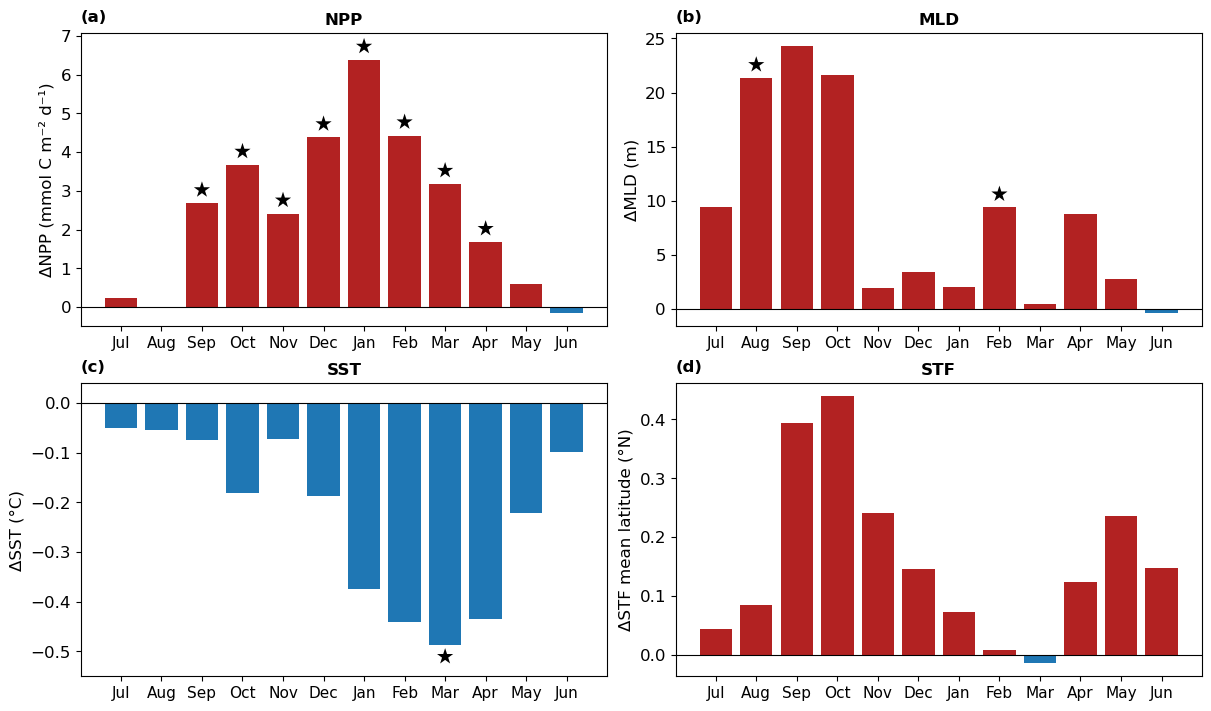

In [43]:
df = df_npp_totalyearsonly_bootstrap
#df = df_class_specific_bootstrap

#driver_vars =  ['MLD', 'SST', 'STF', 'NO3', 'Si', 'Fe', 'O2', 'Microzoop', 'Mesozoop', 'Remin_Fe']
group_vars = group_vars = ['NPP','Biomass','Chlorophyll', 'Clearance', 'Graz_pressure', 'NGL_pressure', 'μ_max', 'LFe','LN', 'Llight', 'μ']

driver_vars =  ['NPP', 'MLD', 'SST', 'STF']

# Map groups and colors mapping
#npp_keys = ['ppphyn', 'ppphyp', 'ppphyd', 'pp_total'] 
#colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:purple']

npp_keys = ['pp_total'] 
colors = ['tab:blue']

color_map = dict(zip(npp_keys, colors))

signif_threshold = 0.05
groups = npp_keys  # since npp_keys are groups
variables = df['variable'].unique()  # plot all variables found in df

bar_width = 0.8 / len(groups)
months_orig = np.arange(1, 13)

def circshift_months(df_var, shift=6):
    shifted_months = ((months_orig - 1 + shift) % 12) + 1
    month_map = dict(zip(months_orig, shifted_months))
    df_var = df_var.copy()
    df_var['month_shifted'] = df_var['month'].map(month_map)
    return df_var.sort_values('month_shifted')

units_map = {
    'NPP': 'ΔNPP (mmol C m⁻² d⁻¹)',
    'MLD': 'ΔMLD (m)',
    'SST': 'ΔSST (°C)',
    'STF': 'ΔSTF mean latitude (°N)',
    'NO3': 'ΔNO3 inventory (mmol m⁻²)',
    'Si': 'ΔSi inventory (mmol m⁻²)',
    'Fe': 'ΔDFe inventory (mmol m⁻²)',
    'O2': 'ΔOxygen inventory (mmol m⁻²)',
    'Microzoop': 'ΔMicrozooplankton biomass (mmol m⁻²)',
    'Mesozoop': 'ΔMesozooplankton biomass (mmol m⁻²)'
}


fig, axs = plt.subplots(2, 2, figsize=(12, 7), constrained_layout=True)
axs = axs.flatten()

for i, var_to_plot in enumerate(driver_vars):
    ax = axs[i]
    df_var = df[df['variable'] == var_to_plot]
    df_var = circshift_months(df_var, shift=6)
    x = np.arange(1, 13)

    for j, group in enumerate(groups):
        group_data = df_var[df_var['group'] == group].sort_values('month_shifted')
        if group_data.empty:
            continue
        positions = x - 0.4 + j * bar_width + bar_width / 2

        for pos, (_, row) in zip(positions, group_data.iterrows()):
            val = row['delta_obs']
            color = 'firebrick' if val >= 0 else 'tab:blue'

            # Bar
            ax.bar(
                pos,
                val,
                width=bar_width,
                label=group if i == 0 and pos == positions[0] else "",
                color=color,
                edgecolor='none'
            )

            # Significance star
            if row['p_val'] < signif_threshold:
                offset = 0.05 * max(abs(df_var['delta_obs']))
                star_y = val + (offset if val >= 0 else -offset)
                ax.scatter(
                    pos, star_y, marker='*', s=150,
                    color='k', edgecolors='none', linewidth=0.8
                )


    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'], fontsize = 11)
    #ax.set_xlabel('Month')
    ax.set_ylabel(units_map.get(var_to_plot, f'Δ {var_to_plot}'), fontsize = 12)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_title(var_to_plot, fontweight='bold')

axs[2].set_ylim([-0.55, 0.04])    
    
# Remove empty subplots if any
for k in range(len(variables), len(axs)):
    fig.delaxes(axs[k])

    # Panel labels
panel_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']

for label, ax in zip(panel_labels, axs):
    ax.text(
        0, 1.08, f'({label})',
        transform=ax.transAxes,
        fontsize=12,
        fontweight='bold',
        va='top',
        ha='left'
    )
    
#handles, labels = axs[0].get_legend_handles_labels()
#fig.legend(handles, labels, title='Max-Min NPP years grouping', title_fontsize = 16, loc='upper center', ncol = 2, fontsize = 16, bbox_to_anchor=(0.85, 0.2))

plt.show()


### Figure 4 e - f

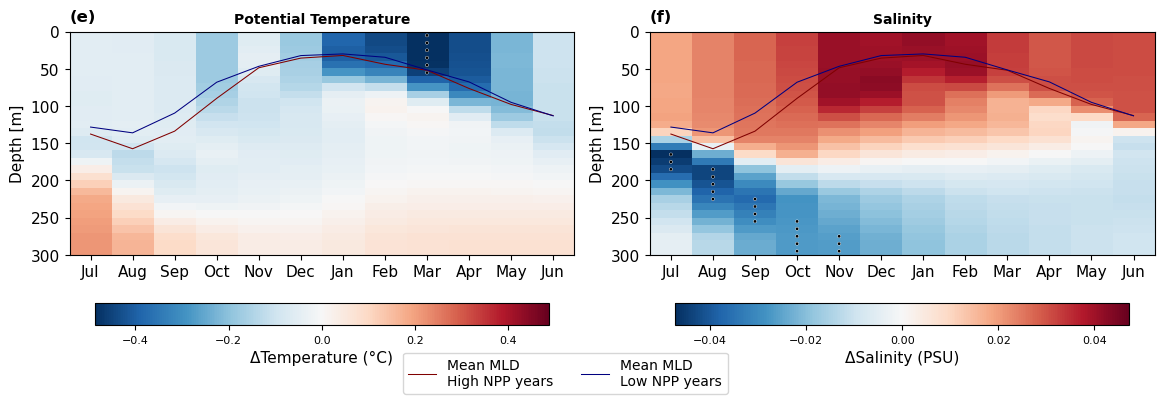

In [48]:
phys_vars = ['thetao', 'so']
varname_map_phys = {'thetao': 'pp_total',
                    'so': 'pp_total'}

######################## Select Plotting vars ########################
#Integrated variable group handles: ['Biomass', 'Fe', 'LFe', 'Llight', 'MLD', 'Mesozoop', 'Microzoop',
#       'NO3', 'NPP', 'O2', 'SST', 'STF', 'Si', 'μ', 'μ_max']
#selected_vars = ['Fer', 'NO3', 'Si', 'O2'] # ['ppphyn', 'ppphyd', 'ppphyp', 'pp_total']
#selected_keys = ['Fe', 'NO3', 'Si', 'O2']
#varname_map = varname_map_nuts

selected_vars = phys_vars # ['ppphyn', 'ppphyd', 'ppphyp', 'pp_total']
selected_keys =  ['thetao', 'so'] #Fe', 'NO3', 'Si', 'O2']
varname_map = varname_map_phys

units_map = {'thetao': 'ΔTemperature (°C)',
             'so': 'ΔSalinity (PSU)'}
titles = {'thetao': 'Potential Temperature', 
          'so':'Salinity'}
########################################################################
    
p_threshold = 0.05
cmap = 'RdBu_r'
bar_colors = {'ppphyn': 'tab:red',
 'ppphyp': 'tab:blue',
 'ppphyd': 'tab:green',
 'pp_total': 'tab:purple'}  # defined earlier: maps var name to color

fig = plt.figure(figsize=(14, 10))
# Top-level GridSpec: 2 rows (each group of 2 rows from original), 2 columns
# Make the vertical gap larger by setting height_ratios, with extra space between groups
outer_gs = gridspec.GridSpec(2, 2, height_ratios=[4, 4], hspace=0.3, wspace = 0.15)  # hspace here controls vertical gap between groups

month_labels = np.roll(np.arange(1, 13), -6)
months_native = np.arange(1, 13)
month_names = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
bar_width = 0.6

selected_im = None
bar_axes = []
depth_axes = []

for i, (varname, selected_key) in enumerate(zip(selected_vars, selected_keys)):
    group_row = i // 2
    col = i % 2

    inner_gs = gridspec.GridSpecFromSubplotSpec(
        2, 1,
        subplot_spec=outer_gs[group_row, col],
        height_ratios=[0, 3],
        hspace=0.1
    )

    #ax_bar = fig.add_subplot(inner_gs[0])
    ax_depth = fig.add_subplot(inner_gs[1])

    #bar_axes.append(ax_bar)
    depth_axes.append(ax_depth)

    # Extract and map group name
    df_var = df[df['variable'] == selected_key].copy()
    df_var = circshift_months(df_var, shift=6)

    group_name = varname_map[varname]  # <--- select corresponding varname_map 
    df_var = df_var[df_var['group'] == group_name]
    '''
    posneg_colors = ['firebrick' if val > 0 else 'tab:blue' for val in df_var['delta_obs']] # Turn off for coloration by phytoclass instead of +/-

    ax_bar.bar(
        df_var['month_shifted'],
        df_var['delta_obs'],
        #color=bar_colors.get(group_name, 'grey'),
        color=posneg_colors,# update here too if color map uses group names
        width=bar_width
    )

    # Significance stars
    for _, row in df_var.iterrows():
        if row['p_val'] < p_threshold:
            offset = 0.05 * max(abs(df_var['delta_obs']))
            star_y = row['delta_obs'] + (offset if row['delta_obs'] >= 0 else -offset)
            ax_bar.plot(row['month_shifted'], star_y, marker='*', color='k', markersize=8)

    ax_bar.axhline(0, color='black', linewidth=0.8)
    ax_bar.set_xticks([])
    ax_bar.spines[['bottom', 'right', 'top']].set_visible(False)
    ax_bar.set_xticklabels('')
    ax_bar.set_xlim(0.5, 12.5)

    ax_bar.set_ylabel(f'Δ∫{selected_key}\n[mmol m⁻² d⁻¹]', fontsize=11)   # molC m⁻³ d⁻¹ m⁻² mmol m⁻²
    ax_bar.set_title(varname, fontsize=10, fontweight='bold')
    '''
    # Depth plot
    delta = results_dict[varname]['delta_obs']
    pval = results_dict[varname]['p_val']

    data = np.roll(delta.values.T, shift=-6, axis=1)
    pvals = np.roll(pval.values.T, shift=-6, axis=1)

    vlim = np.nanmax(np.abs(data))
    im = ax_depth.imshow(
        data, aspect='auto', origin='upper',
        extent=[0.5, 12.5, 300, 0],
        cmap=cmap, vmin=-vlim, vmax=vlim
    )
    if selected_im is None:
        selected_im = im
        
    cbar = fig.colorbar(im, ax=ax_depth, orientation='horizontal', pad=0.15, shrink=0.9)
    cbar.set_label(units_map.get(varname, f'Δ{selected_key} ({varname})'), fontsize=11)
    cbar.ax.tick_params(labelsize=8)

    nonsig_mask = pvals <= p_threshold
    y_stipple, x_stipple = np.where(nonsig_mask)
    ax_depth.plot(months_native[x_stipple], delta['depth'].values[y_stipple]+5, 'k.', markersize=2, path_effects=[pe.withStroke(linewidth=1.5, foreground='white')])

    # MLD overlay
    ax_depth.plot(month_labels_mld, mld_high_years_clim_shifted, linestyle='-', linewidth=0.75, color='maroon', label='Mean MLD \nHigh NPP years')
    ax_depth.plot(month_labels_mld, mld_low_years_clim_shifted, linestyle='-', linewidth=0.75, color='navy', label='Mean MLD \nLow NPP years')

    ax_depth.set_xticks(np.arange(1, 13))
    ax_depth.set_xticklabels(month_names, fontsize=11)
    ax_depth.set_yticks([0, 50, 100, 150, 200, 250, 300])
    ax_depth.set_yticklabels([0, 50, 100, 150, 200, 250, 300], fontsize = 11)
    ax_depth.set_ylabel('Depth [m]', fontsize = 11)
    ax_depth.set_title(titles.get(varname), fontsize=10, fontweight='bold')

# Legend and colorbar
handles, labels = depth_axes[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, bbox_to_anchor=(0.6, 0.55), fontsize=10)

# Panel labels
panel_labels = ['e', 'f']

for label, ax in zip(panel_labels, depth_axes):
    ax.text(
        0, 1.1, f'({label})',
        transform=ax.transAxes,
        fontsize=12,
        fontweight='bold',
        va='top',
        ha='left'
    )

#plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

### Figure 5 a - d

/var/folders/dk/4pyn7w4102bfzscb0m9606zw0000gn/T/ipykernel_9606/3823224263.py:163: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


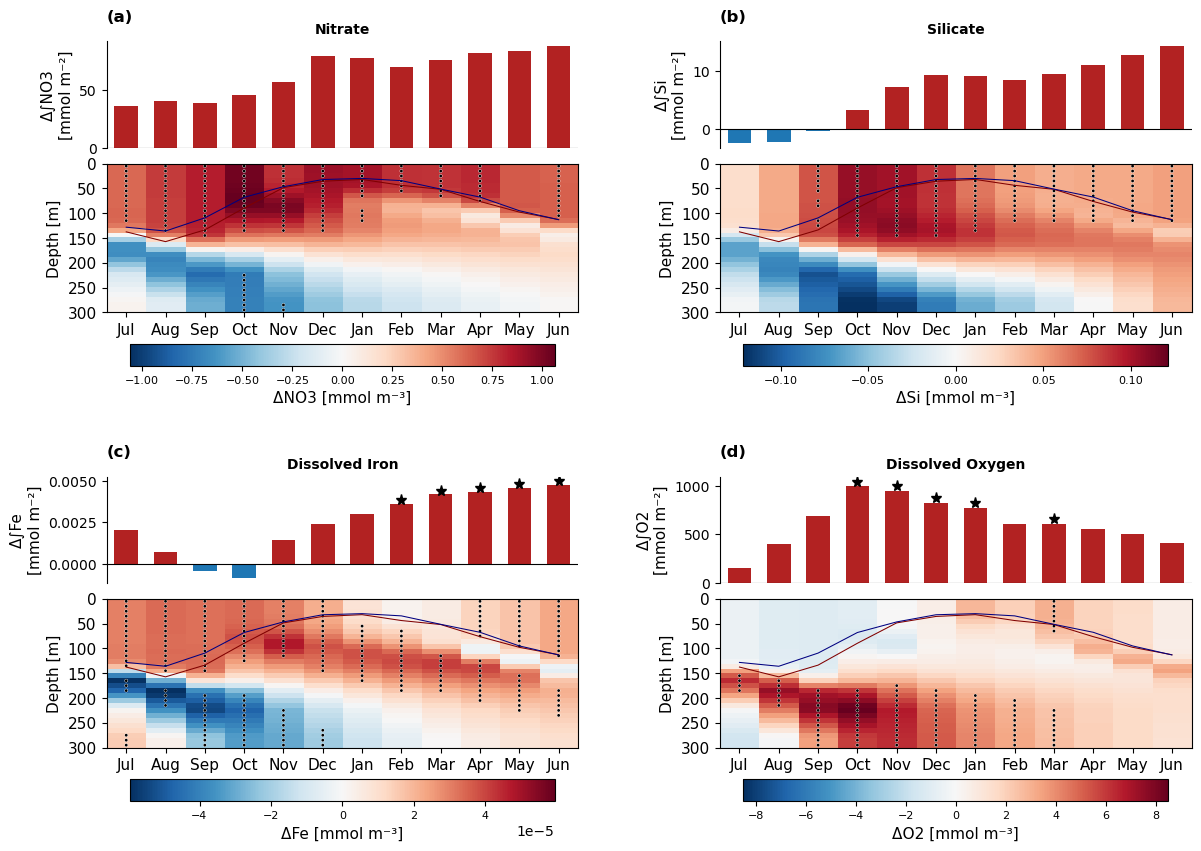

In [46]:
results_dict = depth_bootstrap_results

nuts_vars = ['NO3', 'Si', 'Fer', 'O2']
zoop_vars = ['microzoop_conc', 'mesozoop_conc']
phys_vars = ['thetao', 'so']

varname_map_nuts = {
    'Fer': 'pp_total',
    'NO3': 'pp_total',
    'Si': 'pp_total',
    'O2': 'pp_total'}

titles = {
    'Fer': 'Dissolved Iron',
    'NO3': 'Nitrate',
    'Si': 'Silicate',
    'O2': 'Dissolved Oxygen'}

varname_map_zoop = {
    'microzoop_conc': 'pp_total',
    'mesozoop_conc': 'pp_total',
}

varname_map_phys = {'Remin_Fe': 'pp_total'}
varname_map_phys = {'thetao': 'pp_total',
                    'so': 'pp_total'}

######################## Select Plotting vars ########################
#Integrated variable group handles: ['Biomass', 'Fe', 'LFe', 'Llight', 'MLD', 'Mesozoop', 'Microzoop',
#       'NO3', 'NPP', 'O2', 'SST', 'STF', 'Si', 'μ', 'μ_max']
#selected_vars = ['Fer', 'NO3', 'Si', 'O2'] # ['ppphyn', 'ppphyd', 'ppphyp', 'pp_total']
#selected_keys = ['Fe', 'NO3', 'Si', 'O2']
#varname_map = varname_map_nuts

selected_vars = nuts_vars # ['ppphyn', 'ppphyd', 'ppphyp', 'pp_total']
selected_keys =  ['NO3', 'Si','Fe', 'O2']
varname_map = varname_map_nuts

########################################################################
    
p_threshold = 0.05
cmap = 'RdBu_r'
bar_colors = {'ppphyn': 'tab:red',
 'ppphyp': 'tab:blue',
 'ppphyd': 'tab:green',
 'pp_total': 'tab:purple'}  # defined earlier: maps var name to color

fig = plt.figure(figsize=(14, 10))
# Top-level GridSpec: 2 rows (each group of 2 rows from original), 2 columns
# Make the vertical gap larger by setting height_ratios, with extra space between groups
outer_gs = gridspec.GridSpec(2, 2, height_ratios=[4, 4], hspace=0.3, wspace = 0.3)  # hspace here controls vertical gap between groups

month_labels = np.roll(np.arange(1, 13), -6)
months_native = np.arange(1, 13)
month_names = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
bar_width = 0.6

selected_im = None
bar_axes = []
depth_axes = []

for i, (varname, selected_key) in enumerate(zip(selected_vars, selected_keys)):
    group_row = i // 2
    col = i % 2

    inner_gs = gridspec.GridSpecFromSubplotSpec(
        2, 1,
        subplot_spec=outer_gs[group_row, col],
        height_ratios=[1.5, 3],
        hspace=0.1
    )

    ax_bar = fig.add_subplot(inner_gs[0])
    ax_depth = fig.add_subplot(inner_gs[1])

    bar_axes.append(ax_bar)
    depth_axes.append(ax_depth)

    # Extract and map group name
    df_var = df[df['variable'] == selected_key].copy()
    df_var = circshift_months(df_var, shift=6)

    group_name = varname_map[varname]  # <--- select corresponding varname_map 
    df_var = df_var[df_var['group'] == group_name]

    posneg_colors = ['firebrick' if val > 0 else 'tab:blue' for val in df_var['delta_obs']] # Turn off for coloration by phytoclass instead of +/-

    ax_bar.bar(
        df_var['month_shifted'],
        df_var['delta_obs'],
        color=posneg_colors,# update here too if color map uses group names
        width=bar_width
    )

    # Significance stars
    for _, row in df_var.iterrows():
        if row['p_val'] < p_threshold:
            offset = 0.05 * max(abs(df_var['delta_obs']))
            star_y = row['delta_obs'] + (offset if row['delta_obs'] >= 0 else -offset)
            ax_bar.plot(row['month_shifted'], star_y, marker='*', color='k', markersize=8)

    ax_bar.axhline(0, color='black', linewidth=0.8)
    ax_bar.set_xticks([])
    ax_bar.spines[['bottom', 'right', 'top']].set_visible(False)
    ax_bar.set_xticklabels('')
    ax_bar.set_xlim(0.5, 12.5)

    ax_bar.set_ylabel(f'Δ∫{selected_key}\n[mmol m⁻²]', fontsize=11)   # molC m⁻³ d⁻¹ m⁻² mmol m⁻²
    ax_bar.set_title(titles.get(varname), fontsize=10, fontweight='bold')

    # Depth plot
    delta = results_dict[varname]['delta_obs']
    pval = results_dict[varname]['p_val']

    data = np.roll(delta.values.T, shift=-6, axis=1)
    pvals = np.roll(pval.values.T, shift=-6, axis=1)

    vlim = np.nanmax(np.abs(data))
    im = ax_depth.imshow(
        data, aspect='auto', origin='upper',
        extent=[0.5, 12.5, 300, 0],
        cmap=cmap, vmin=-vlim, vmax=vlim
    )
    if selected_im is None:
        selected_im = im
        
    cbar = fig.colorbar(im, ax=ax_depth, orientation='horizontal', pad=0.15, shrink=0.9)
    cbar.set_label(f'Δ{selected_key} [mmol m⁻³]', fontsize=11)
    cbar.ax.tick_params(labelsize=8)

    nonsig_mask = pvals <= p_threshold
    y_stipple, x_stipple = np.where(nonsig_mask)
    ax_depth.plot(months_native[x_stipple], delta['depth'].values[y_stipple]+5, 'k.', markersize=2, path_effects=[pe.withStroke(linewidth=1.5, foreground='white')])

    # MLD overlay
    ax_depth.plot(month_labels_mld, mld_high_years_clim_shifted, linestyle='-', linewidth=0.75, color='maroon', label='Mean MLD \nHigh NPP years')
    ax_depth.plot(month_labels_mld, mld_low_years_clim_shifted, linestyle='-', linewidth=0.75, color='navy', label='Mean MLD \nLow NPP years')

    ax_depth.set_xticks(np.arange(1, 13))
    ax_depth.set_xticklabels(month_names, fontsize=11)
    ax_depth.set_yticks([0, 50, 100, 150, 200, 250, 300])
    ax_depth.set_yticklabels([0, 50, 100, 150, 200, 250, 300], fontsize = 11)
    ax_depth.set_ylabel('Depth [m]', fontsize = 11)
    #ax_depth.set_title(varname, fontsize=10, fontweight='bold')

# Legend and colorbar
handles, labels = depth_axes[0].get_legend_handles_labels()
#fig.legend(handles, labels, ncol=2, bbox_to_anchor=(0.6, 0.1), fontsize=10)

# Panel labels
panel_labels = ['a', 'b', 'c', 'd']

for label, ax in zip(panel_labels, bar_axes):
    ax.text(
        0, 1.3, f'({label})',
        transform=ax.transAxes,
        fontsize=12,
        fontweight='bold',
        va='top',
        ha='left'
    )

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

### Figure 5 e

/var/folders/dk/4pyn7w4102bfzscb0m9606zw0000gn/T/ipykernel_9606/985108849.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


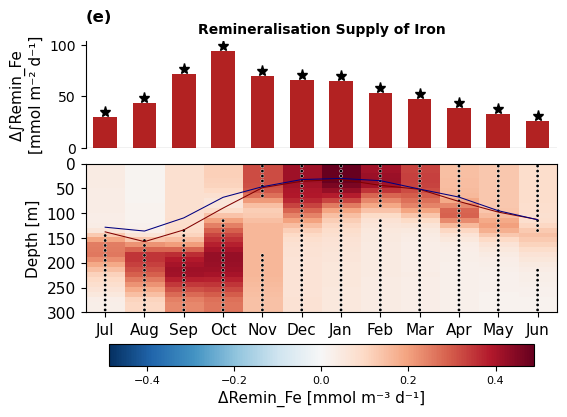

In [47]:
prod_vars = ['ppphyn', 'ppphyd', 'ppphyp', 'pp_total']
conc_vars = ['phyn_conc', 'phyd_conc', 'phyp_conc', 'phy_conc_total']
lfe_vars = ['LNFe', 'LDFe', 'LPFe', 'L_Fe']
lN_vars = ['LNN', 'LDN', 'LPN', 'L_N']
llight_vars = ['LNlight', 'LDlight', 'LPlight', 'L_light']
mu_max_vars = ['μ_N_max', 'μ_D_max', 'μ_P_max', 'μ_tot_max']
mu_vars = ['mu_n','mu_d','mu_p','mu_tot']
nuts_vars = ['Fer', 'NO3', 'Si', 'O2']
zoop_vars = ['microzoop', 'mesozoop']
clearance_vars = ['clearance_n', 'clearance_d', 'clearance_p', 'clearance_total']
gr_pres_vars = ['GSP_n_pressure','GSP_d_pressure','GSP_p_pressure','GSP_pressure']
chl_vars = ['chl_n', 'chl_d', 'chl_p', 'chl_total']
ngl_vars = ['NGL_n_pressure', 'NGL_d_pressure', 'NGL_p_pressure', 'NGL_pressure']


mech_vars = ['L_Fe', 'L_N', 'L_light', 'mu_tot', 'μ_tot_max', 'GSP_pressure']
zoop_vars = ['microzoop_conc', 'mesozoop_conc']
phys_vars = ['thetao', 'so']

varname_map_nuts = {
    'Fer': 'pp_total',
    'NO3': 'pp_total',
    'Si': 'pp_total',
    'O2': 'pp_total'}

varname_map_zoop = {
    'microzoop_conc': 'pp_total',
    'mesozoop_conc': 'pp_total',
}

varname_map_phys = {'Remin_Fe': 'pp_total'}
#varname_map_phys = {'thetao': 'pp_total',
#                    'so': 'pp_total'}

######################## Select Plotting vars ########################
#Integrated variable group handles: ['Biomass', 'Fe', 'LFe', 'Llight', 'MLD', 'Mesozoop', 'Microzoop',
#       'NO3', 'NPP', 'O2', 'SST', 'STF', 'Si', 'μ', 'μ_max']
#selected_vars = ['Fer', 'NO3', 'Si', 'O2'] # ['ppphyn', 'ppphyd', 'ppphyp', 'pp_total']
#selected_keys = ['Fe', 'NO3', 'Si', 'O2']
#varname_map = varname_map_nuts

selected_vars = ['Remin_Fe'] # ['ppphyn', 'ppphyd', 'ppphyp', 'pp_total']
selected_keys =  ['Remin_Fe'] #Fe', 'NO3', 'Si', 'O2']
varname_map = varname_map_phys

units_map = {'thetao': 'Temperature (°C)',
             'so': 'Salinity (PSU)'}
########################################################################
    
p_threshold = 0.05
cmap = 'RdBu_r'
bar_colors = {'ppphyn': 'tab:red',
 'ppphyp': 'tab:blue',
 'ppphyd': 'tab:green',
 'pp_total': 'tab:purple'}  # defined earlier: maps var name to color

fig = plt.figure(figsize=(14, 10))
# Top-level GridSpec: 2 rows (each group of 2 rows from original), 2 columns
# Make the vertical gap larger by setting height_ratios, with extra space between groups
outer_gs = gridspec.GridSpec(2, 2, height_ratios=[4, 4], hspace=0.3, wspace = 0.3)  # hspace here controls vertical gap between groups

month_labels = np.roll(np.arange(1, 13), -6)
months_native = np.arange(1, 13)
month_names = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
bar_width = 0.6

selected_im = None
bar_axes = []
depth_axes = []

for i, (varname, selected_key) in enumerate(zip(selected_vars, selected_keys)):
    group_row = i // 2
    col = i % 2

    inner_gs = gridspec.GridSpecFromSubplotSpec(
        2, 1,
        subplot_spec=outer_gs[group_row, col],
        height_ratios=[1.5, 3],
        hspace=0.1
    )

    ax_bar = fig.add_subplot(inner_gs[0])
    ax_depth = fig.add_subplot(inner_gs[1])

    bar_axes.append(ax_bar)
    depth_axes.append(ax_depth)

    # Extract and map group name
    df_var = df[df['variable'] == selected_key].copy()
    df_var = circshift_months(df_var, shift=6)

    group_name = varname_map[varname]  # <--- select corresponding varname_map 
    df_var = df_var[df_var['group'] == group_name]

    posneg_colors = ['firebrick' if val > 0 else 'tab:blue' for val in df_var['delta_obs']] # Turn off for coloration by phytoclass instead of +/-

    ax_bar.bar(
        df_var['month_shifted'],
        df_var['delta_obs'],
        #color=bar_colors.get(group_name, 'grey'),
        color=posneg_colors,# update here too if color map uses group names
        width=bar_width
    )

    # Significance stars
    for _, row in df_var.iterrows():
        if row['p_val'] < p_threshold:
            offset = 0.05 * max(abs(df_var['delta_obs']))
            star_y = row['delta_obs'] + (offset if row['delta_obs'] >= 0 else -offset)
            ax_bar.plot(row['month_shifted'], star_y, marker='*', color='k', markersize=8)

    ax_bar.axhline(0, color='black', linewidth=0.8)
    ax_bar.set_xticks([])
    ax_bar.spines[['bottom', 'right', 'top']].set_visible(False)
    ax_bar.set_xticklabels('')
    ax_bar.set_xlim(0.5, 12.5)

    ax_bar.set_ylabel(f'Δ∫{selected_key}\n[mmol m⁻² d⁻¹]', fontsize=11)   # molC m⁻³ d⁻¹ m⁻² mmol m⁻²
    ax_bar.set_title('Remineralisation Supply of Iron', fontsize=10, fontweight='bold')

    # Depth plot
    delta = results_dict[varname]['delta_obs']
    pval = results_dict[varname]['p_val']

    data = np.roll(delta.values.T, shift=-6, axis=1)
    pvals = np.roll(pval.values.T, shift=-6, axis=1)

    vlim = np.nanmax(np.abs(data))
    im = ax_depth.imshow(
        data, aspect='auto', origin='upper',
        extent=[0.5, 12.5, 300, 0],
        cmap=cmap, vmin=-vlim, vmax=vlim
    )
    if selected_im is None:
        selected_im = im
        
    cbar = fig.colorbar(im, ax=ax_depth, orientation='horizontal', pad=0.15, shrink=0.9)
    #cbar.set_label(f'Δ{selected_key} []', fontsize=11) # mmol m⁻³
    cbar.set_label(f'Δ{selected_key} [mmol m⁻³ d⁻¹]', fontsize=11)
    #cbar.set_label(units_map.get(varname, f'Δ{selected_key} ({varname})'), fontsize=11)
    cbar.ax.tick_params(labelsize=8)

    nonsig_mask = pvals <= p_threshold
    y_stipple, x_stipple = np.where(nonsig_mask)
    ax_depth.plot(months_native[x_stipple], delta['depth'].values[y_stipple]+5, 'k.', markersize=2, path_effects=[pe.withStroke(linewidth=1.5, foreground='white')])

    # MLD overlay
    ax_depth.plot(month_labels_mld, mld_high_years_clim_shifted, linestyle='-', linewidth=0.75, color='maroon', label='Mean MLD \nHigh NPP years')
    ax_depth.plot(month_labels_mld, mld_low_years_clim_shifted, linestyle='-', linewidth=0.75, color='navy', label='Mean MLD \nLow NPP years')

    ax_depth.set_xticks(np.arange(1, 13))
    ax_depth.set_xticklabels(month_names, fontsize=11)
    ax_depth.set_yticks([0, 50, 100, 150, 200, 250, 300])
    ax_depth.set_yticklabels([0, 50, 100, 150, 200, 250, 300], fontsize = 11)
    ax_depth.set_ylabel('Depth [m]', fontsize = 11)
    #ax_depth.set_title(varname, fontsize=10, fontweight='bold')

# Legend and colorbar
handles, labels = depth_axes[0].get_legend_handles_labels()
#fig.legend(handles, labels, ncol=2, bbox_to_anchor=(0.6, 0.1), fontsize=10)

# Panel labels
panel_labels = ['e', 'f', 'c', 'd']

for label, ax in zip(panel_labels, bar_axes):
    ax.text(
        0, 1.3, f'({label})',
        transform=ax.transAxes,
        fontsize=12,
        fontweight='bold',
        va='top',
        ha='left'
    )

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

### Figure 6: BWDA Diagnostics for each phyto. class

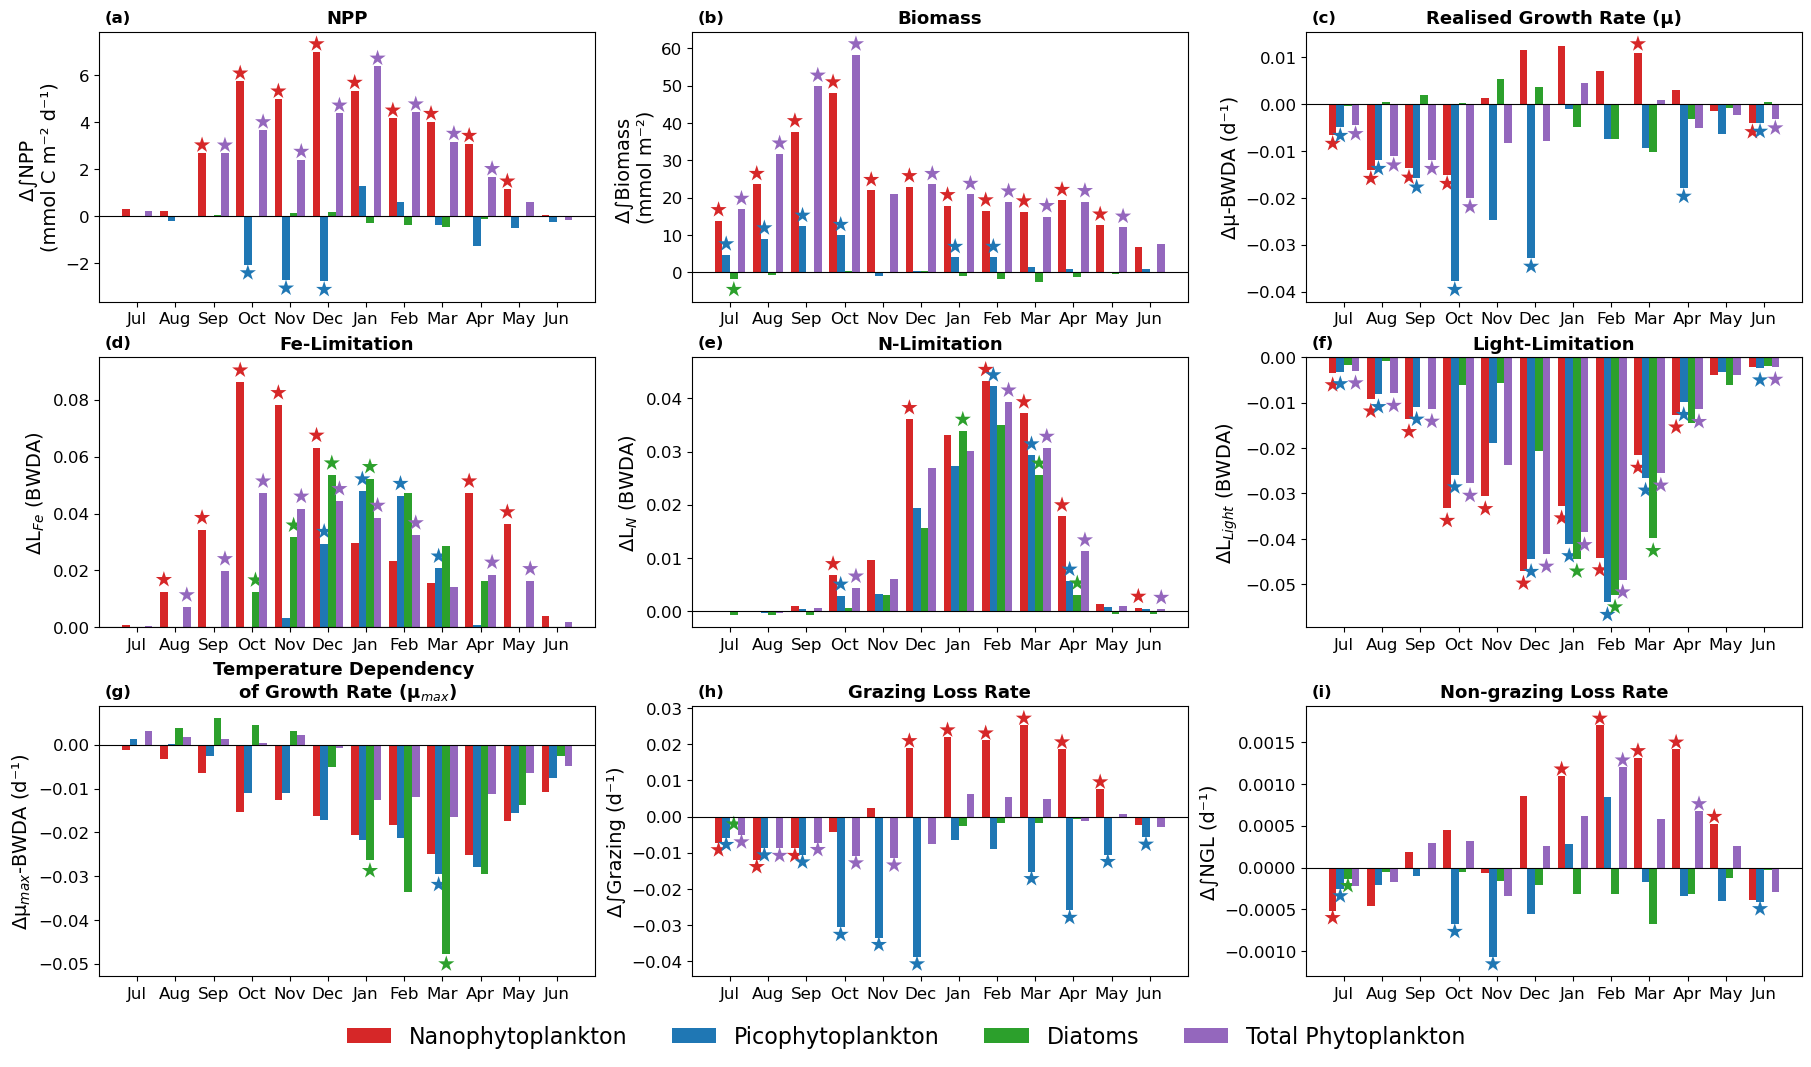

In [49]:
df = df_npp_totalyearsonly_bootstrap

driver_vars = ['MLD', 'SST', 'STF', 'NO3', 'Si', 'Fe', 'O2', 'Microzoop', 'Mesozoop', 'Remin_Fe']
group_vars = ['NPP','Biomass','μ', 'LFe','LN', 'Llight','μ_max', 'Graz_pressure', 'NGL_pressure'] 

group_vars_titles = {'NPP':'NPP',
                     'Biomass':'Biomass',
                     'μ':'Realised Growth Rate (μ)', 
                     'LFe':'Fe-Limitation',
                     'LN':'N-Limitation', 
                     'Llight':'Light-Limitation',
                     'μ_max':'Temperature Dependency \nof Growth Rate (μ$_{max}$)', 
                     'Graz_pressure' :'Grazing Loss Rate', 
                     'NGL_pressure' :'Non-grazing Loss Rate'}

# Map groups and colors mapping
npp_keys = ['ppphyn', 'ppphyp', 'ppphyd', 'pp_total'] 
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:purple']
color_map = dict(zip(npp_keys, colors))

signif_threshold = 0.05
groups = npp_keys  # since npp_keys are groups
variables = df['variable'].unique()  # plot all variables found in df

bar_width = 0.8 / len(groups)
months_orig = np.arange(1, 13)

def circshift_months(df_var, shift=6):
    shifted_months = ((months_orig - 1 + shift) % 12) + 1
    month_map = dict(zip(months_orig, shifted_months))
    df_var = df_var.copy()
    df_var['month_shifted'] = df_var['month'].map(month_map)
    return df_var.sort_values('month_shifted')

units_map = {
    'NPP': 'ΔNPP (mmol C m⁻² d⁻¹)',
    'Biomass': 'ΔBiomass (mmol m⁻²)',
    'μ': 'Δμ (d⁻¹)',
    'μ_max': 'Δμ$_{max}$ (d⁻¹)',
    'LFe': 'ΔL$_{Fe}$',
    'LN': 'ΔL$_{N}$',
    'Llight': 'ΔL$_{Light}$',
    'Clearance': 'ΔClearance rate (m⁻² mmol⁻¹ d⁻¹)',
    'Graz_pressure': 'ΔGrazing pressure (d⁻¹)',
    'NGL_pressure': 'ΔNGL pressure (d⁻¹)'
}

units_map = {'NPP': 'Δ∫NPP \n(mmol C m⁻² d⁻¹)',
                 'Biomass': 'Δ∫Biomass \n(mmol m⁻²)', 
                 'μ': 'Δμ-BWDA (d⁻¹)', 
                 'LFe': 'ΔL$_{Fe}$ (BWDA)', 
                 'LN': 'ΔL$_{N}$ (BWDA)', 
                 'Llight': 'ΔL$_{Light}$ (BWDA)', 
                 'μ_max': 'Δμ$_{max}$-BWDA (d⁻¹)', 
                 'Graz_pressure': 'Δ∫Grazing (d⁻¹)', 
                 'NGL_pressure': 'Δ∫NGL (d⁻¹)'
}

fig, axs = plt.subplots(3, 3, figsize=(18, 10), constrained_layout=True)
axs = axs.flatten()

for i, var_to_plot in enumerate(group_vars):
    ax = axs[i]
    df_var = df[df['variable'] == var_to_plot]
    df_var = circshift_months(df_var, shift=6)
    x = np.arange(1, 13)

    for j, group in enumerate(groups):
        group_data = df_var[df_var['group'] == group].sort_values('month_shifted')
        if group_data.empty:
            continue
        positions = x - 0.4 + j * bar_width + bar_width / 2

        color = color_map.get(group, 'grey')

        ax.bar(
            positions,
            group_data['delta_obs'],
            width=bar_width,
            label=group if i == 0 else "",
            color=color,
            edgecolor='none'
        )

        for pos, (_, row) in zip(positions, group_data.iterrows()):
            if row['p_val'] < signif_threshold:
                y = row['delta_obs']
                offset = 0.05 * max(abs(df_var['delta_obs']))
                star_y = y + (offset if y >= 0 else -offset)
                ax.scatter(
                    pos, star_y, marker='*', s=150,
                    color=color,
                    edgecolors='none', linewidth=0.8
                )

    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'], fontsize = 12)
    ax.set_ylabel(units_map.get(var_to_plot, f'Δ {var_to_plot}'), fontsize = 14)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_title(group_vars_titles.get(var_to_plot), fontsize=13, fontweight='bold')

# Remove empty subplots if any
for k in range(len(variables), len(axs)):
    fig.delaxes(axs[k])

# Panel labels
panel_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']

for label, ax in zip(panel_labels, axs):
    ax.text(
        0.01, 1.08, f'({label})',
        transform=ax.transAxes,
        fontsize=12,
        fontweight='bold',
        va='top',
        ha='left'
    )
    
group_labels = ['Nanophytoplankton', 'Picophytoplankton', 'Diatoms', 'Total Phytoplankton']
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, group_labels, title_fontsize = 16, loc='upper center', ncol = 4, fontsize = 16, bbox_to_anchor=(0.5, 0), edgecolor = 'none')

plt.show()

### Figure 7 (and Figures A1.3, A1.4 and A1.5) Plot total NPP subset depth resolved vars only. 

/var/folders/dk/4pyn7w4102bfzscb0m9606zw0000gn/T/ipykernel_9606/3248471205.py:270: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


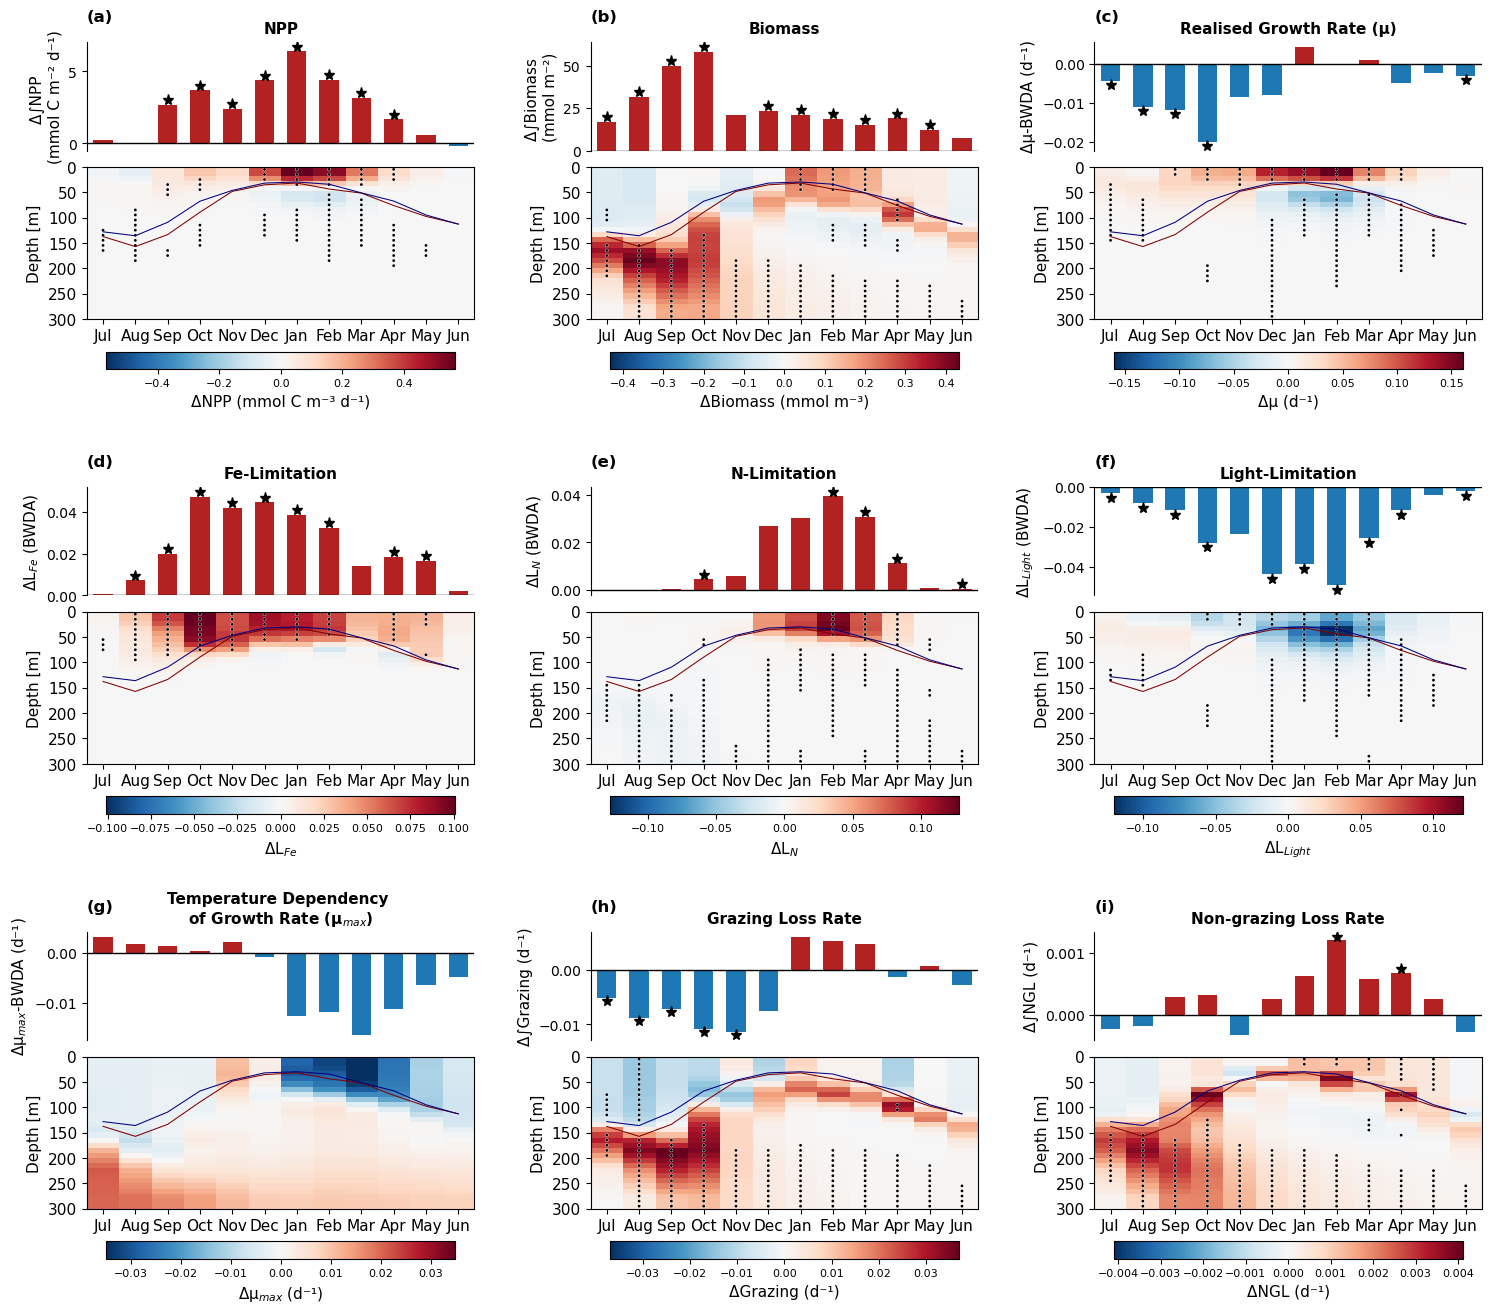

In [50]:
'''
## This is a list of all post-processed bootstrapepd variable handles that can be plotted in the style of Figure 7. 

prod_vars = ['ppphyn', 'ppphyd', 'ppphyp', 'pp_total']
conc_vars = ['phyn_conc', 'phyd_conc', 'phyp_conc', 'phy_conc_total']
lfe_vars = ['LNFe', 'LDFe', 'LPFe', 'L_Fe']
lN_vars = ['LNN', 'LDN', 'LPN', 'L_N']
llight_vars = ['LNlight', 'LDlight', 'LPlight', 'L_light']
mu_max_vars = ['μ_N_max', 'μ_D_max', 'μ_P_max', 'μ_tot_max']
mu_vars = ['mu_n','mu_d','mu_p','mu_tot']
nuts_vars = ['Fer', 'NO3', 'Si', 'O2']
zoop_vars = ['microzoop', 'mesozoop']
clearance_vars = ['clearance_n', 'clearance_d', 'clearance_p', 'clearance_total']
gr_pres_vars = ['GSP_n_pressure','GSP_d_pressure','GSP_p_pressure','GSP_pressure']
chl_vars = ['chl_n', 'chl_d', 'chl_p', 'chl_total']
ngl_vars = ['NGL_n_pressure', 'NGL_d_pressure', 'NGL_p_pressure', 'NGL_pressure']
'''

vars_total = ['pp_total', 'phy_conc_total', 'mu_tot_weighted', 'L_Fe_weighted', 'L_N_weighted', 'L_light_weighted', 'μ_tot_max_weighted', 'GSP_pressure', 'NGL_pressure']
vars_nano = ['ppphyn', 'phyn_conc', 'mu_n', 'LNFe', 'LNN', 'LNlight', 'μ_N_max', 'GSP_n_pressure', 'NGL_n_pressure']
vars_pico = ['ppphyp', 'phyp_conc', 'mu_p', 'LPFe', 'LPN', 'LPlight', 'μ_P_max', 'GSP_p_pressure', 'NGL_p_pressure']
vars_diatom = ['ppphyd', 'phyd_conc', 'mu_d', 'LDFe', 'LDN', 'LDlight', 'μ_D_max', 'GSP_d_pressure', 'NGL_d_pressure']

varname_map_totals = {
    'pp_total': 'pp_total',
    'phy_conc_total': 'pp_total',
    'mu_tot_weighted': 'pp_total',
    'L_Fe_weighted': 'pp_total',
    'L_N_weighted': 'pp_total',
    'L_light_weighted': 'pp_total',
    'μ_tot_max_weighted': 'pp_total', 
    'GSP_pressure': 'pp_total',
    'NGL_pressure': 'pp_total'}

varname_map_nano = {
    'ppphyn': 'ppphyn',
    'phyn_conc': 'ppphyn',
    'mu_n': 'ppphyn',
    'LNFe': 'ppphyn',
    'LNN': 'ppphyn',
    'LNlight': 'ppphyn',
    'μ_N_max': 'ppphyn', 
    'GSP_n_pressure': 'ppphyn',
    'NGL_n_pressure': 'ppphyn'}

varname_map_pico = {
    'ppphyp': 'ppphyp',
    'phyp_conc': 'ppphyp',
    'mu_p': 'ppphyp',
    'LPFe': 'ppphyp',
    'LPN': 'ppphyp',
    'LPlight': 'ppphyp',
    'μ_P_max': 'ppphyp', 
    'GSP_p_pressure': 'ppphyp',
    'NGL_p_pressure': 'ppphyp'}

varname_map_diat = {
    'ppphyd': 'ppphyd',
    'phyd_conc': 'ppphyd',
    'mu_d': 'ppphyd',
    'LDFe': 'ppphyd',
    'LDN': 'ppphyd',
    'LDlight': 'ppphyd',
    'μ_D_max': 'ppphyd', 
    'GSP_d_pressure': 'ppphyd',
    'NGL_d_pressure': 'ppphyd'}

######################## Select Plotting vars ########################
#Integrated variable group handles: ['NPP','Biomass','Chlorophyll', 'Clearance', 'Graz_pressure', 'NGL_pressure', 'μ_max', 'LFe','LN', 'Llight', 'μ']
#selected_vars = ['Fer', 'NO3', 'Si', 'O2'] # ['ppphyn', 'ppphyd', 'ppphyp', 'pp_total']
#selected_keys = ['Fe', 'NO3', 'Si', 'O2']
#varname_map = varname_map_nuts

selected_vars = vars_total #Choose one of: 'vars_total', 'vars_nano', 'vars_pico', 'vars_diat'
selected_keys =  ['NPP','Biomass', 'μ', 'LFe', 'LN', 'Llight', 'μ_max', 'Graz_pressure', 'NGL_pressure'] 
varname_map = varname_map_totals # Choose one of: 'varname_map_totals', 'varname_map_nano', 'varname_map_pico', 'varname_map_diat'

units_map = {
    'pp_total': 'ΔNPP (mmol C m⁻³ d⁻¹)',
    'phy_conc_total': 'ΔBiomass (mmol m⁻³)',
    'mu_tot_weighted': 'Δμ (d⁻¹)',
    'L_Fe_weighted': 'ΔL$_{Fe}$',
    'L_N_weighted': 'ΔL$_{N}$',
    'L_light_weighted': 'ΔL$_{Light}$',
    'μ_tot_max_weighted': 'Δμ$_{max}$ (d⁻¹)',   
    'GSP_pressure': 'ΔGrazing (d⁻¹)',
    'NGL_pressure': 'ΔNGL (d⁻¹)'
}

bar_units_map = {'pp_total': 'Δ∫NPP \n(mmol C m⁻² d⁻¹)',
                 'phy_conc_total': 'Δ∫Biomass \n(mmol m⁻²)', 
                 'mu_tot_weighted': 'Δμ-BWDA (d⁻¹)', 
                 'L_Fe_weighted': 'ΔL$_{Fe}$ (BWDA)', 
                 'L_N_weighted': 'ΔL$_{N}$ (BWDA)', 
                 'L_light_weighted': 'ΔL$_{Light}$ (BWDA)', 
                 'μ_tot_max_weighted': 'Δμ$_{max}$-BWDA (d⁻¹)', 
                 'GSP_pressure': 'Δ∫Grazing (d⁻¹)', 
                 'NGL_pressure': 'Δ∫NGL (d⁻¹)'
}

group_vars_titles = {'NPP':'NPP',
                     'Biomass':'Biomass',
                     'μ':'Realised Growth Rate (μ)', 
                     'LFe':'Fe-Limitation',
                     'LN':'N-Limitation', 
                     'Llight':'Light-Limitation',
                     'μ_max':'Temperature Dependency \nof Growth Rate (μ$_{max}$)', 
                     'Graz_pressure' :'Grazing Loss Rate', 
                     'NGL_pressure' :'Non-grazing Loss Rate'}
'''
units_map = {
    'ppphyn': 'ΔNPP (mmol C m⁻³ d⁻¹)',
    'phyn_conc': 'ΔBiomass (mmol m⁻³)',
    'mu_n': 'Δμ (d⁻¹)',
    'LNFe': 'ΔLFe',
    'LNN': 'ΔLN',
    'LNlight': 'ΔLlight',
    'μ_N_max': 'Δμ_max (d⁻¹)',   
    'GSP_n_pressure': 'ΔGrazing pressure (d⁻¹)',
    'NGL_n_pressure': 'ΔNGL (d⁻¹)'
}

units_map = {
    'ppphyp': 'ΔNPP (mmol C m⁻³ d⁻¹)',
    'phyp_conc': 'ΔBiomass (mmol m⁻³)',
    'mu_p': 'Δμ (d⁻¹)',
    'LPFe': 'ΔLFe',
    'LPN': 'ΔLN',
    'LPlight': 'ΔLlight',
    'μ_P_max': 'Δμ_max (d⁻¹)',   
    'GSP_p_pressure': 'ΔGrazing pressure (d⁻¹)',
    'NGL_p_pressure': 'ΔNGL (d⁻¹)'
}

units_map = {
    'ppphyd': 'ΔNPP (mmol C m⁻³ d⁻¹)',
    'phyd_conc': 'ΔBiomass (mmol m⁻³)',
    'mu_d': 'Δμ (d⁻¹)',
    'LDFe': 'ΔLFe',
    'LDN': 'ΔLN',
    'LDlight': 'ΔLlight',
    'μ_D_max': 'Δμ_max (d⁻¹)',   
    'GSP_d_pressure': 'ΔGrazing pressure (d⁻¹)',
    'NGL_d_pressure': 'ΔNGL (d⁻¹)'
}
'''
########################################################################
p_threshold = 0.05
cmap = 'RdBu_r'

fig = plt.figure(figsize=(18, 16))
# Top-level GridSpec: 2 rows (each group of 2 rows from original), 2 columns
# Make the vertical gap larger by setting height_ratios, with extra space between groups
outer_gs = gridspec.GridSpec(3, 3, hspace=0.3, wspace=0.3) # hspace here controls vertical gap between groups

month_labels = np.roll(np.arange(1, 13), -6)
months_native = np.arange(1, 13)
month_names = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
bar_width = 0.6

selected_im = None
bar_axes = []
depth_axes = []

for i, (varname, selected_key) in enumerate(zip(selected_vars, selected_keys)):
    group_row = i // 3
    col = i % 3

    inner_gs = gridspec.GridSpecFromSubplotSpec(
        2, 1,
        subplot_spec=outer_gs[group_row, col],
        height_ratios=[1.5, 3],
        hspace=0.1
    )

    ax_bar = fig.add_subplot(inner_gs[0])
    ax_depth = fig.add_subplot(inner_gs[1])

    bar_axes.append(ax_bar)
    depth_axes.append(ax_depth)

    # Extract and map group name
    df_var = df[df['variable'] == selected_key].copy()
    df_var = circshift_months(df_var, shift=6)

    group_name = varname_map[varname]  # <--- select corresponding varname_map 
    df_var = df_var[df_var['group'] == group_name]

    posneg_colors = ['firebrick' if val > 0 else 'tab:blue' for val in df_var['delta_obs']] # Turn off for coloration by phytoclass instead of +/-

    ax_bar.bar(
        df_var['month_shifted'],
        df_var['delta_obs'],
        #color=bar_colors.get(group_name, 'grey'),
        color=posneg_colors,# update here too if color map uses group names
        width=bar_width
    )

    # Significance stars
    for _, row in df_var.iterrows():
        if row['p_val'] < p_threshold:
            offset = 0.05 * max(abs(df_var['delta_obs']))
            star_y = row['delta_obs'] + (offset if row['delta_obs'] >= 0 else -offset)
            ax_bar.plot(row['month_shifted'], star_y, marker='*', color='k', markersize=8)

    ax_bar.axhline(0, color='black', linewidth=1)
    ax_bar.set_xticks([])
    ax_bar.spines[['bottom', 'right', 'top']].set_visible(False)
    ax_bar.set_xticklabels('')
    ax_bar.set_xlim(0.5, 12.5)

    #ax_bar.set_ylabel(f'Δ∫{selected_key}', fontsize=11)   # molC m⁻³ d⁻¹ m⁻² mmol m⁻²
    ax_bar.set_ylabel(bar_units_map.get(varname, f'{selected_key}'), fontsize=11)   # molC m⁻³ d⁻¹ m⁻² mmol m⁻²
    
    #ax_bar.set_title(selected_key, fontsize=10, fontweight='bold')
    ax_bar.set_title(group_vars_titles.get(selected_key), fontsize=11, fontweight='bold')

    # Depth plot
    delta = results_dict[varname]['delta_obs']
    pval = results_dict[varname]['p_val']

    data = np.roll(delta.values.T, shift=-6, axis=1)
    pvals = np.roll(pval.values.T, shift=-6, axis=1)

    vlim = np.nanmax(np.abs(data))
    im = ax_depth.imshow(
        data, aspect='auto', origin='upper',
        extent=[0.5, 12.5, 300, 0],
        cmap=cmap, vmin=-vlim, vmax=vlim
    )
    if selected_im is None:
        selected_im = im
        
    cbar = fig.colorbar(im, ax=ax_depth, orientation='horizontal', pad=0.15, shrink=0.9)
    cbar.set_label(units_map.get(varname, f'Δ{selected_key}'), fontsize=11)
    cbar.ax.tick_params(labelsize=8)

    nonsig_mask = pvals < p_threshold
    y_stipple, x_stipple = np.where(nonsig_mask)
    ax_depth.plot(months_native[x_stipple], delta['depth'].values[y_stipple]+5, 'k.', markersize=2, path_effects=[pe.withStroke(linewidth=1.5, foreground='white')])

    # MLD overlay
    ax_depth.plot(month_labels_mld, mld_high_years_clim_shifted, linestyle='-', linewidth=0.75, color='maroon', label='Mean MLD \nHigh NPP years')
    ax_depth.plot(month_labels_mld, mld_low_years_clim_shifted, linestyle='-', linewidth=0.75, color='navy', label='Mean MLD \nLow NPP years')

    ax_depth.set_xticks(np.arange(1, 13))
    ax_depth.set_xticklabels(month_names, fontsize=11)
    ax_depth.set_yticks([0, 50, 100, 150, 200, 250, 300])
    ax_depth.set_yticklabels([0, 50, 100, 150, 200, 250, 300], fontsize = 11)
    ax_depth.set_ylabel('Depth [m]', fontsize = 11)
    #ax_depth.set_title(varname, fontsize=10, fontweight='bold')

# Legend and colorbar
handles, labels = depth_axes[0].get_legend_handles_labels()
#fig.legend(handles, labels, ncol=2, bbox_to_anchor=(0.6, 0.1), fontsize=10)

# Panel labels
panel_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']

for label, ax in zip(panel_labels, bar_axes):
    ax.text(
        0, 1.3, f'({label})',
        transform=ax.transAxes,
        fontsize=12,
        fontweight='bold',
        va='top',
        ha='left'
    )

plt.tight_layout(rect=[0, 0, 0.9, 1])
#plt.suptitle('Total', position = (0.5,0.93), fontsize = 14)
plt.show()

### Figure A1.6a - d

This figure chunk can be used to plot combination of integrated and depth resolved bootstrapped variables. Under 'Select Plotting Vars', change the 

/var/folders/dk/4pyn7w4102bfzscb0m9606zw0000gn/T/ipykernel_9606/3672919208.py:229: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


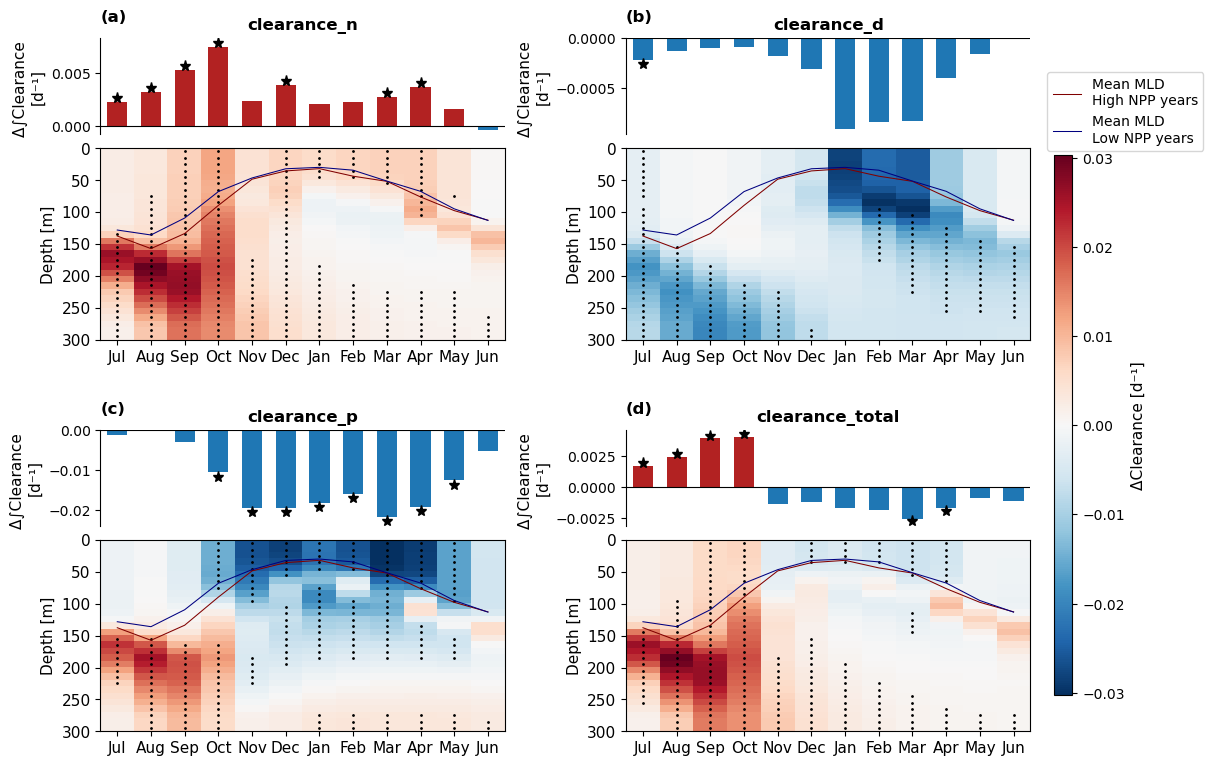

In [51]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

results_dict = depth_bootstrap_results

## selected_vars: 
prod_vars = ['ppphyn', 'ppphyd', 'ppphyp', 'pp_total']
conc_vars = ['phyn_conc', 'phyd_conc', 'phyp_conc', 'phy_conc_total']
lfe_vars = ['LNFe', 'LDFe', 'LPFe', 'L_Fe']
lN_vars = ['LNN', 'LDN', 'LPN', 'L_N']
llight_vars = ['LNlight', 'LDlight', 'LPlight', 'L_light']
mu_max_vars = ['μ_N_max', 'μ_D_max', 'μ_P_max', 'μ_tot_max']
mu_vars = ['mu_n','mu_d','mu_p','mu_tot']
nuts_vars = ['Fer', 'NO3', 'Si', 'O2']
zoop_vars = ['microzoop', 'mesozoop']
clearance_vars = ['clearance_n', 'clearance_d', 'clearance_p', 'clearance_total']
gr_pres_vars = ['GSP_n_pressure','GSP_d_pressure','GSP_p_pressure','GSP_pressure']
chl_vars = ['chl_n', 'chl_d', 'chl_p', 'chl_total']
ngl_vars = ['NGL_n_pressure', 'NGL_d_pressure', 'NGL_p_pressure', 'NGL_pressure']

## the variables in the integrated dataframe (df) are stored under the NPP headers and must be mapped manually. 
## varname_map: 
varname_map_npp = {
    'ppphyn': 'ppphyn',
    'ppphyd': 'ppphyd',
    'ppphyp': 'ppphyp',
    'pp_total': 'pp_total'
}
varname_map_biomass = {
    'phyn_conc': 'ppphyn',
    'phyd_conc': 'ppphyd',
    'phyp_conc': 'ppphyp',
    'phy_conc_total': 'pp_total'
}
varname_map_chl = {
    'chl_n': 'ppphyn',
    'chl_d': 'ppphyd',
    'chl_p': 'ppphyp',
    'chl_total': 'pp_total'
}
varname_map_grzprs = {
    'GSP_n_pressure': 'ppphyn',
    'GSP_d_pressure': 'ppphyd',
    'GSP_p_pressure': 'ppphyp',
    'GSP_pressure': 'pp_total'
}
varname_map_ngl = {
    'NGL_n_pressure': 'ppphyn',
    'NGL_d_pressure': 'ppphyd',
    'NGL_p_pressure': 'ppphyp',
    'NGL_pressure': 'pp_total'
}
varname_map_clearance = {
    'clearance_n': 'ppphyn',
    'clearance_d': 'ppphyd',
    'clearance_p': 'ppphyp',
    'clearance_total': 'pp_total'
}
varname_map_lfe = {
    'LNFe': 'ppphyn',
    'LDFe': 'ppphyd',
    'LPFe': 'ppphyp',
    #'L_Fe': 'pp_total'
    'L_Fe_weighted': 'pp_total'
}
varname_map_lN = {
    'LNN': 'ppphyn',
    'LDN': 'ppphyd',
    'LPN': 'ppphyp',
    #'L_N': 'pp_total'
    'L_N_weighted': 'pp_total'
}
varname_map_light = {
    'LNlight': 'ppphyn',
    'LDlight': 'ppphyd',
    'LPlight': 'ppphyp',
    #'L_light': 'pp_total'
    'L_light_weighted': 'pp_total'
}
varname_map_mu = {
    'mu_n': 'ppphyn',
    'mu_d': 'ppphyd',
    'mu_p': 'ppphyp',
    #'mu_tot': 'pp_total'
    'mu_tot_weighted': 'pp_total'
}
varname_map_mumax = {
    'μ_N_max': 'ppphyn',
    'μ_D_max': 'ppphyd',
    'μ_P_max': 'ppphyp',
   # 'μ_tot_max': 'pp_total'
    'μ_tot_max_weighted': 'pp_total'
}
varname_map_nuts = {
    'Fer': 'pp_total',
    'NO3': 'pp_total',
    'Si': 'pp_total',
    'O2': 'pp_total'
}

######################## Select Plotting vars ########################
#Integrated variable group keys (selected_key): ['Biomass', 'Clearance', 'Fe', 'Graz_pressure', 'LFe', 'LN', 'Llight', 'MLD', 'Mesozoop', 'Microzoop', 'NO3', 'NPP', 'O2', 'SST', 'STF', 'Si', 'μ', 'μ_max']
selected_vars = clearance_vars 
selected_key = 'Clearance'
varname_map = varname_map_clearance
########################################################################
    
p_threshold = 0.05
cmap =  'RdBu_r'
bar_colors = {'ppphyn': 'tab:red',
 'ppphyp': 'tab:blue',
 'ppphyd': 'tab:green',
 'pp_total': 'tab:purple'}  # defined earlier: maps var name to color

fig = plt.figure(figsize=(12, 9))
# Top-level GridSpec: 2 rows (each group of 2 rows from original), 2 columns
# Make the vertical gap larger by setting height_ratios, with extra space between groups
outer_gs = gridspec.GridSpec(2, 2, height_ratios=[4, 4], hspace=0.3, wspace = 0.3)  # hspace here controls vertical gap between groups

month_labels = np.roll(np.arange(1, 13), -6)
months_native = np.arange(1, 13)
month_names = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
bar_width = 0.6

selected_im = None
bar_axes = []
depth_axes = []

for i, varname in enumerate(selected_vars):
    group_row = i // 2
    col = i % 2

    inner_gs = gridspec.GridSpecFromSubplotSpec(
        2, 1,
        subplot_spec=outer_gs[group_row, col],
        height_ratios=[1.5, 3],
        hspace=0.1
    )

    ax_bar = fig.add_subplot(inner_gs[0])
    ax_depth = fig.add_subplot(inner_gs[1])

    bar_axes.append(ax_bar)
    depth_axes.append(ax_depth)

    # Extract and map group name
    df_var = df[df['variable'] == selected_key].copy()
    df_var = circshift_months(df_var, shift=6)

    group_name = varname_map[varname]  # <--- select corresponding varname_map 
    df_var = df_var[df_var['group'] == group_name]

    posneg_colors = ['firebrick' if val > 0 else 'tab:blue' for val in df_var['delta_obs']] # Turn off for coloration by phytoclass instead of +/-

    ax_bar.bar(
        df_var['month_shifted'],
        df_var['delta_obs'],
        color=posneg_colors,# update here too if color map uses group names
        width=bar_width
    )

    # Significance stars
    for _, row in df_var.iterrows():
        if row['p_val'] < p_threshold:
            offset = 0.05 * max(abs(df_var['delta_obs']))
            star_y = row['delta_obs'] + (offset if row['delta_obs'] >= 0 else -offset)
            ax_bar.plot(row['month_shifted'], star_y, marker='*', color='k', markersize=8)

    ax_bar.axhline(0, color='black', linewidth=0.8)
    ax_bar.set_xticks([])
    ax_bar.spines[['bottom', 'right', 'top']].set_visible(False)
    ax_bar.set_xlim(0.5, 12.5)

    ax_bar.set_ylabel(f'Δ∫{selected_key} \n[d⁻¹]', fontsize=11) #mmol m⁻² m² mmolC⁻¹ d⁻¹ m⁻² m⁻³
    ax_bar.set_title(varname, fontsize=12, fontweight='bold')

    # Depth plot
    delta = results_dict[varname]['delta_obs']
    pval = results_dict[varname]['p_val']

    data = np.roll(delta.values.T, shift=-6, axis=1)
    pvals = np.roll(pval.values.T, shift=-6, axis=1)

    vlim = np.nanmax(np.abs(data))
    im = ax_depth.imshow(
        data, aspect='auto', origin='upper',
        extent=[0.5, 12.5, 300, 0],
        cmap=cmap, vmin=-vlim, vmax=vlim
    )
    if selected_im is None:
        selected_im = im

    nonsig_mask = pvals <= p_threshold
    y_stipple, x_stipple = np.where(nonsig_mask)
    ax_depth.plot(months_native[x_stipple], delta['depth'].values[y_stipple]+5, 'k.', markersize=2)

    # MLD overlay
    ax_depth.plot(month_labels_mld, mld_high_years_clim_shifted, linestyle='-', linewidth=0.75, color='maroon', label='Mean MLD \nHigh NPP years')
    ax_depth.plot(month_labels_mld, mld_low_years_clim_shifted, linestyle='-', linewidth=0.75, color='navy', label='Mean MLD \nLow NPP years')

    ax_depth.set_xticks(np.arange(1, 13))
    ax_depth.set_xticklabels(month_names, fontsize=11)
    ax_depth.set_yticks([0, 50, 100, 150, 200, 250, 300])
    ax_depth.set_yticklabels([0, 50, 100, 150, 200, 250, 300], fontsize=11)
    ax_depth.set_ylabel('Depth [m]', fontsize=11)

# Legend and colorbar
handles, labels = depth_axes[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=1, bbox_to_anchor=(1.05, 0.85), fontsize=10)

cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.6])
cbar = fig.colorbar(selected_im, cax=cbar_ax)
cbar.set_label(f'Δ{selected_key} [d⁻¹]', fontsize=11) #d⁻¹ mmol C m⁻³

# Panel labels
panel_labels = ['a', 'b', 'c', 'd']
#panel_labels = ['e', 'f', 'g', 'h']

for label, ax in zip(panel_labels, bar_axes):
    ax.text(
        0, 1.3, f'({label})',
        transform=ax.transAxes,
        fontsize=12,
        fontweight='bold',
        va='top',
        ha='left'
    )

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


### Figure A1.6 e - f 

/var/folders/dk/4pyn7w4102bfzscb0m9606zw0000gn/T/ipykernel_9606/1538896417.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


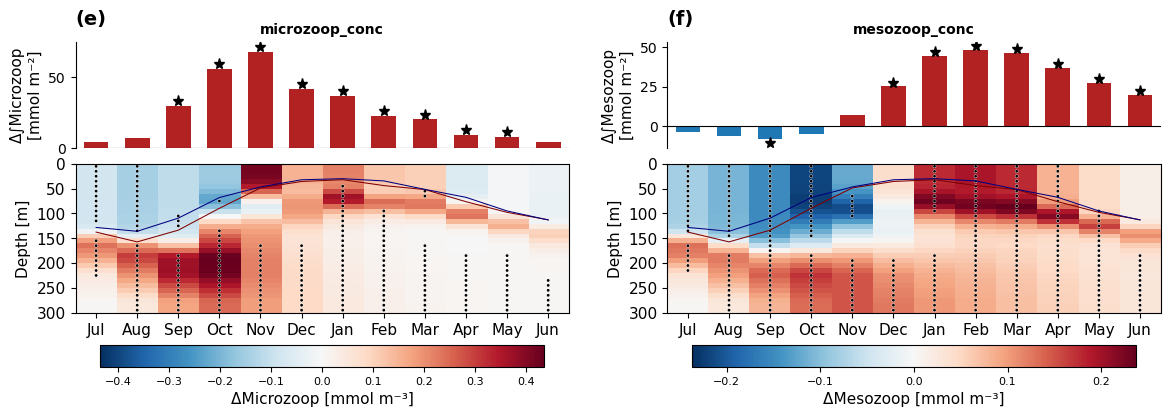

In [52]:
zoop_vars = ['microzoop_conc', 'mesozoop_conc']

varname_map_zoop = {
    'microzoop_conc': 'pp_total',
    'mesozoop_conc': 'pp_total',
}

######################## Select Plotting vars ########################
selected_vars = zoop_vars 
selected_keys =  ['Microzoop', 'Mesozoop']
varname_map = varname_map_zoop
########################################################################
    
p_threshold = 0.05
cmap = 'RdBu_r'
bar_colors = {'ppphyn': 'tab:red',
 'ppphyp': 'tab:blue',
 'ppphyd': 'tab:green',
 'pp_total': 'tab:purple'}  # defined earlier: maps var name to color

fig = plt.figure(figsize=(14, 10))
# Top-level GridSpec: 2 rows (each group of 2 rows from original), 2 columns
# Make the vertical gap larger by setting height_ratios, with extra space between groups
outer_gs = gridspec.GridSpec(2, 2, height_ratios=[4, 4], hspace=0.3, wspace = 0.2)  # hspace here controls vertical gap between groups

month_labels = np.roll(np.arange(1, 13), -6)
months_native = np.arange(1, 13)
month_names = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
bar_width = 0.6

selected_im = None
bar_axes = []
depth_axes = []

for i, (varname, selected_key) in enumerate(zip(selected_vars, selected_keys)):
    group_row = i // 2
    col = i % 2

    inner_gs = gridspec.GridSpecFromSubplotSpec(
        2, 1,
        subplot_spec=outer_gs[group_row, col],
        height_ratios=[1.5, 3],
        hspace=0.1
    )

    ax_bar = fig.add_subplot(inner_gs[0])
    ax_depth = fig.add_subplot(inner_gs[1])

    bar_axes.append(ax_bar)
    depth_axes.append(ax_depth)

    # Extract and map group name
    df_var = df[df['variable'] == selected_key].copy()
    df_var = circshift_months(df_var, shift=6)

    group_name = varname_map[varname]  # <--- select corresponding varname_map 
    df_var = df_var[df_var['group'] == group_name]

    posneg_colors = ['firebrick' if val > 0 else 'tab:blue' for val in df_var['delta_obs']] # Turn off for coloration by phytoclass instead of +/-

    ax_bar.bar(
        df_var['month_shifted'],
        df_var['delta_obs'],
        color=posneg_colors,# update here too if color map uses group names
        width=bar_width
    )

    # Significance stars
    for _, row in df_var.iterrows():
        if row['p_val'] < p_threshold:
            offset = 0.05 * max(abs(df_var['delta_obs']))
            star_y = row['delta_obs'] + (offset if row['delta_obs'] >= 0 else -offset)
            ax_bar.plot(row['month_shifted'], star_y, marker='*', color='k', markersize=8)

    ax_bar.axhline(0, color='black', linewidth=0.8)
    ax_bar.set_xticks([])
    ax_bar.spines[['bottom', 'right', 'top']].set_visible(False)
    ax_bar.set_xticklabels('')
    ax_bar.set_xlim(0.5, 12.5)
    ax_bar.set_ylabel(f'Δ∫{selected_key}\n[mmol m⁻²]', fontsize=11)   # molC m⁻³ d⁻¹ m⁻² mmol m⁻²
    ax_bar.set_title(varname, fontsize=10, fontweight='bold')

    # Depth plot
    delta = results_dict[varname]['delta_obs']
    pval = results_dict[varname]['p_val']

    data = np.roll(delta.values.T, shift=-6, axis=1)
    pvals = np.roll(pval.values.T, shift=-6, axis=1)

    vlim = np.nanmax(np.abs(data))
    im = ax_depth.imshow(
        data, aspect='auto', origin='upper',
        extent=[0.5, 12.5, 300, 0],
        cmap=cmap, vmin=-vlim, vmax=vlim
    )
    if selected_im is None:
        selected_im = im
        
    cbar = fig.colorbar(im, ax=ax_depth, orientation='horizontal', pad=0.15, shrink=0.9)
    #cbar.set_label(f'Δ{selected_key} []', fontsize=11) # mmol m⁻³
    cbar.set_label(f'Δ{selected_key} [mmol m⁻³]', fontsize=11)
    #cbar.set_label(units_map.get(varname, f'Δ{selected_key} ({varname})'), fontsize=11)
    cbar.ax.tick_params(labelsize=8)

    nonsig_mask = pvals <= p_threshold
    y_stipple, x_stipple = np.where(nonsig_mask)
    ax_depth.plot(months_native[x_stipple], delta['depth'].values[y_stipple]+5, 'k.', markersize=2, path_effects=[pe.withStroke(linewidth=1.5, foreground='white')])

    # MLD overlay
    ax_depth.plot(month_labels_mld, mld_high_years_clim_shifted, linestyle='-', linewidth=0.75, color='maroon', label='Mean MLD \nHigh NPP years')
    ax_depth.plot(month_labels_mld, mld_low_years_clim_shifted, linestyle='-', linewidth=0.75, color='navy', label='Mean MLD \nLow NPP years')

    ax_depth.set_xticks(np.arange(1, 13))
    ax_depth.set_xticklabels(month_names, fontsize=11)
    ax_depth.set_yticks([0, 50, 100, 150, 200, 250, 300])
    ax_depth.set_yticklabels([0, 50, 100, 150, 200, 250, 300], fontsize = 11)
    ax_depth.set_ylabel('Depth [m]', fontsize = 11)
    #ax_depth.set_title(varname, fontsize=10, fontweight='bold')

# Legend and colorbar
handles, labels = depth_axes[0].get_legend_handles_labels()
#fig.legend(handles, labels, ncol=2, bbox_to_anchor=(0.6, 0.1), fontsize=10)

# Panel labels
panel_labels = ['e', 'f', 'g', 'h']

for label, ax in zip(panel_labels, bar_axes):
    ax.text(
        0, 1.3, f'({label})',
        transform=ax.transAxes,
        fontsize=14,
        fontweight='bold',
        va='top',
        ha='left'
    )

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

# Figure 9: NPP Trends in PISCES (a) 1998-2022 and (b) 1975-2922

In [53]:
def compute_depth_integrated_npp(subset_diag, depth_thickness):
    """Compute depth-integrated NPP for each phytoplankton group and total.
    Converts units from mol C m⁻² s⁻¹ to mmol C m⁻² day⁻¹.
"""
    seconds_per_day = 86400

    depsum_ppphyn = ((subset_diag['PPPHYN'] * depth_thickness).sum(dim='deptht')) * seconds_per_day * 1000
    depsum_ppphyd = ((subset_diag['PPPHYD'] * depth_thickness).sum(dim='deptht')) * seconds_per_day* 1000
    depsum_ppphyp = ((subset_diag['PPPHYP'] * depth_thickness).sum(dim='deptht')) * seconds_per_day* 1000
    depsum_pp_tot = (((subset_diag['PPPHYN'] + subset_diag['PPPHYD'] + subset_diag['PPPHYP']) * depth_thickness).sum(dim='deptht')) * seconds_per_day* 1000
    
    return {
        'ppphyn': depsum_ppphyn,
        'ppphyd': depsum_ppphyd,
        'ppphyp': depsum_ppphyp,
        'pp_tot': depsum_pp_tot
    }

def compute_area_weighted_npp_with_std(da, area):
    spatial_mean = da.weighted(area).mean(dim=['y', 'x'])
    spatial_std = da.weighted(area).std(dim=['y', 'x'])
    return spatial_mean, spatial_std

def compute_depth_integrated_lims(subset_diag, depth_thickness):
    """Compute biomas weighted depth averagd Lims for each phytoplankton group and total.
    Converts units from mol C m⁻² s⁻¹ to mmol C m⁻² day⁻¹.
    """

    bwda_LNFe = ((subset_diag['LNFe'] * phyn_conc * depth_thickness)/bio_inventory_n).sum(dim='deptht')
    bwda_LDFe = ((subset_diag['LDFe'] * phyd_conc * depth_thickness)/bio_inventory_d).sum(dim='deptht')
    bwda_LPFe = ((subset_diag['LPFe'] * phyp_conc * depth_thickness)/bio_inventory_p).sum(dim='deptht')
    bwda_LFe_tot = (((subset_diag['LNFe'] + subset_diag['LDFe'] + subset_diag['LPFe']) * (phyn_conc+phyd_conc+phyp_conc) * depth_thickness)/bio_inventory_tot).sum(dim='deptht')

    return {
        'bwda_LNFe': bwda_LNFe,
        'bwda_LDFe': bwda_LDFe,
        'bwda_LPFe': bwda_LPFe,
        'bwda_LFe_tot': bwda_LFe_tot
    }

def compute_area_weighted_lims_with_std(da, area):
    spatial_mean = da.weighted(area).mean(dim=['y', 'x'])
    spatial_std = da.weighted(area).std(dim=['y', 'x'])
    return spatial_mean, spatial_std

## Figure A1.7

bwda_LNFe: slope = 0.000 ± 0.000, p = 0.000803, R² = 0.019
bwda_LDFe: slope = 0.000 ± 0.000, p = 0.0559, R² = 0.006
bwda_LPFe: slope = 0.000 ± 0.000, p = 0.00536, R² = 0.013
bwda_LFe_tot: slope = 0.000 ± 0.000, p = 0.00106, R² = 0.019


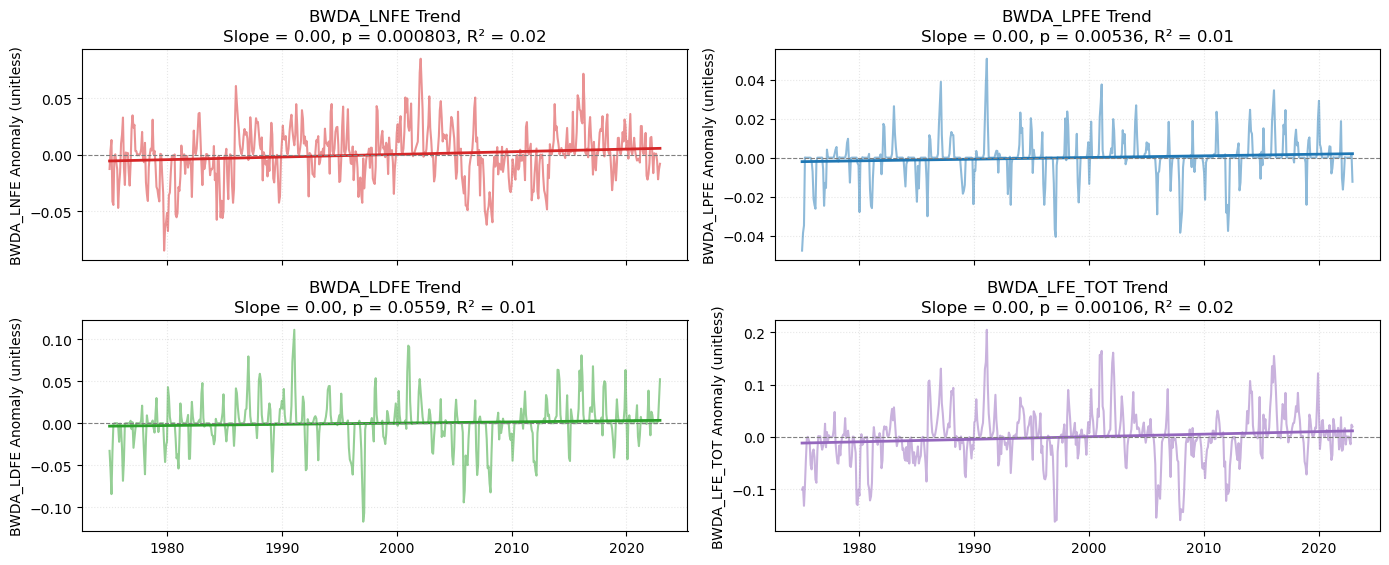

In [54]:
trend_subset_years = np.arange(1975, 2023) 

# Subset datasets
subset_diag_filt = subset_diag.where((subset_diag.time_counter.dt.year.isin(trend_subset_years)),
    drop=True)

lim_integrated = compute_depth_integrated_lims(subset_diag, depth_thickness)
lim_spatial_means = {}
for key, da in lim_integrated.items():
    lim_spatial_means[key], _ = compute_area_weighted_lims_with_std(da, area)
    
    deseasonalized_lim = {}

for key, ts in lim_spatial_means.items():
    clim = ts.groupby('time_counter.month').mean('time_counter')
    deseasonalized = ts.groupby('time_counter.month') - clim
    deseasonalized_lim[key] = deseasonalized
    
import statsmodels.api as sm
def fit_trend(ts):
    # Convert CFTimeIndex to relative years since start
    time_cf = ts['time_counter'].values
    start_year = time_cf[0].year + (time_cf[0].month - 1) / 12
    time_in_years = np.array([t.year + (t.month - 1)/12 for t in time_cf])
    time_rel = time_in_years - start_year

    y = ts.values
    X = sm.add_constant(time_rel)  # adds intercept
    model = sm.OLS(y, X, missing='drop').fit()
    return model

ols_models = {}

for key, ts in deseasonalized_lim.items():
    ols_models[key] = fit_trend(ts)
    
for key, model in ols_models.items():
    print(f"{key}: slope = {model.params[1]:.3f} ± {model.bse[1]:.3f}, p = {model.pvalues[1]:.3g}, R² = {model.rsquared:.3f}")
    
fig, axs = plt.subplots(2, 2, figsize=(14, 6), sharex=True)
axs = axs.flatten()

lim_keys = ['bwda_LNFe', 'bwda_LPFe', 'bwda_LDFe', 'bwda_LFe_tot']
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:purple']
from statsmodels.sandbox.regression.predstd import wls_prediction_std
for i, key in enumerate(lim_keys):
    ts = deseasonalized_lim[key]
    model = ols_models[key]
    
    # Rebuild time axis
    time_cf = ts['time_counter'].values
    start_year = time_cf[0].year + (time_cf[0].month - 1) / 12
    time_in_years = np.array([t.year + (t.month - 1)/12 for t in time_cf])
    time_rel = time_in_years - start_year
    
    # Plot deseasonalized series
    axs[i].plot(time_in_years, ts.values, color=colors[i], alpha=0.5, label='Deseasonalized NPP')
    
    # Plot OLS trend line
    trend_line = model.predict(sm.add_constant(time_rel))
    axs[i].plot(time_in_years, trend_line, color=colors[i], lw=2, label='OLS Trend')
    
    # Optional: plot 95% CI band

    _, lower, upper = wls_prediction_std(model)
    #axs[i].fill_between(time_in_years, lower, upper, color='gray', alpha=0.3, label='95% CI')
    axs[i].axhline(0, linestyle='--', color='gray', linewidth=0.8)
    # Add stats to legend or title
    slope = model.params[1]
    pval = model.pvalues[1]
    r2 = model.rsquared
    axs[i].set_title(f"{key.upper()} Trend\nSlope = {slope:.2f}, p = {pval:.3g}, R² = {r2:.2f}")
    axs[i].set_ylabel(f"{key.upper()} Anomaly (unitless)")
    #axs[i].legend()
    axs[i].grid(alpha = 0.3, linestyle = ':')

#fig.suptitle("Deseasonalized NPP Time Series and Linear Trends", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

ppphyn: slope = 0.015 ± 0.012, p = 0.209, R² = 0.005
ppphyd: slope = -0.014 ± 0.005, p = 0.00518, R² = 0.026
ppphyp: slope = 0.006 ± 0.009, p = 0.476, R² = 0.002
pp_tot: slope = 0.007 ± 0.010, p = 0.494, R² = 0.002


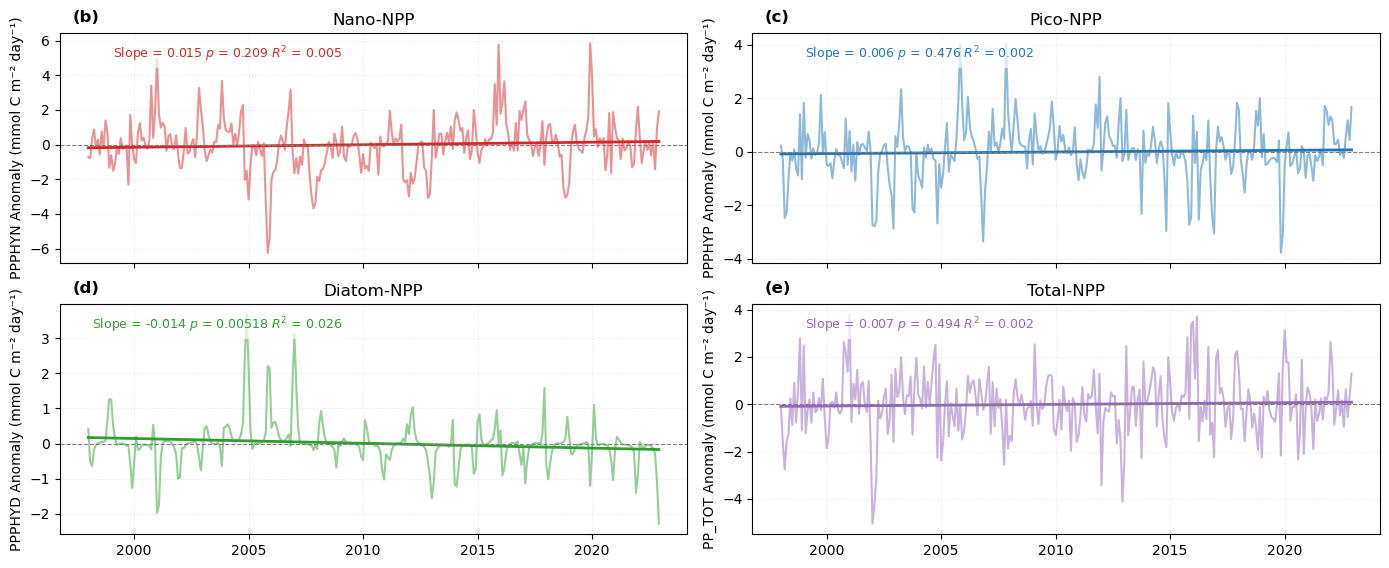

In [55]:


trend_subset_years = np.arange(1998, 2023) 

# Subset datasets
subset_diag_filt = subset_diag.where((subset_diag.time_counter.dt.year.isin(trend_subset_years)),
    drop=True)

lim_integrated = compute_depth_integrated_npp(subset_diag_filt, depth_thickness)
lim_spatial_means = {}
for key, da in lim_integrated.items():
    lim_spatial_means[key], _ = compute_area_weighted_lims_with_std(da, area)
    
    deseasonalized_npp = {}

for key, ts in lim_spatial_means.items():
    clim = ts.groupby('time_counter.month').mean('time_counter')
    deseasonalized = ts.groupby('time_counter.month') - clim
    deseasonalized_npp[key] = deseasonalized
    
import statsmodels.api as sm
def fit_trend(ts):
    # Convert CFTimeIndex to relative years since start
    time_cf = ts['time_counter'].values
    start_year = time_cf[0].year + (time_cf[0].month - 1) / 12
    time_in_years = np.array([t.year + (t.month - 1)/12 for t in time_cf])
    time_rel = time_in_years - start_year

    y = ts.values
    X = sm.add_constant(time_rel)  # adds intercept
    model = sm.OLS(y, X, missing='drop').fit()
    return model

ols_models = {}

for key, ts in deseasonalized_npp.items():
    ols_models[key] = fit_trend(ts)
    
for key, model in ols_models.items():
    print(f"{key}: slope = {model.params[1]:.3f} ± {model.bse[1]:.3f}, p = {model.pvalues[1]:.3g}, R² = {model.rsquared:.3f}")
    
fig, axs = plt.subplots(2, 2, figsize=(14, 6), sharex=True)
axs = axs.flatten()

lim_keys = ['ppphyn', 'ppphyp', 'ppphyd', 'pp_tot']
title_keymap = {'ppphyn': 'Nano-NPP',
                'ppphyp': 'Pico-NPP',
                'ppphyd': 'Diatom-NPP',
                'pp_tot': 'Total-NPP'
}
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:purple']
from statsmodels.sandbox.regression.predstd import wls_prediction_std
for i, key in enumerate(lim_keys):
    ts = deseasonalized_npp[key]
    model = ols_models[key]
    
    # Rebuild time axis
    time_cf = ts['time_counter'].values
    start_year = time_cf[0].year + (time_cf[0].month - 1) / 12
    time_in_years = np.array([t.year + (t.month - 1)/12 for t in time_cf])
    time_rel = time_in_years - start_year
    
    # Plot deseasonalized series
    axs[i].plot(time_in_years, ts.values, color=colors[i], alpha=0.5, label='Deseasonalized NPP')
    
    # Plot OLS trend line
    trend_line = model.predict(sm.add_constant(time_rel))
    axs[i].plot(time_in_years, trend_line, color=colors[i], lw=2, label='OLS Trend')
    
    # Optional: plot 95% CI band

    _, lower, upper = wls_prediction_std(model)
    #axs[i].fill_between(time_in_years, lower, upper, color='gray', alpha=0.3, label='95% CI')
    axs[i].axhline(0, linestyle='--', color='gray', linewidth=0.8)
    # Add stats to legend or title
    slope = model.params[1]
    pval = model.pvalues[1]
    r2 = model.rsquared
    axs[i].text(
        0.45, 0.95,
        f"Slope = {slope:.3f} $p$ = {pval:.3g} $R^2$ = {r2:.3f}",
        transform=axs[i].transAxes,
        fontsize=9,
        color = colors[i],
        ha='right',
        va='top',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none')
    )
    
    axs[i].set_title(title_keymap.get(key, f'{key} Trend\nSlope = {slope:.2f}, p = {pval:.3g}, R² = {r2:.2f}'))
    axs[i].set_ylabel(f"{key.upper()} Anomaly (mmol C m⁻² day⁻¹)")
    #axs[i].legend(ncol = 3, loc = 'lower center')
    axs[i].grid(alpha = 0.3, linestyle = ':')

    
panel_labels = ['b','c','d','e']    
for label, ax in zip(panel_labels, axs):
    ax.text(
        0.02, 1.1, f'({label})',
        transform=ax.transAxes,
        fontsize=12,
        fontweight='bold',
        va='top',
        ha='left'
    )
    
#fig.suptitle("Deseasonalized NPP Time Series and Linear Trends", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

ppphyn: slope = 0.015 ± 0.012, p = 0.209, R² = 0.005
ppphyd: slope = -0.014 ± 0.005, p = 0.00518, R² = 0.026
ppphyp: slope = 0.006 ± 0.009, p = 0.476, R² = 0.002
pp_tot: slope = 0.007 ± 0.010, p = 0.494, R² = 0.002


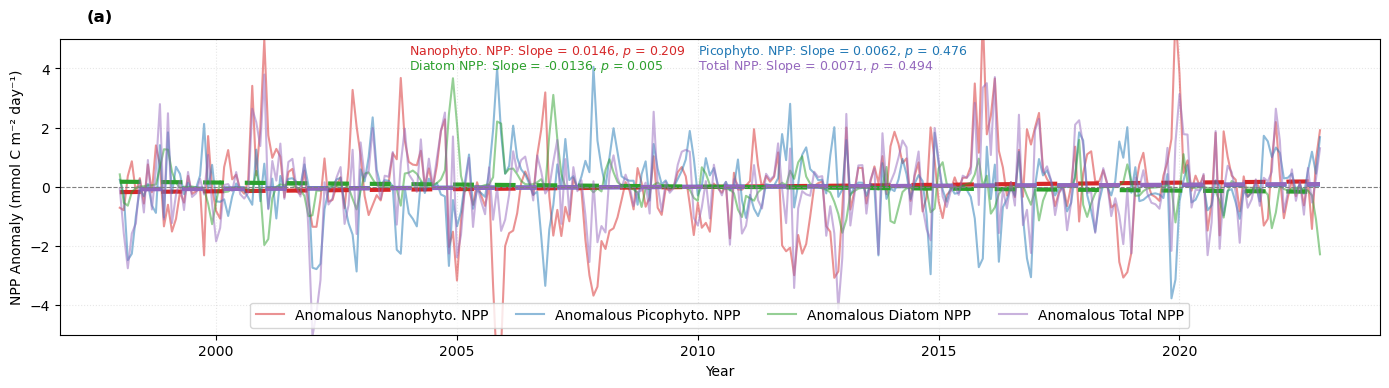

In [56]:
# To get figure 9b, just change 1998 to 1975
trend_subset_years = np.arange(1998, 2023) 

# Subset datasets
subset_diag_filt = subset_diag.where((subset_diag.time_counter.dt.year.isin(trend_subset_years)),
    drop=True)

lim_integrated = compute_depth_integrated_npp(subset_diag_filt, depth_thickness)
lim_spatial_means = {}
for key, da in lim_integrated.items():
    lim_spatial_means[key], _ = compute_area_weighted_lims_with_std(da, area)
    
    deseasonalized_npp = {}

for key, ts in lim_spatial_means.items():
    clim = ts.groupby('time_counter.month').mean('time_counter')
    deseasonalized = ts.groupby('time_counter.month') - clim
    deseasonalized_npp[key] = deseasonalized
    
import statsmodels.api as sm
def fit_trend(ts):
    # Convert CFTimeIndex to relative years since start
    time_cf = ts['time_counter'].values
    start_year = time_cf[0].year + (time_cf[0].month - 1) / 12
    time_in_years = np.array([t.year + (t.month - 1)/12 for t in time_cf])
    time_rel = time_in_years - start_year

    y = ts.values
    X = sm.add_constant(time_rel)  # adds intercept
    model = sm.OLS(y, X, missing='drop').fit()
    return model

ols_models = {}

for key, ts in deseasonalized_npp.items():
    ols_models[key] = fit_trend(ts)
    
for key, model in ols_models.items():
    print(f"{key}: slope = {model.params[1]:.3f} ± {model.bse[1]:.3f}, p = {model.pvalues[1]:.3g}, R² = {model.rsquared:.3f}")

fig, ax = plt.subplots(figsize=(14, 4))

npp_keys = ['ppphyn', 'ppphyp', 'ppphyd', 'pp_tot']
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:purple']

linestyles = {
    'ppphyn': (0, (5, 5)),   # or '-'
    'ppphyp': (5, (5, 5)),   # or '--'
    'ppphyd': (0, (5, 5)),   # or '-.'
    'pp_tot': (5, (5, 5)),   # or ':'
}

key_labels = {
    'ppphyn': 'Nanophyto. NPP',
    'ppphyp': 'Picophyto. NPP',
    'ppphyd': 'Diatom NPP',
    'pp_tot': 'Total NPP'
}

for i, key in enumerate(npp_keys):
    ts = deseasonalized_npp[key]
    model = ols_models[key]
    
    time_cf = ts['time_counter'].values
    start_year = time_cf[0].year + (time_cf[0].month - 1) / 12
    time_in_years = np.array([t.year + (t.month - 1)/12 for t in time_cf])
    time_rel = time_in_years - start_year
    
    # Plot deseasonalized series
    ax.plot(time_in_years, ts.values, color=colors[i], alpha=0.5,
        label=f'Anomalous {key_labels[key]}')
    
    # Plot OLS trend line
    trend_line = model.predict(sm.add_constant(time_rel))
    ax.plot(time_in_years, trend_line, color=colors[i],
        linestyle=linestyles[key], lw=3)
    
    # Annotation of slope and p-value
    slope = model.params[1]
    pval = model.pvalues[1]
    
    # Column and row index for layout
    col_idx = i % 2
    row_idx = i // 2

    # Adjust x/y for multi-column layout
    x_annot = 2004 + col_idx * 6
    y_annot = 4.6 - row_idx *0.5

    ax.text(
        x_annot, y_annot,
        f'{key_labels[key]}: Slope = {slope:.4f}, $p$ = {pval:.3f}',
        fontsize=9, color=colors[i],
        va='center', ha='left')

ax.axhline(0, linestyle='--', color='gray', linewidth=0.8)
ax.set_xlabel('Year')
ax.set_ylabel('NPP Anomaly (mmol C m⁻² day⁻¹)')
ax.legend(loc='lower center', ncol=4)
ax.grid(alpha=0.3, linestyle=':')
ax.set_ylim(-5,5)

ax.text(
    0.02, 1.1, '(a)',
    transform=ax.transAxes,
    fontsize=12,
    fontweight='bold',
    va='top',
    ha='left'
)

plt.tight_layout()
plt.show()

# Appendix Figure A1.2

## Filter subset datasets based on anomalous year properties

In [57]:
## Terms pre-processes are in Section 4.4

years_subset_list = [top5_pp_tot_int_years,
                    bottom5_pp_tot_int_years]

## add dictionary storage handles 
filter_suffix = ['_filt_max_pp_tot',
                 '_filt_min_pp_tot']

## Dictionary of datasets to filter
filtered_datasets = {
    'subset_T': {},
    'subset_diag': {},
    'subset_trc': {},
    'mean_stf_df': {}
}

for years_subset, suffix in zip(years_subset_list, filter_suffix):
    # Filter each dataset and store in dictionary
    filtered_datasets['subset_T'][suffix] = subset_T.where(subset_T['july_year'].isin(years_subset), drop=True)
    filtered_datasets['subset_diag'][suffix] = subset_diag.where(subset_diag['july_year'].isin(years_subset), drop=True)
    filtered_datasets['subset_trc'][suffix] = subset_trc.where(subset_trc['july_year'].isin(years_subset), drop=True)
    filtered_datasets['mean_stf_df'][suffix] = mean_stf_df[mean_stf_df['july_year'].isin(years_subset)].copy()

## Filter pre-computed variables
# set variable list
bwda_Mutotal = ((((ds['MuN'] * phyn_conc) + (ds['MuD'] * phyd_conc) + (ds['MuP'] * phyp_conc)) * depth_thickness)/bio_inventory_tot).sum(dim='deptht') 

bwda_var_list = [
    [bwda_μ_P_n, bwda_μ_P_p, bwda_μ_P_d, bwda_μ_P_total],
    [bwda_n['LNFe'], bwda_p['LPFe'], bwda_d['LDFe'], bwda_total_LFe],
    [bwda_n['LNlight'], bwda_p['LPlight'], bwda_d['LDlight'], bwda_total_Llight],
    [bwda_n['MuN']*seconds_per_day, bwda_p['MuP']*seconds_per_day, bwda_d['MuD']*seconds_per_day, bwda_Mutotal*seconds_per_day]]

all_bwda_vars = [var for row in bwda_var_list for var in row]

# Assign names to each variable (you may want to customize these)
bwda_var_names = [
    'μ_max_n', 'μ_max_p', 'μ_max_d', 'μ_max_total',
    'LNFe', 'LPFe', 'LDFe', 'LFe_total',
    'LNlight', 'LPlight', 'LDlight', 'Llight_total',
    'μ_n', 'μ_p', 'μ_d', 'μ_total'
]

# Create a dictionary mapping variable names to DataArrays
bwda_vars_named = dict(zip(bwda_var_names, all_bwda_vars))

# Initialize the filtered dictionary
filtered_bwda_variables = {}

for years_subset, suffix in zip(years_subset_list, filter_suffix):
    filtered_bwda_variables[suffix] = {}
    for var_name, da in bwda_vars_named.items():
        filtered_bwda_variables[suffix][var_name] = da.where(da['july_year'].isin(years_subset), drop=True)
    
print('Year subsetting filtration complete') 

Year subsetting filtration complete


In [58]:
## Process year-filtered LFe terms
LFe_n_high = filtered_datasets['subset_diag']['_filt_max_pp_tot']['LNFe'].groupby('time_counter.month').mean(dim = ['y', 'x', 'time_counter'])
LFe_d_high = filtered_datasets['subset_diag']['_filt_max_pp_tot']['LDFe'].groupby('time_counter.month').mean(dim = ['y', 'x', 'time_counter'])
LFe_p_high = filtered_datasets['subset_diag']['_filt_max_pp_tot']['LPFe'].groupby('time_counter.month').mean(dim = ['y', 'x', 'time_counter'])

LFe_total_high = ((filtered_datasets['subset_diag']['_filt_max_pp_tot']['LNFe']*filtered_datasets['subset_trc']['_filt_max_pp_tot']['PHY']  + 
                  filtered_datasets['subset_diag']['_filt_max_pp_tot']['LDFe']*filtered_datasets['subset_trc']['_filt_max_pp_tot']['PHY2'] + 
                  filtered_datasets['subset_diag']['_filt_max_pp_tot']['LPFe']*filtered_datasets['subset_trc']['_filt_max_pp_tot']['PIC'])/(filtered_datasets['subset_trc']['_filt_max_pp_tot']['PHY'] + filtered_datasets['subset_trc']['_filt_max_pp_tot']['PHY2'] + filtered_datasets['subset_trc']['_filt_max_pp_tot']['PIC'])).groupby('time_counter.month').mean(dim = ['y', 'x', 'time_counter'])

LFe_n_low = filtered_datasets['subset_diag']['_filt_min_pp_tot']['LNFe'].groupby('time_counter.month').mean(dim = ['y', 'x', 'time_counter'])
LFe_d_low = filtered_datasets['subset_diag']['_filt_min_pp_tot']['LDFe'].groupby('time_counter.month').mean(dim = ['y', 'x', 'time_counter'])
LFe_p_low = filtered_datasets['subset_diag']['_filt_min_pp_tot']['LPFe'].groupby('time_counter.month').mean(dim = ['y', 'x', 'time_counter'])

LFe_total_low = ((filtered_datasets['subset_diag']['_filt_min_pp_tot']['LNFe']*filtered_datasets['subset_trc']['_filt_min_pp_tot']['PHY']  + 
                  filtered_datasets['subset_diag']['_filt_min_pp_tot']['LDFe']*filtered_datasets['subset_trc']['_filt_min_pp_tot']['PHY2'] + 
                  filtered_datasets['subset_diag']['_filt_min_pp_tot']['LPFe']*filtered_datasets['subset_trc']['_filt_min_pp_tot']['PIC'])/(filtered_datasets['subset_trc']['_filt_min_pp_tot']['PHY'] + filtered_datasets['subset_trc']['_filt_min_pp_tot']['PHY2'] + filtered_datasets['subset_trc']['_filt_min_pp_tot']['PIC'])).groupby('time_counter.month').mean(dim = ['y', 'x', 'time_counter'])

In [59]:
## Process year-filtered LN terms
LN_n_high = filtered_datasets['subset_diag']['_filt_max_pp_tot']['LNN'].groupby('time_counter.month').mean(dim = ['y', 'x', 'time_counter'])
LN_d_high = filtered_datasets['subset_diag']['_filt_max_pp_tot']['LDN'].groupby('time_counter.month').mean(dim = ['y', 'x', 'time_counter'])
LN_p_high = filtered_datasets['subset_diag']['_filt_max_pp_tot']['LPN'].groupby('time_counter.month').mean(dim = ['y', 'x', 'time_counter'])

LN_total_high = ((filtered_datasets['subset_diag']['_filt_max_pp_tot']['LNN']*filtered_datasets['subset_trc']['_filt_max_pp_tot']['PHY']  + 
                  filtered_datasets['subset_diag']['_filt_max_pp_tot']['LDN']*filtered_datasets['subset_trc']['_filt_max_pp_tot']['PHY2'] + 
                  filtered_datasets['subset_diag']['_filt_max_pp_tot']['LPN']*filtered_datasets['subset_trc']['_filt_max_pp_tot']['PIC'])/(filtered_datasets['subset_trc']['_filt_max_pp_tot']['PHY'] + filtered_datasets['subset_trc']['_filt_max_pp_tot']['PHY2'] + filtered_datasets['subset_trc']['_filt_max_pp_tot']['PIC'])).groupby('time_counter.month').mean(dim = ['y', 'x', 'time_counter'])

LN_n_low = filtered_datasets['subset_diag']['_filt_min_pp_tot']['LNN'].groupby('time_counter.month').mean(dim = ['y', 'x', 'time_counter'])
LN_d_low = filtered_datasets['subset_diag']['_filt_min_pp_tot']['LDN'].groupby('time_counter.month').mean(dim = ['y', 'x', 'time_counter'])
LN_p_low = filtered_datasets['subset_diag']['_filt_min_pp_tot']['LPN'].groupby('time_counter.month').mean(dim = ['y', 'x', 'time_counter'])

LN_total_low = ((filtered_datasets['subset_diag']['_filt_min_pp_tot']['LNN']*filtered_datasets['subset_trc']['_filt_min_pp_tot']['PHY']  + 
                  filtered_datasets['subset_diag']['_filt_min_pp_tot']['LDN']*filtered_datasets['subset_trc']['_filt_min_pp_tot']['PHY2'] + 
                  filtered_datasets['subset_diag']['_filt_min_pp_tot']['LPN']*filtered_datasets['subset_trc']['_filt_min_pp_tot']['PIC'])/(filtered_datasets['subset_trc']['_filt_min_pp_tot']['PHY'] + filtered_datasets['subset_trc']['_filt_min_pp_tot']['PHY2'] + filtered_datasets['subset_trc']['_filt_min_pp_tot']['PIC'])).groupby('time_counter.month').mean(dim = ['y', 'x', 'time_counter'])

## Plot Figure A1.2

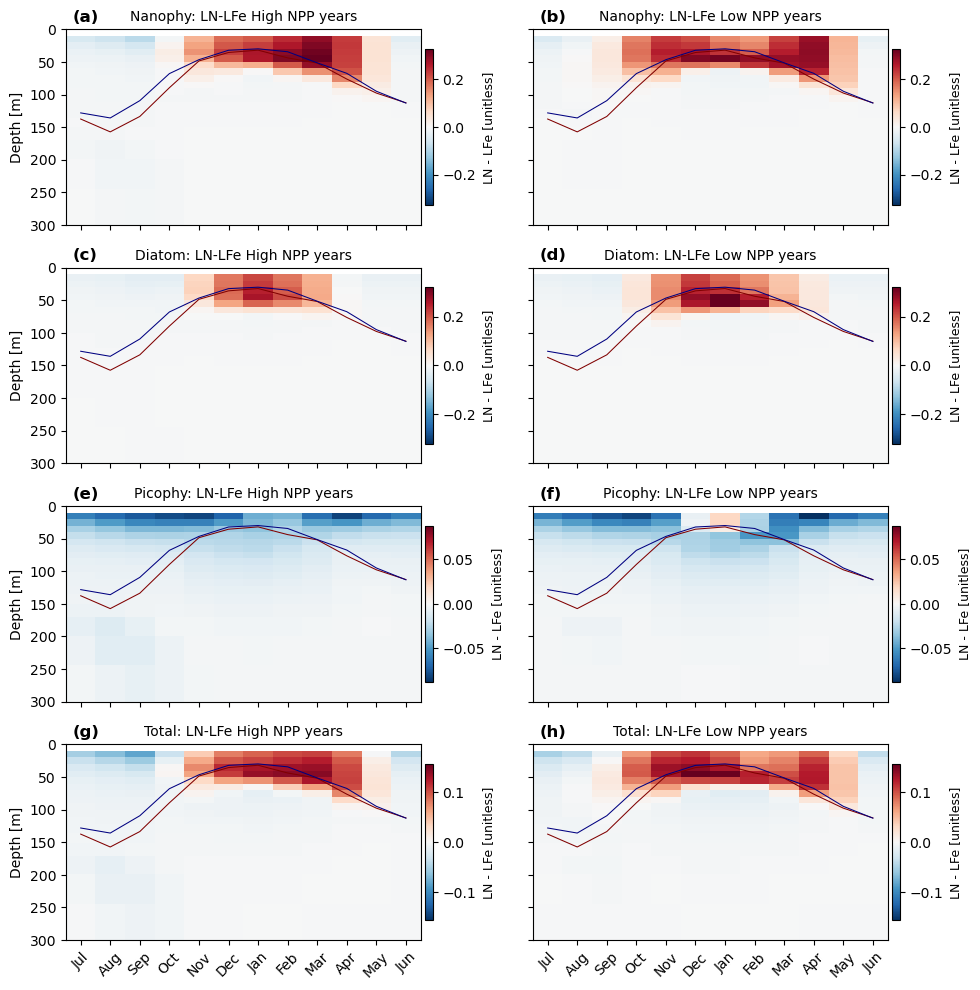

In [60]:
# Define variables and titles
'''
var_list = [
    biomass_n_high, biomass_n_low,
    biomass_d_high, biomass_d_low,
    biomass_p_high, biomass_p_low,
    biomass_total_high, biomass_total_low
]

var_list = [
    LN_n_high, LN_n_low,
    LN_d_high, LN_d_low,
    LN_p_high, LN_p_low,
    LN_total_high, LN_total_low
]

var_list = [
    LFe_n_high, LFe_n_low,
    LFe_d_high, LFe_d_low,
    LFe_p_high, LFe_p_low,
    LFe_total_high, LFe_total_low
]
'''
var_list = [
    LN_n_high-LFe_n_high, LN_n_low-LFe_n_low,
    LN_d_high-LFe_d_high, LN_d_low-LFe_d_low,
    LN_p_high-LFe_p_high, LN_p_low-LFe_p_low,
    LN_total_high-LFe_total_high, LN_total_low-LFe_total_low
]
'''
titles = [
    'Nanophy: High NPP years', 'Nanophy: Low NPP years',
    'Diatom: High NPP years', 'Diatom: Low NPP years',
    'Picophy: High NPP years', 'Picophy: Low NPP years',
    'Total Biomass: High NPP years', 'Total Biomass: Low NPP years'
]
'''

titles = [
    'Nanophy: LN-LFe High NPP years', 'Nanophy: LN-LFe Low NPP years',
    'Diatom: LN-LFe High NPP years', 'Diatom: LN-LFe Low NPP years',
    'Picophy: LN-LFe High NPP years', 'Picophy: LN-LFe Low NPP years',
    'Total: LN-LFe High NPP years', 'Total: LN-LFe Low NPP years'
]
#cmaps = ['Reds', 'Blues'] * 4
cmaps = ['RdBu_r'] * 8


month_labels = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec',
                'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
month_order = np.roll(np.arange(12), -6)

## Process climatological MLD in high and low years fro overlay on plots 
mld_high = subset_T['mldr10_1'].where(subset_T['mldr10_1'].july_year.isin(top5_pp_tot_int_years), drop=True)
mld_low = subset_T['mldr10_1'].where(subset_T['mldr10_1'].july_year.isin(bottom5_pp_tot_int_years), drop=True)

weighted_mld_high = mld_high.weighted(area).mean(dim=['y', 'x'])
weighted_mld_low = mld_low.weighted(area).mean(dim=['y', 'x'])
    
mld_high_years_clim = weighted_mld_high.groupby('month').mean(dim = 'time_counter') 
mld_low_years_clim = weighted_mld_low.groupby('month').mean(dim = 'time_counter')

mld_high_years_clim_shifted = np.roll(mld_high_years_clim.values, -6)
mld_low_years_clim_shifted = np.roll(mld_low_years_clim.values, -6)

# Also roll month indices for plotting
month_labels_mld = np.arange(1, 13)

# Also roll month indices for plotting
month_labels_mld = np.arange(1, 13)

# Compute common vmin/vmax per group
group_indices = {'Nanophy': [0, 1], 'Diatom': [2, 3], 'Picophy': [4, 5], 'Total': [6, 7]}

vlims = {}
for key, idxs in group_indices.items():
    group_data = xr.concat([var_list[i] for i in idxs], dim='combo')
    group_data = group_data.sel(deptht=slice(0, 300))
    vlims[key] = dict(vmin=float(group_data.min()), vmax=float(group_data.max()))

# Plotting
fig, axes = plt.subplots(4, 2, figsize=(10, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, (data, ax) in enumerate(zip(var_list, axes)):
    data = data.isel(month=month_order).sel(deptht=slice(0, 300))
    label_key = titles[i].split(':')[0]
    vabs = max(abs(vlims[label_key]['vmin']), abs(vlims[label_key]['vmax']))
    vmin = -vabs
    vmax = vabs


    pcm = ax.pcolormesh(
        np.arange(1, 13),
        data['deptht'],
        data.transpose('deptht', 'month'),
        cmap=cmaps[i],
        vmin=vmin,
        vmax=vmax,
        shading='auto'
    )
    
    ax.plot(month_labels_mld, mld_high_years_clim_shifted, linestyle='-', linewidth=0.75, color='maroon', label='Mean MLD \nHigh NPP years')
    ax.plot(month_labels_mld, mld_low_years_clim_shifted, linestyle='-', linewidth=0.75, color='navy', label='Mean MLD \nLow NPP years')
    
    ax.set_title(titles[i], fontsize=10)
    ax.set_ylim(0, 300)
    ax.invert_yaxis()
    ax.set_yticks([0, 50, 100, 150, 200, 250, 300])
    ax.set_xticks(np.arange(1, 13))
    ax.set_xticklabels(month_labels, rotation=45)
    if i % 2 == 0:
        ax.set_ylabel('Depth [m]')

    cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, pad=0.01)
    #cbar.set_label('Biomass [mmol m⁻³]', fontsize=9)
    cbar.set_label('LN - LFe [unitless]', fontsize=9)

panel_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

for label, ax in zip(panel_labels, axes):
    ax.text(
        0.02, 1.1, f'({label})',
        transform=ax.transAxes,
        fontsize=12,
        fontweight='bold',
        va='top',
        ha='left'
    )
    
plt.tight_layout()
plt.show()